In [1]:
!pip install numpy
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
import scipy
import numpy
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
import pandas as pd
import numpy as np
mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.grid'] = False

**Loading**
---

In [3]:
df1 = pd.read_csv('Monitoring_2020_2022.csv')
df2 = pd.read_csv('Testing_2023_Full.csv')

In [4]:
# Combine the data from both files
df = pd.concat([df1, df2])
# Write the combined data to a new CSV file
df.to_csv('Uni_LSTM_Data.csv', index=False)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 495905 entries, 0 to 11816
Data columns (total 13 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0.1                 484088 non-null  float64
 1   Unnamed: 0                   495905 non-null  int64  
 2   TS1_SENS0700_TmpMdul_C_data  495905 non-null  int64  
 3   Barometer_data               495905 non-null  int64  
 4   Outside_Humidity_data        495905 non-null  int64  
 5   Outside_Temperature_data     495905 non-null  int64  
 6   Solar_Radiation_data         495905 non-null  int64  
 7   Date_time                    495905 non-null  object 
 8   TS1_P1_data                  495905 non-null  int64  
 9   Wx                           495905 non-null  float64
 10  Wy                           495905 non-null  float64
 11  Date                         11817 non-null   object 
 12  Time                         11817 non-null   object 
dtype

In [6]:
df

Unnamed: 0.1  Unnamed: 0  TS1_SENS0700_TmpMdul_C_data  Barometer_data  \
0               0.0       24429                           86            1006   
1               1.0       24430                           86            1006   
2               2.0       24431                           86            1006   
3               3.0       24432                           87            1006   
4               4.0       24433                           87            1006   
...             ...         ...                          ...             ...   
11812           NaN     1948903                           52            1016   
11813           NaN     1948904                           52            1016   
11814           NaN     1948905                           52            1016   
11815           NaN     1948906                           52            1016   
11816           NaN     1948907                           53            1016   

       Outside_Humidity_data  Outside_Temperature_data  Solar_Radiation_data  \
0                         33                        29                   976   
1                         33                        29                   972   
2                         34                        29                   974   
3                         33                        29                   972   
4                         33                        29                   972   
...                      ...                       ...                   ...   
11812                     67                        23                   629   
11813                     67                        23                   636   
11814                     67                        23                   638   
11815                     67                        24                   638   
11816                     66                        24                   640   

            Date_time  TS1_P1_data        Wx         Wy       Date  Time  
0      1/7/2020 13:23         1011 -6.251925  -6.474058        NaN   NaN  
1      1/7/2020 13:24         1009 -7.360437  -8.174593        NaN   NaN  
2      1/7/2020 13:25         1010 -2.699413 -11.692441        NaN   NaN  
3      1/7/2020 13:26         1019 -0.899804  -3.897480        NaN   NaN  
4      1/7/2020 13:27         1020 -3.942047 -10.269385        NaN   NaN  
...               ...          ...       ...        ...        ...   ...  
11812  15/3/2023 9:43          831  0.000000   0.000000  15/3/2023  9:43  
11813  15/3/2023 9:44          828  0.000000   0.000000  15/3/2023  9:44  
11814  15/3/2023 9:45          829  0.000000   0.000000  15/3/2023  9:45  
11815  15/3/2023 9:46          829 -1.552914   5.795555  15/3/2023  9:46  
11816  15/3/2023 9:47          832 -0.469303   2.963065  15/3/2023  9:47  

[495905 rows x 13 columns]

In [7]:
df['Date_time_name'] = df['Date_time']

In [8]:
df['Date_time'] = pd.to_datetime(df['Date_time'], infer_datetime_format=True)

In [9]:
#df.set_index('Date_time')[['TS1_SENS0700_TmpMdul_C_data', 'Outside_Temperature_data','Solar_Radiation_data','TS1_P1_data']].plot(subplots=True)

In [10]:
df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'TS1_SENS0700_TmpMdul_C_data',
       'Barometer_data', 'Outside_Humidity_data', 'Outside_Temperature_data',
       'Solar_Radiation_data', 'Date_time', 'TS1_P1_data', 'Wx', 'Wy', 'Date',
       'Time', 'Date_time_name'],
      dtype='object')

In [11]:
date_time = pd.to_datetime(df.pop('Date_time'), format='%d/%m/%Y %H:%M')
date_time

0       2020-01-07 13:23:00
1       2020-01-07 13:24:00
2       2020-01-07 13:25:00
3       2020-01-07 13:26:00
4       2020-01-07 13:27:00
                ...        
11812   2023-03-15 09:43:00
11813   2023-03-15 09:44:00
11814   2023-03-15 09:45:00
11815   2023-03-15 09:46:00
11816   2023-03-15 09:47:00
Name: Date_time, Length: 495905, dtype: datetime64[ns]

In [12]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)

In [13]:
import numpy as np
day = 24*60*1
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

In [14]:
df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'TS1_SENS0700_TmpMdul_C_data',
       'Barometer_data', 'Outside_Humidity_data', 'Outside_Temperature_data',
       'Solar_Radiation_data', 'TS1_P1_data', 'Wx', 'Wy', 'Date', 'Time',
       'Date_time_name', 'Day sin', 'Day cos', 'Year sin', 'Year cos'],
      dtype='object')

In [15]:
df= df.set_index(date_time)           # Applying the set_index method
print(df)  

                     Unnamed: 0.1  Unnamed: 0  TS1_SENS0700_TmpMdul_C_data  \
Date_time                                                                    
2020-01-07 13:23:00           0.0       24429                           86   
2020-01-07 13:24:00           1.0       24430                           86   
2020-01-07 13:25:00           2.0       24431                           86   
2020-01-07 13:26:00           3.0       24432                           87   
2020-01-07 13:27:00           4.0       24433                           87   
...                           ...         ...                          ...   
2023-03-15 09:43:00           NaN     1948903                           52   
2023-03-15 09:44:00           NaN     1948904                           52   
2023-03-15 09:45:00           NaN     1948905                           52   
2023-03-15 09:46:00           NaN     1948906                           52   
2023-03-15 09:47:00           NaN     1948907                   

In [16]:
df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'TS1_SENS0700_TmpMdul_C_data',
       'Barometer_data', 'Outside_Humidity_data', 'Outside_Temperature_data',
       'Solar_Radiation_data', 'TS1_P1_data', 'Wx', 'Wy', 'Date', 'Time',
       'Date_time_name', 'Day sin', 'Day cos', 'Year sin', 'Year cos'],
      dtype='object')

In [17]:
df = df.loc[df['TS1_P1_data']<=1150]

In [18]:
df = df.loc[df['TS1_P1_data']>50]

In [19]:
df.shape

(415006, 17)

In [20]:
df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'TS1_SENS0700_TmpMdul_C_data',
       'Barometer_data', 'Outside_Humidity_data', 'Outside_Temperature_data',
       'Solar_Radiation_data', 'TS1_P1_data', 'Wx', 'Wy', 'Date', 'Time',
       'Date_time_name', 'Day sin', 'Day cos', 'Year sin', 'Year cos'],
      dtype='object')

**Outside_Temperature_data**
---

In [21]:
dfinput =df[['Outside_Temperature_data']]

In [22]:
dfinput.shape

(415006, 1)

<Axes: xlabel='Date_time'>

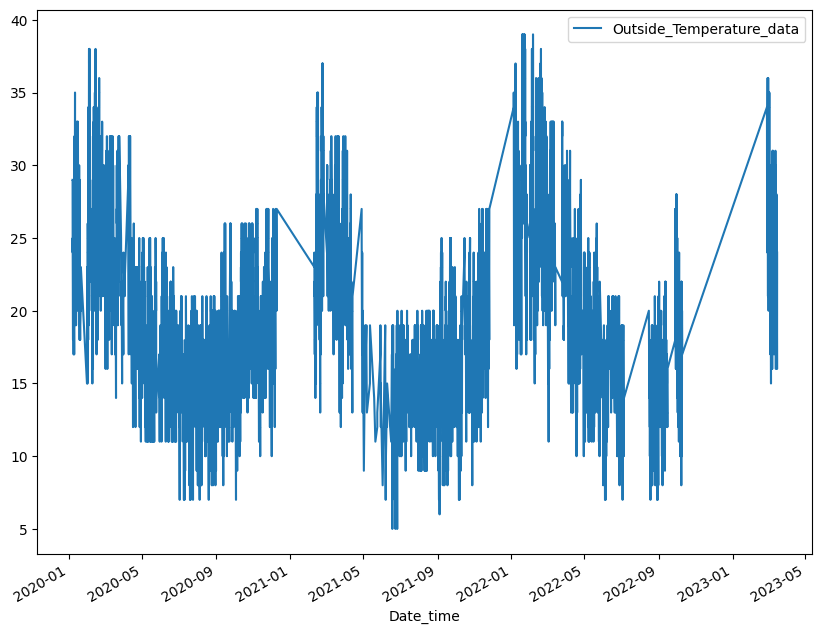

In [23]:
dfinput.plot()

In [24]:
data_hourly = dfinput.resample('H').mean().ffill()
data_hourly

Outside_Temperature_data
Date_time                                    
2020-01-07 13:00:00                 28.351351
2020-01-07 14:00:00                 28.166667
2020-01-07 15:00:00                 28.116667
2020-01-07 16:00:00                 26.700000
2020-01-07 17:00:00                 24.966667
...                                       ...
2023-03-15 05:00:00                 24.333333
2023-03-15 06:00:00                 24.333333
2023-03-15 07:00:00                 16.600000
2023-03-15 08:00:00                 19.833333
2023-03-15 09:00:00                 22.104167

[27909 rows x 1 columns]

In [25]:
data_hourly=data_hourly[27300:]
data_hourly.shape

(609, 1)

In [26]:
data_hourly=data_hourly[200:]
data_hourly.shape

(409, 1)

In [27]:
data_hourly

Outside_Temperature_data
Date_time                                    
2023-02-26 09:00:00                 17.500000
2023-02-26 10:00:00                 17.500000
2023-02-26 11:00:00                 17.500000
2023-02-26 12:00:00                 17.500000
2023-02-26 13:00:00                 17.500000
...                                       ...
2023-03-15 05:00:00                 24.333333
2023-03-15 06:00:00                 24.333333
2023-03-15 07:00:00                 16.600000
2023-03-15 08:00:00                 19.833333
2023-03-15 09:00:00                 22.104167

[409 rows x 1 columns]

<Axes: xlabel='Date_time'>

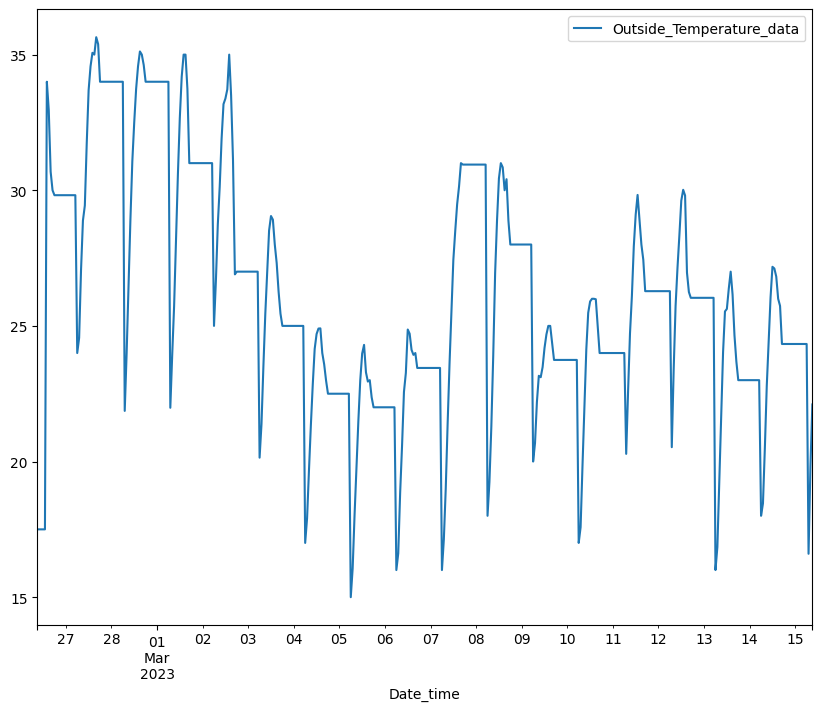

In [28]:
data_hourly.plot()

In [29]:
data_hourly.agg(['skew', 'kurtosis']).transpose()

skew  kurtosis
Outside_Temperature_data  0.14368 -0.385554

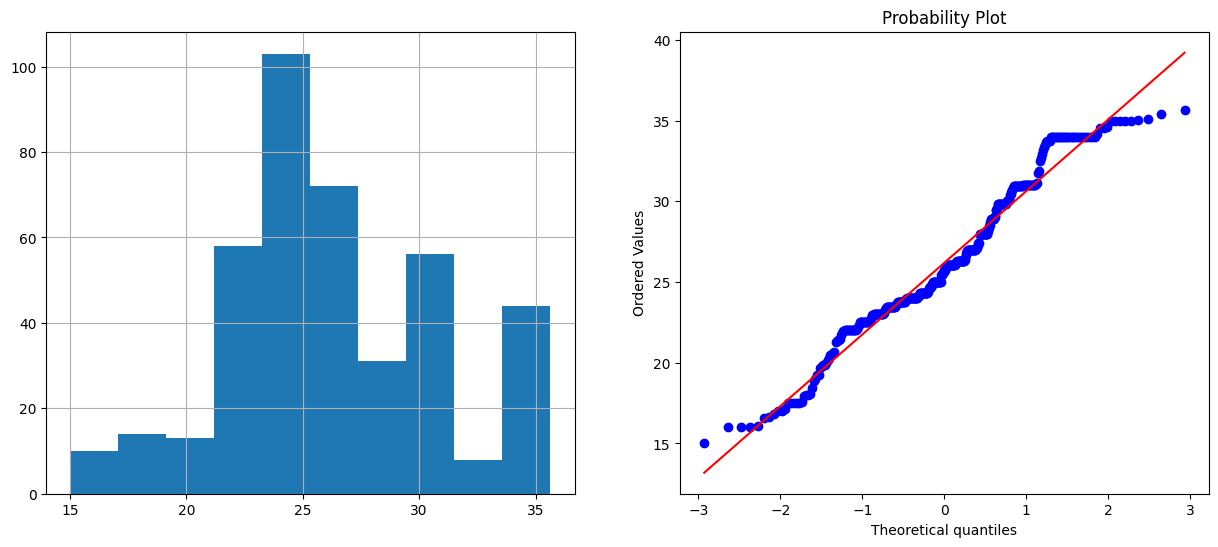

In [30]:
import scipy.stats as stats
def diagnostic_plots(df, variable):
    # function to plot a histogram and a Q-Q plot
    # side by side, for a certain variable
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    df[variable].hist()
    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.show()
diagnostic_plots(data_hourly,'Outside_Temperature_data')

In [31]:
data_hourly

Outside_Temperature_data
Date_time                                    
2023-02-26 09:00:00                 17.500000
2023-02-26 10:00:00                 17.500000
2023-02-26 11:00:00                 17.500000
2023-02-26 12:00:00                 17.500000
2023-02-26 13:00:00                 17.500000
...                                       ...
2023-03-15 05:00:00                 24.333333
2023-03-15 06:00:00                 24.333333
2023-03-15 07:00:00                 16.600000
2023-03-15 08:00:00                 19.833333
2023-03-15 09:00:00                 22.104167

[409 rows x 1 columns]

In [32]:
dfinput1=data_hourly[:250]
dfinput1

Outside_Temperature_data
Date_time                                    
2023-02-26 09:00:00                 17.500000
2023-02-26 10:00:00                 17.500000
2023-02-26 11:00:00                 17.500000
2023-02-26 12:00:00                 17.500000
2023-02-26 13:00:00                 17.500000
...                                       ...
2023-03-08 14:00:00                 30.844828
2023-03-08 15:00:00                 30.000000
2023-03-08 16:00:00                 30.407407
2023-03-08 17:00:00                 28.879310
2023-03-08 18:00:00                 28.000000

[250 rows x 1 columns]

In [33]:
org=data_hourly[250:]
org

Outside_Temperature_data
Date_time                                    
2023-03-08 19:00:00                 28.000000
2023-03-08 20:00:00                 28.000000
2023-03-08 21:00:00                 28.000000
2023-03-08 22:00:00                 28.000000
2023-03-08 23:00:00                 28.000000
...                                       ...
2023-03-15 05:00:00                 24.333333
2023-03-15 06:00:00                 24.333333
2023-03-15 07:00:00                 16.600000
2023-03-15 08:00:00                 19.833333
2023-03-15 09:00:00                 22.104167

[159 rows x 1 columns]

In [34]:
dfinput1.shape

(250, 1)

<Axes: xlabel='Date_time'>

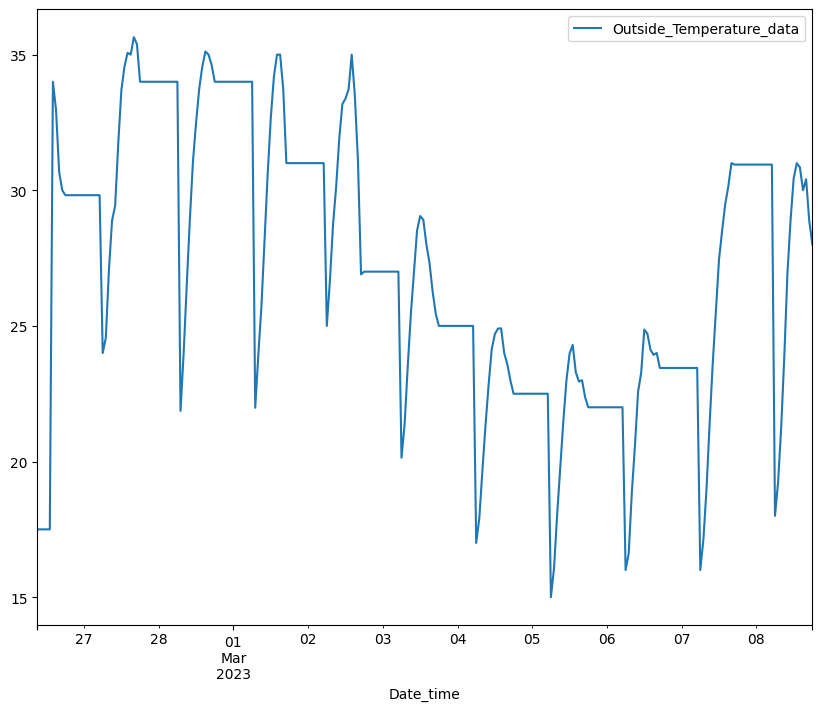

In [35]:
dfinput1.plot()

<Axes: xlabel='Date_time'>

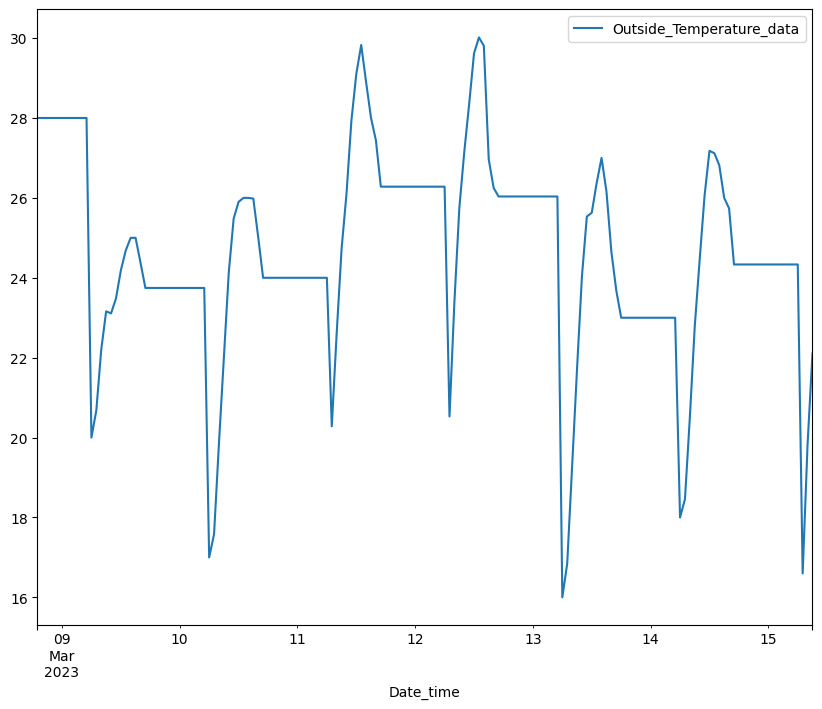

In [36]:
org.plot()

In [37]:
from statsmodels.tsa.stattools import adfuller
def adf_test(series):
    result=adfuller(series)
    print('ADF Statistics: {}'.format(result[0]))
    print('p- value: {}'.format(result[1]))
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [38]:
adf_test(dfinput1['Outside_Temperature_data'].dropna())

ADF Statistics: -4.194985721018053
p- value: 0.0006718968277057153
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


In [58]:
## Use Techniques Differencing
dfinput1['Outside_Temperature_data_Difference']=dfinput1['Outside_Temperature_data']-dfinput1['Outside_Temperature_data'].shift(1)

<ipython-input-58-3266e1e5ab37>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfinput1['Outside_Temperature_data_Difference']=dfinput1['Outside_Temperature_data']-dfinput1['Outside_Temperature_data'].shift(1)


In [59]:
adf_test(dfinput1['Outside_Temperature_data_Difference'].dropna())

ADF Statistics: -9.778826863373409
p- value: 6.819546138935219e-17
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


In [ ]:
## Use Techniques Differencing
#dfinput1['Outside_Temperature_data_2Difference']=dfinput1['Outside_Temperature_data']-dfinput1['Outside_Temperature_data'].shift(1)

In [ ]:
dfinput1['Outside_Temperature_data_Difference 12']=dfinput1['Outside_Temperature_data']-dfinput1['Outside_Temperature_data'].shift(12)

<ipython-input-39-714533a69d3f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfinput1['Outside_Temperature_data_Difference 12']=dfinput1['Outside_Temperature_data']-dfinput1['Outside_Temperature_data'].shift(12)


/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


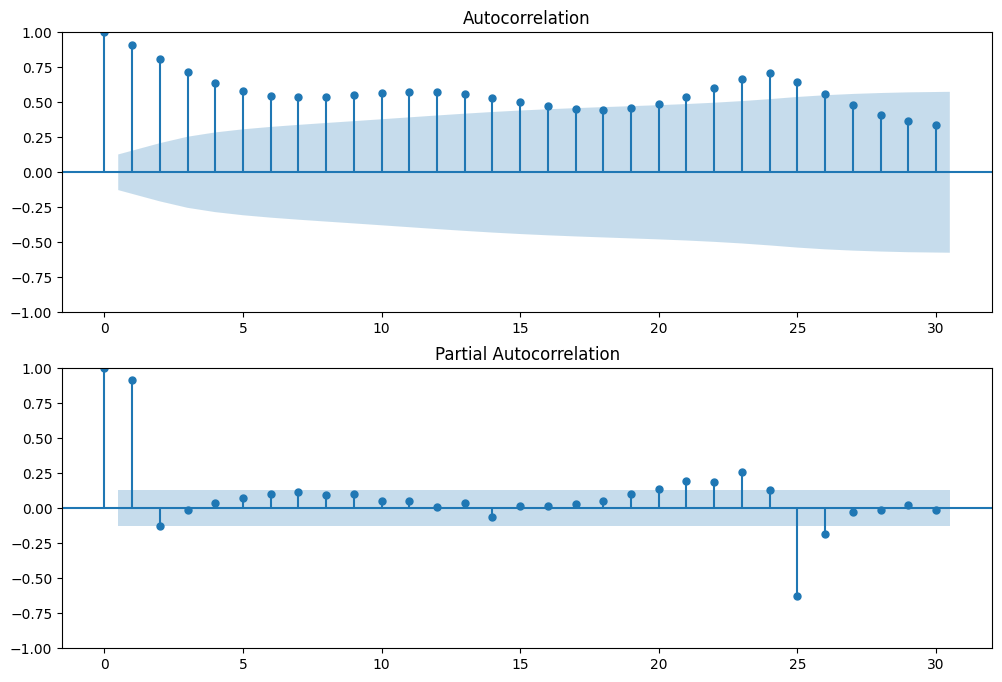

In [39]:
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(dfinput1['Outside_Temperature_data'].iloc[13:],lags=30,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(dfinput1['Outside_Temperature_data'].iloc[13:],lags=30,ax=ax2)

In [39]:
# Use auto_arima to select the optimal p and q values
import pmdarima as pm
model = pm.auto_arima(dfinput1['Outside_Temperature_data'], seasonal=True, m=12, start_p=4, start_q=4,
                      max_p=24, max_q=24, d=1, D=None, trace=True,
                      error_action='ignore', suppress_warnings=True,
                      stepwise=True)

# Get the selected p and q values
p, q = model.order[0], model.order[2]


Performing stepwise search to minimize aic
 ARIMA(4,1,4)(1,0,1)[12] intercept   : AIC=inf, Time=3.56 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1124.670, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1127.962, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1127.999, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1122.754, Time=0.02 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=1126.402, Time=0.10 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=1126.550, Time=0.13 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=1091.130, Time=0.45 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=1019.880, Time=0.71 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=1017.889, Time=0.64 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=1015.907, Time=1.01 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=1017.907, Time=1.21 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=1092.479, Time=0.66 sec
 ARIMA(2,1,0)(2,0,0)[12] intercept   : AIC=1014.479, Time=0.79 sec
 ARIMA(2,1,0)(1,0,0)[12]

In [40]:
model=sm.tsa.statespace.SARIMAX(dfinput1['Outside_Temperature_data'],order=(1,1,1),seasonal_order=(2,0,0,12))
results=model.fit()

<ipython-input-41-9917425af536>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfinput1['forecast']=results.predict(start=80,dynamic=True)


<Axes: xlabel='Date_time'>

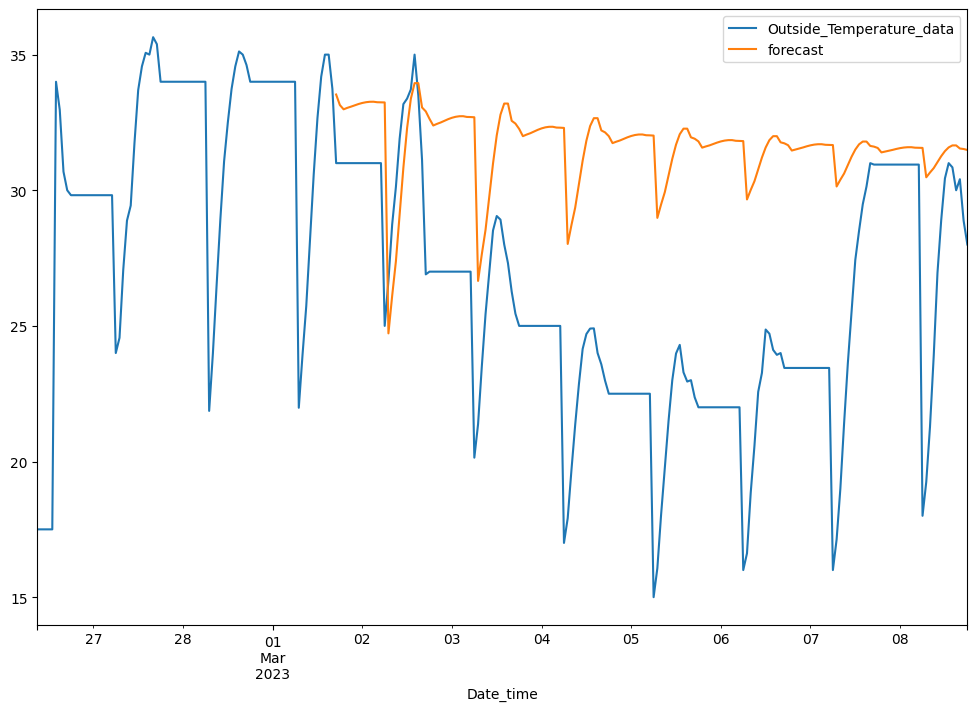

In [41]:
dfinput1['forecast']=results.predict(start=80,dynamic=True)
dfinput1[['Outside_Temperature_data','forecast']].plot(figsize=(12,8))

In [42]:
# Predict the next 6 hours of data
forecast =results.forecast(steps=100)
# Print the forecasted values
print(forecast)

2023-03-08 19:00:00    28.652229
2023-03-08 20:00:00    29.129358
2023-03-08 21:00:00    29.483779
2023-03-08 22:00:00    29.752213
2023-03-08 23:00:00    29.937931
                         ...    
2023-03-12 18:00:00    28.385338
2023-03-12 19:00:00    28.570044
2023-03-12 20:00:00    28.722899
2023-03-12 21:00:00    28.853979
2023-03-12 22:00:00    28.970189
Freq: H, Name: predicted_mean, Length: 100, dtype: float64


In [43]:
org

Outside_Temperature_data
Date_time                                    
2023-03-08 19:00:00                 28.000000
2023-03-08 20:00:00                 28.000000
2023-03-08 21:00:00                 28.000000
2023-03-08 22:00:00                 28.000000
2023-03-08 23:00:00                 28.000000
...                                       ...
2023-03-15 05:00:00                 24.333333
2023-03-15 06:00:00                 24.333333
2023-03-15 07:00:00                 16.600000
2023-03-15 08:00:00                 19.833333
2023-03-15 09:00:00                 22.104167

[159 rows x 1 columns]

In [44]:
import pandas as pd
y_test = pd.DataFrame(forecast)
#y_test= pd.Data_Frame(forecast,colunms=["Y_test"])
y_test.to_csv("sarimax.csv")

In [45]:
org.to_csv("sarimaxt.csv")

In [46]:
# Generate the dates for the next 6 hours
last_hour = dfinput1.index[-1]
future_dates = pd.date_range(last_hour, periods=10, freq='H')

# Predict the next 6 hours of data
forecast = results.forecast(steps=10)

# Combine the forecasted values and the future dates into a new DataFrame
forecast_df = pd.DataFrame(forecast, index=future_dates, columns=['predicted_value'])

# Print the forecasted values and dates
print(forecast_df)

                    predicted_value
2023-03-08 18:00:00             NaN
2023-03-08 19:00:00             NaN
2023-03-08 20:00:00             NaN
2023-03-08 21:00:00             NaN
2023-03-08 22:00:00             NaN
2023-03-08 23:00:00             NaN
2023-03-09 00:00:00             NaN
2023-03-09 01:00:00             NaN
2023-03-09 02:00:00             NaN
2023-03-09 03:00:00             NaN


In [47]:
y_test.columns

Index(['predicted_mean'], dtype='object')

In [48]:
df_merged = pd.merge(y_test, org['Outside_Temperature_data'], left_index=True, right_index=True)


In [49]:
df_merged

predicted_mean  Outside_Temperature_data
2023-03-08 19:00:00       28.652229                 28.000000
2023-03-08 20:00:00       29.129358                 28.000000
2023-03-08 21:00:00       29.483779                 28.000000
2023-03-08 22:00:00       29.752213                 28.000000
2023-03-08 23:00:00       29.937931                 28.000000
...                             ...                       ...
2023-03-12 18:00:00       28.385338                 26.035088
2023-03-12 19:00:00       28.570044                 26.035088
2023-03-12 20:00:00       28.722899                 26.035088
2023-03-12 21:00:00       28.853979                 26.035088
2023-03-12 22:00:00       28.970189                 26.035088

[100 rows x 2 columns]

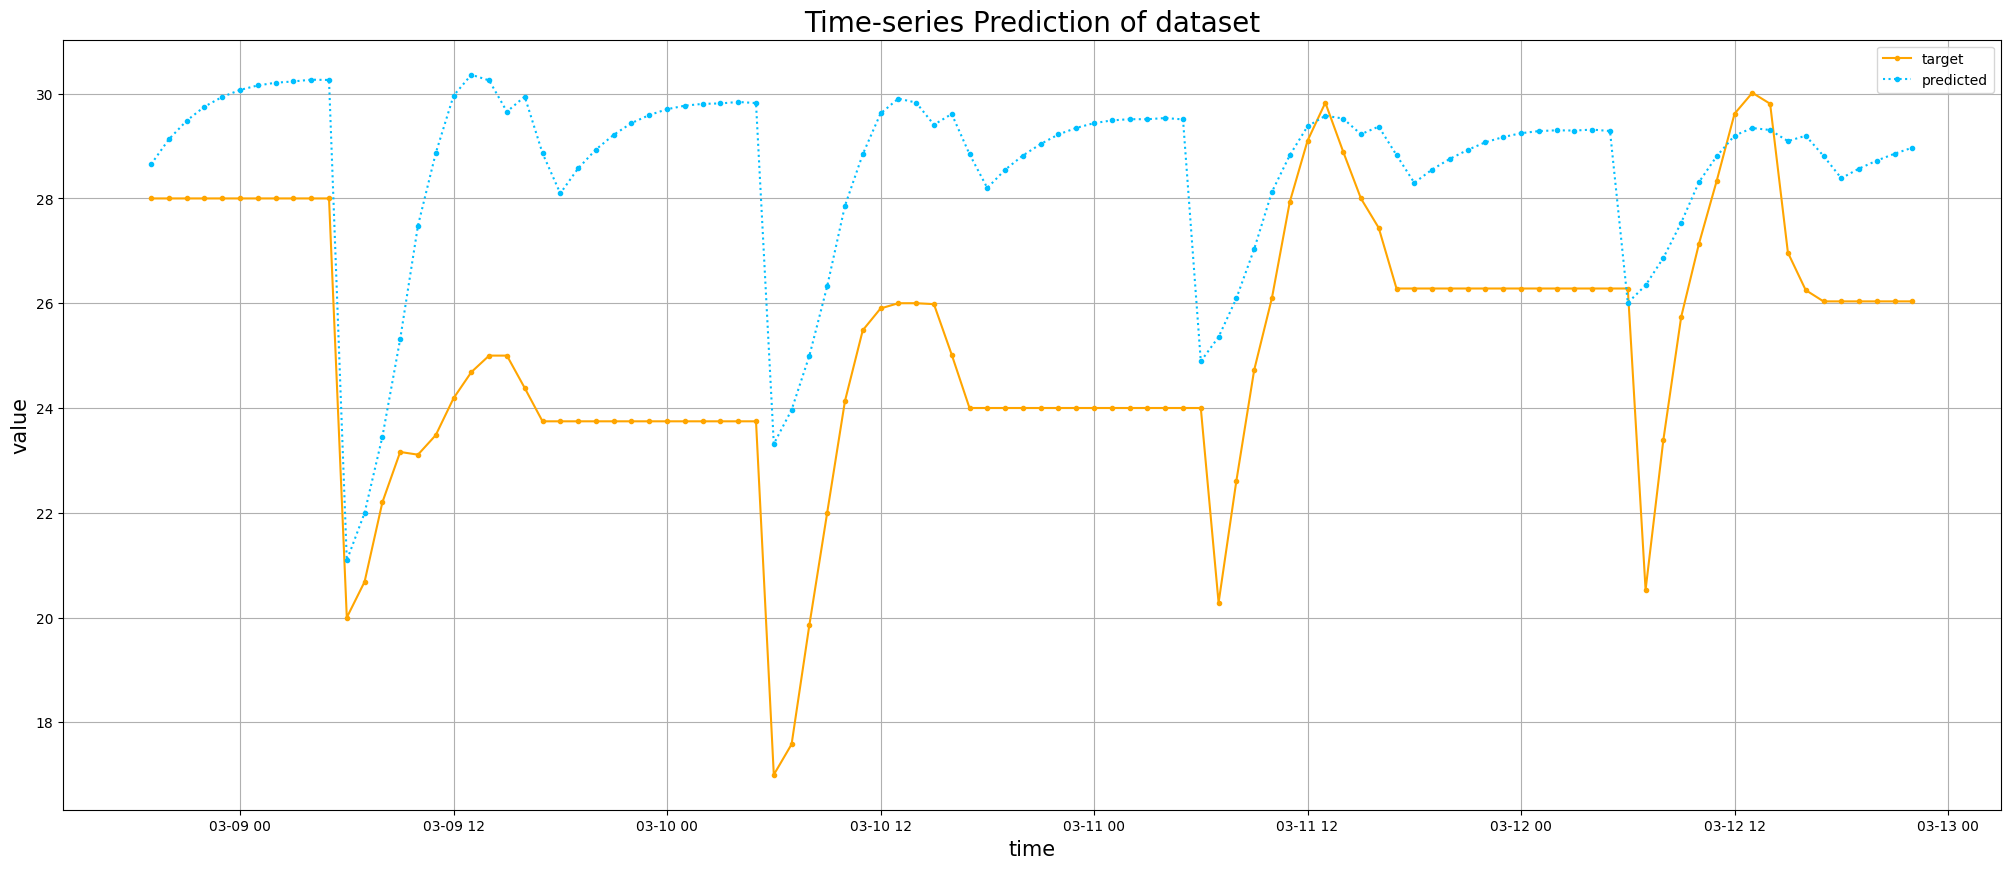

In [50]:
plt.figure(figsize=(25,10))
targetPlot,=plt.plot(df_merged.Outside_Temperature_data,label='target',color='orange',marker='.',linestyle='-')
predictedPlot,=plt.plot(df_merged.predicted_mean,label='predicted',color='deepskyblue',marker='.',linestyle=':')
plt.ylabel('value',fontsize=15)
plt.xlabel('time',fontsize=15)
plt.ion()
plt.grid()
plt.legend(handles=[targetPlot, predictedPlot])
plt.title('Time-series Prediction of dataset',fontsize=20,fontweight=40)
plt.draw()
plt.show()
plt.pause(0)


In [51]:
df_merged.columns

Index(['predicted_mean', 'Outside_Temperature_data'], dtype='object')

In [52]:
df_merged

predicted_mean  Outside_Temperature_data
2023-03-08 19:00:00       28.652229                 28.000000
2023-03-08 20:00:00       29.129358                 28.000000
2023-03-08 21:00:00       29.483779                 28.000000
2023-03-08 22:00:00       29.752213                 28.000000
2023-03-08 23:00:00       29.937931                 28.000000
...                             ...                       ...
2023-03-12 18:00:00       28.385338                 26.035088
2023-03-12 19:00:00       28.570044                 26.035088
2023-03-12 20:00:00       28.722899                 26.035088
2023-03-12 21:00:00       28.853979                 26.035088
2023-03-12 22:00:00       28.970189                 26.035088

[100 rows x 2 columns]

In [53]:
import pandas as pd
# Rename a column
df_merged = df_merged.drop('Outside_Temperature_data', axis=1)
df_input_model = df_merged.rename(columns={'predicted_mean': 'Outside_Temperature_datap'})
df_input_model

Outside_Temperature_datap
2023-03-08 19:00:00                  28.652229
2023-03-08 20:00:00                  29.129358
2023-03-08 21:00:00                  29.483779
2023-03-08 22:00:00                  29.752213
2023-03-08 23:00:00                  29.937931
...                                        ...
2023-03-12 18:00:00                  28.385338
2023-03-12 19:00:00                  28.570044
2023-03-12 20:00:00                  28.722899
2023-03-12 21:00:00                  28.853979
2023-03-12 22:00:00                  28.970189

[100 rows x 1 columns]

**Module temperature**
---

In [55]:
df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'TS1_SENS0700_TmpMdul_C_data',
       'Barometer_data', 'Outside_Humidity_data', 'Outside_Temperature_data',
       'Solar_Radiation_data', 'TS1_P1_data', 'Wx', 'Wy', 'Date', 'Time',
       'Date_time_name', 'Day sin', 'Day cos', 'Year sin', 'Year cos'],
      dtype='object')

In [56]:
dfinput =df[['TS1_SENS0700_TmpMdul_C_data']]

In [57]:
dfinput.shape

(415006, 1)

<Axes: xlabel='Date_time'>

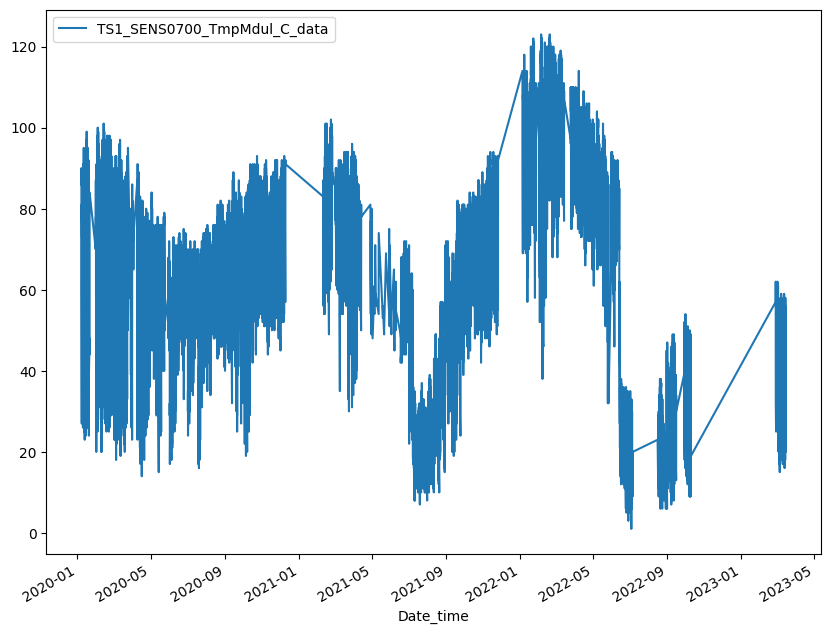

In [58]:
dfinput.plot()

In [59]:
data_hourly = dfinput.resample('H').mean().ffill()
data_hourly

TS1_SENS0700_TmpMdul_C_data
Date_time                                       
2020-01-07 13:00:00                    85.648649
2020-01-07 14:00:00                    86.083333
2020-01-07 15:00:00                    88.316667
2020-01-07 16:00:00                    86.316667
2020-01-07 17:00:00                    77.766667
...                                          ...
2023-03-15 05:00:00                    41.719298
2023-03-15 06:00:00                    41.719298
2023-03-15 07:00:00                    31.760000
2023-03-15 08:00:00                    44.383333
2023-03-15 09:00:00                    50.479167

[27909 rows x 1 columns]

In [60]:
data_hourly=data_hourly[27300:]
data_hourly.shape

(609, 1)

In [61]:
data_hourly=data_hourly[200:]
data_hourly.shape

(409, 1)

In [62]:
data_hourly

TS1_SENS0700_TmpMdul_C_data
Date_time                                       
2023-02-26 09:00:00                    19.291667
2023-02-26 10:00:00                    19.291667
2023-02-26 11:00:00                    19.291667
2023-02-26 12:00:00                    19.291667
2023-02-26 13:00:00                    19.291667
...                                          ...
2023-03-15 05:00:00                    41.719298
2023-03-15 06:00:00                    41.719298
2023-03-15 07:00:00                    31.760000
2023-03-15 08:00:00                    44.383333
2023-03-15 09:00:00                    50.479167

[409 rows x 1 columns]

<Axes: xlabel='Date_time'>

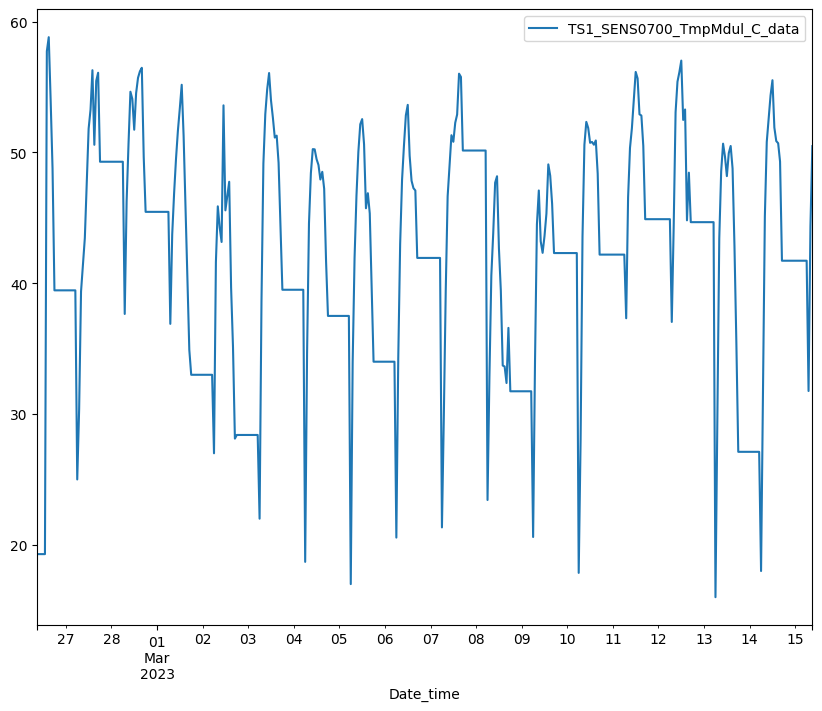

In [63]:
data_hourly.plot()

In [64]:
data_hourly.agg(['skew', 'kurtosis']).transpose()

skew  kurtosis
TS1_SENS0700_TmpMdul_C_data -0.671726  0.051684

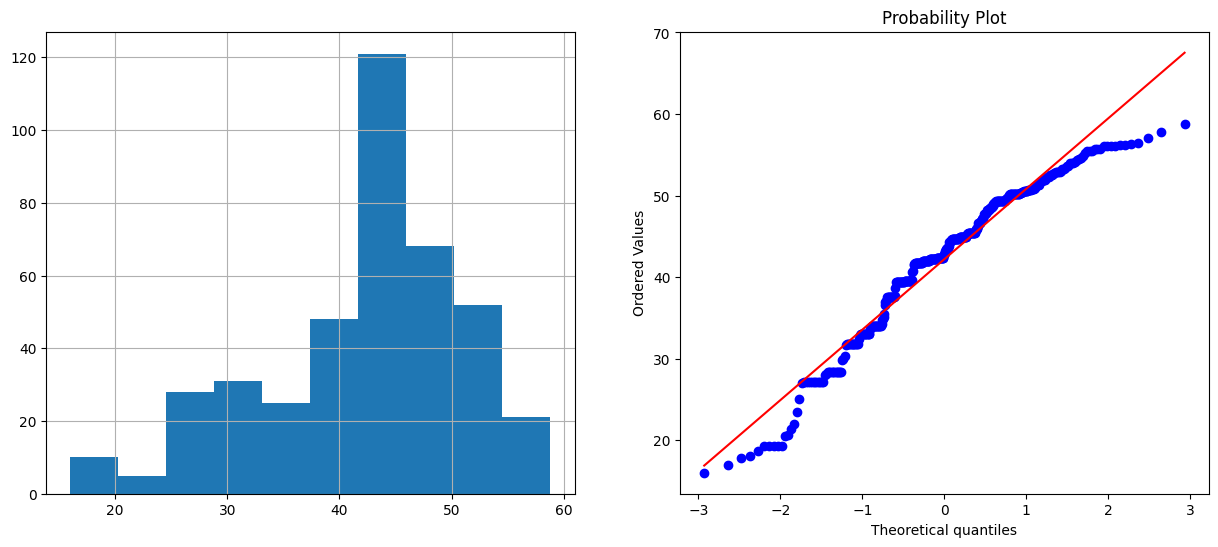

In [65]:
import scipy.stats as stats
def diagnostic_plots(df, variable):
    # function to plot a histogram and a Q-Q plot
    # side by side, for a certain variable
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    df[variable].hist()
    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.show()
diagnostic_plots(data_hourly,'TS1_SENS0700_TmpMdul_C_data')

In [66]:
data_hourly

TS1_SENS0700_TmpMdul_C_data
Date_time                                       
2023-02-26 09:00:00                    19.291667
2023-02-26 10:00:00                    19.291667
2023-02-26 11:00:00                    19.291667
2023-02-26 12:00:00                    19.291667
2023-02-26 13:00:00                    19.291667
...                                          ...
2023-03-15 05:00:00                    41.719298
2023-03-15 06:00:00                    41.719298
2023-03-15 07:00:00                    31.760000
2023-03-15 08:00:00                    44.383333
2023-03-15 09:00:00                    50.479167

[409 rows x 1 columns]

In [67]:
dfinput1=data_hourly[:250]
dfinput1

TS1_SENS0700_TmpMdul_C_data
Date_time                                       
2023-02-26 09:00:00                    19.291667
2023-02-26 10:00:00                    19.291667
2023-02-26 11:00:00                    19.291667
2023-02-26 12:00:00                    19.291667
2023-02-26 13:00:00                    19.291667
...                                          ...
2023-03-08 14:00:00                    33.706897
2023-03-08 15:00:00                    33.633333
2023-03-08 16:00:00                    32.370370
2023-03-08 17:00:00                    36.586207
2023-03-08 18:00:00                    31.739130

[250 rows x 1 columns]

In [68]:
org=data_hourly[250:]
org

TS1_SENS0700_TmpMdul_C_data
Date_time                                       
2023-03-08 19:00:00                    31.739130
2023-03-08 20:00:00                    31.739130
2023-03-08 21:00:00                    31.739130
2023-03-08 22:00:00                    31.739130
2023-03-08 23:00:00                    31.739130
...                                          ...
2023-03-15 05:00:00                    41.719298
2023-03-15 06:00:00                    41.719298
2023-03-15 07:00:00                    31.760000
2023-03-15 08:00:00                    44.383333
2023-03-15 09:00:00                    50.479167

[159 rows x 1 columns]

In [69]:
dfinput1.shape

(250, 1)

<Axes: xlabel='Date_time'>

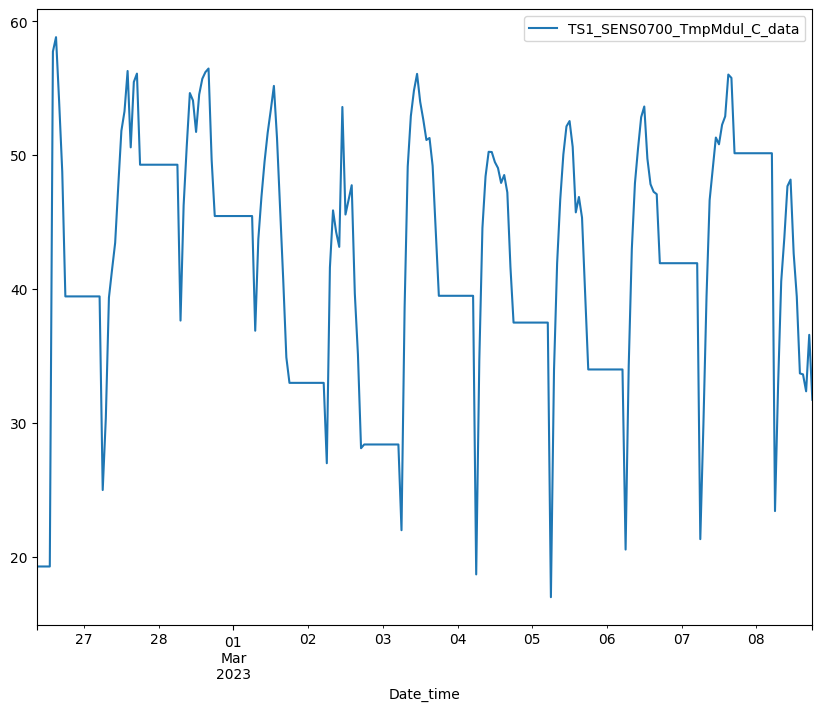

In [70]:
dfinput1.plot()

<Axes: xlabel='Date_time'>

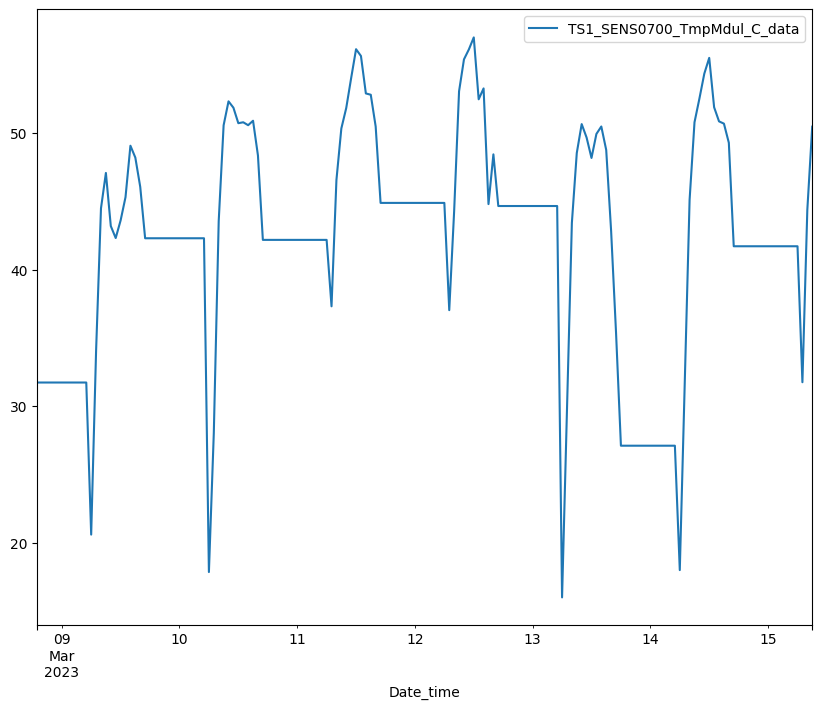

In [71]:
org.plot()

In [72]:
from statsmodels.tsa.stattools import adfuller
def adf_test(series):
    result=adfuller(series)
    print('ADF Statistics: {}'.format(result[0]))
    print('p- value: {}'.format(result[1]))
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [73]:
adf_test(dfinput1['TS1_SENS0700_TmpMdul_C_data'].dropna())

ADF Statistics: -5.433958859454865
p- value: 2.8731143498909824e-06
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


In [ ]:
## Use Techniques Differencing
dfinput1['Outside_Temperature_data_Difference']=dfinput1['Outside_Temperature_data']-dfinput1['Outside_Temperature_data'].shift(1)

<ipython-input-58-3266e1e5ab37>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfinput1['Outside_Temperature_data_Difference']=dfinput1['Outside_Temperature_data']-dfinput1['Outside_Temperature_data'].shift(1)


In [ ]:
adf_test(dfinput1['Outside_Temperature_data_Difference'].dropna())

ADF Statistics: -9.778826863373409
p- value: 6.819546138935219e-17
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


In [ ]:
## Use Techniques Differencing
#dfinput1['Outside_Temperature_data_2Difference']=dfinput1['Outside_Temperature_data']-dfinput1['Outside_Temperature_data'].shift(1)

In [ ]:
dfinput1['Outside_Temperature_data_Difference 12']=dfinput1['Outside_Temperature_data']-dfinput1['Outside_Temperature_data'].shift(12)

<ipython-input-39-714533a69d3f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfinput1['Outside_Temperature_data_Difference 12']=dfinput1['Outside_Temperature_data']-dfinput1['Outside_Temperature_data'].shift(12)


/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


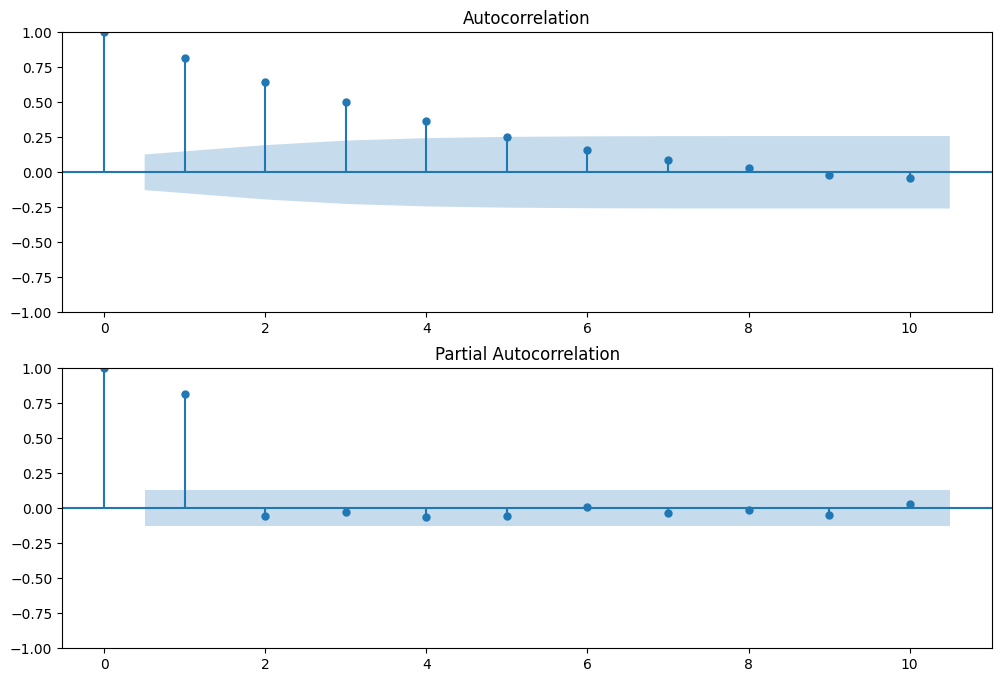

In [74]:
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(dfinput1['TS1_SENS0700_TmpMdul_C_data'].iloc[13:],lags=10,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(dfinput1['TS1_SENS0700_TmpMdul_C_data'].iloc[13:],lags=10,ax=ax2)

In [74]:
# Use auto_arima to select the optimal p and q values
import pmdarima as pm
model = pm.auto_arima(dfinput1['TS1_SENS0700_TmpMdul_C_data'], seasonal=True, m=12, start_p=1, start_q=1,
                      max_p=10, max_q=10, d=1, D=None, trace=True,
                      error_action='ignore', suppress_warnings=True,
                      stepwise=True)

# Get the selected p and q values
p, q = model.order[0], model.order[2]

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=1.93 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1566.743, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1566.637, Time=0.21 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1568.944, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1564.763, Time=0.02 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=1564.841, Time=0.22 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=1567.074, Time=0.22 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=1515.024, Time=0.40 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=1438.860, Time=0.52 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=1436.941, Time=0.37 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=1438.396, Time=0.55 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=1438.150, Time=0.51 sec
 ARIMA(1,1,1)(2,0,0)[12] intercept   : AIC=inf, Time=2.95 sec
 ARIMA(0,1,0)(2,0,0)[12]             : AIC=1434.948, Time=0.19 sec
 ARIMA(0,1,0)(1,0,0)[12]     

In [75]:
model=sm.tsa.statespace.SARIMAX(dfinput1['TS1_SENS0700_TmpMdul_C_data'],order=(1,1,3),seasonal_order=(2,0,0,12))
results=model.fit()

<ipython-input-76-a607d2069f27>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfinput1['forecast']=results.predict(start=80,dynamic=True)


<Axes: xlabel='Date_time'>

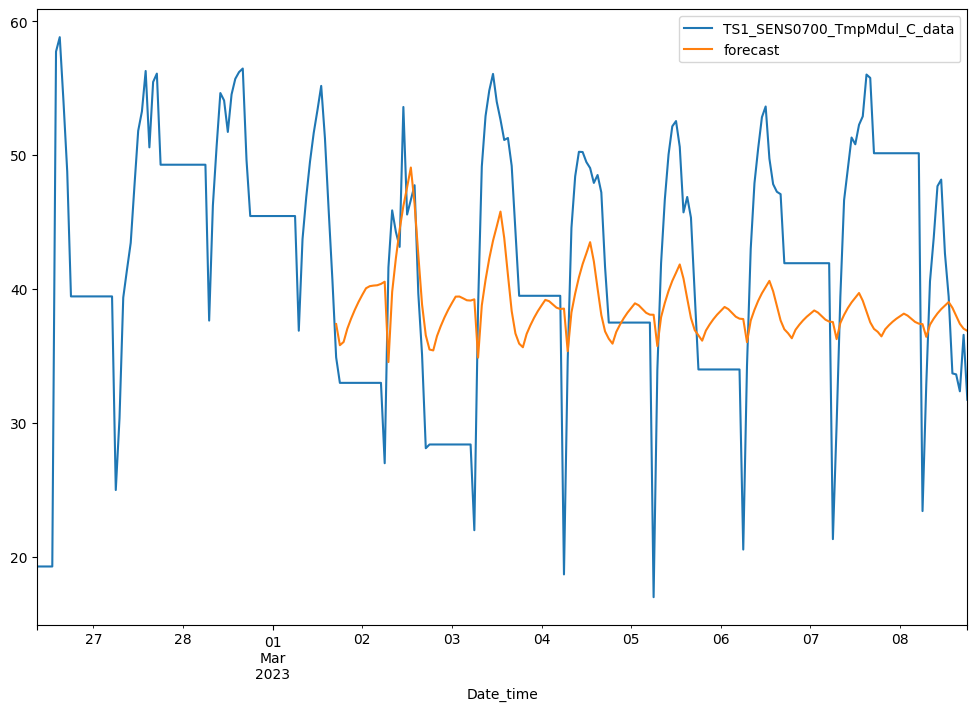

In [76]:
dfinput1['forecast']=results.predict(start=80,dynamic=True)
dfinput1[['TS1_SENS0700_TmpMdul_C_data','forecast']].plot(figsize=(12,8))

In [77]:
# Predict the next 6 hours of data
forecast =results.forecast(steps=100)
# Print the forecasted values
print(forecast)

2023-03-08 19:00:00    32.961904
2023-03-08 20:00:00    35.041448
2023-03-08 21:00:00    36.262734
2023-03-08 22:00:00    37.422303
2023-03-08 23:00:00    38.319186
                         ...    
2023-03-12 18:00:00    33.689767
2023-03-12 19:00:00    34.716321
2023-03-12 20:00:00    35.882323
2023-03-12 21:00:00    36.519246
2023-03-12 22:00:00    37.166788
Freq: H, Name: predicted_mean, Length: 100, dtype: float64


In [78]:
org

TS1_SENS0700_TmpMdul_C_data
Date_time                                       
2023-03-08 19:00:00                    31.739130
2023-03-08 20:00:00                    31.739130
2023-03-08 21:00:00                    31.739130
2023-03-08 22:00:00                    31.739130
2023-03-08 23:00:00                    31.739130
...                                          ...
2023-03-15 05:00:00                    41.719298
2023-03-15 06:00:00                    41.719298
2023-03-15 07:00:00                    31.760000
2023-03-15 08:00:00                    44.383333
2023-03-15 09:00:00                    50.479167

[159 rows x 1 columns]

In [79]:
import pandas as pd
y_test = pd.DataFrame(forecast)
#y_test= pd.Data_Frame(forecast,colunms=["Y_test"])
y_test.to_csv("sarimax.csv")

In [80]:
org.to_csv("sarimaxt.csv")

In [81]:
# Generate the dates for the next 6 hours
last_hour = dfinput1.index[-1]
future_dates = pd.date_range(last_hour, periods=10, freq='H')

# Predict the next 6 hours of data
forecast = results.forecast(steps=10)

# Combine the forecasted values and the future dates into a new DataFrame
forecast_df = pd.DataFrame(forecast, index=future_dates, columns=['predicted_value'])

# Print the forecasted values and dates
print(forecast_df)

                    predicted_value
2023-03-08 18:00:00             NaN
2023-03-08 19:00:00             NaN
2023-03-08 20:00:00             NaN
2023-03-08 21:00:00             NaN
2023-03-08 22:00:00             NaN
2023-03-08 23:00:00             NaN
2023-03-09 00:00:00             NaN
2023-03-09 01:00:00             NaN
2023-03-09 02:00:00             NaN
2023-03-09 03:00:00             NaN


In [82]:
df_merged2 = pd.merge(y_test, org['TS1_SENS0700_TmpMdul_C_data'], left_index=True, right_index=True)
df_merged2

predicted_mean  TS1_SENS0700_TmpMdul_C_data
2023-03-08 19:00:00       32.961904                    31.739130
2023-03-08 20:00:00       35.041448                    31.739130
2023-03-08 21:00:00       36.262734                    31.739130
2023-03-08 22:00:00       37.422303                    31.739130
2023-03-08 23:00:00       38.319186                    31.739130
...                             ...                          ...
2023-03-12 18:00:00       33.689767                    44.666667
2023-03-12 19:00:00       34.716321                    44.666667
2023-03-12 20:00:00       35.882323                    44.666667
2023-03-12 21:00:00       36.519246                    44.666667
2023-03-12 22:00:00       37.166788                    44.666667

[100 rows x 2 columns]

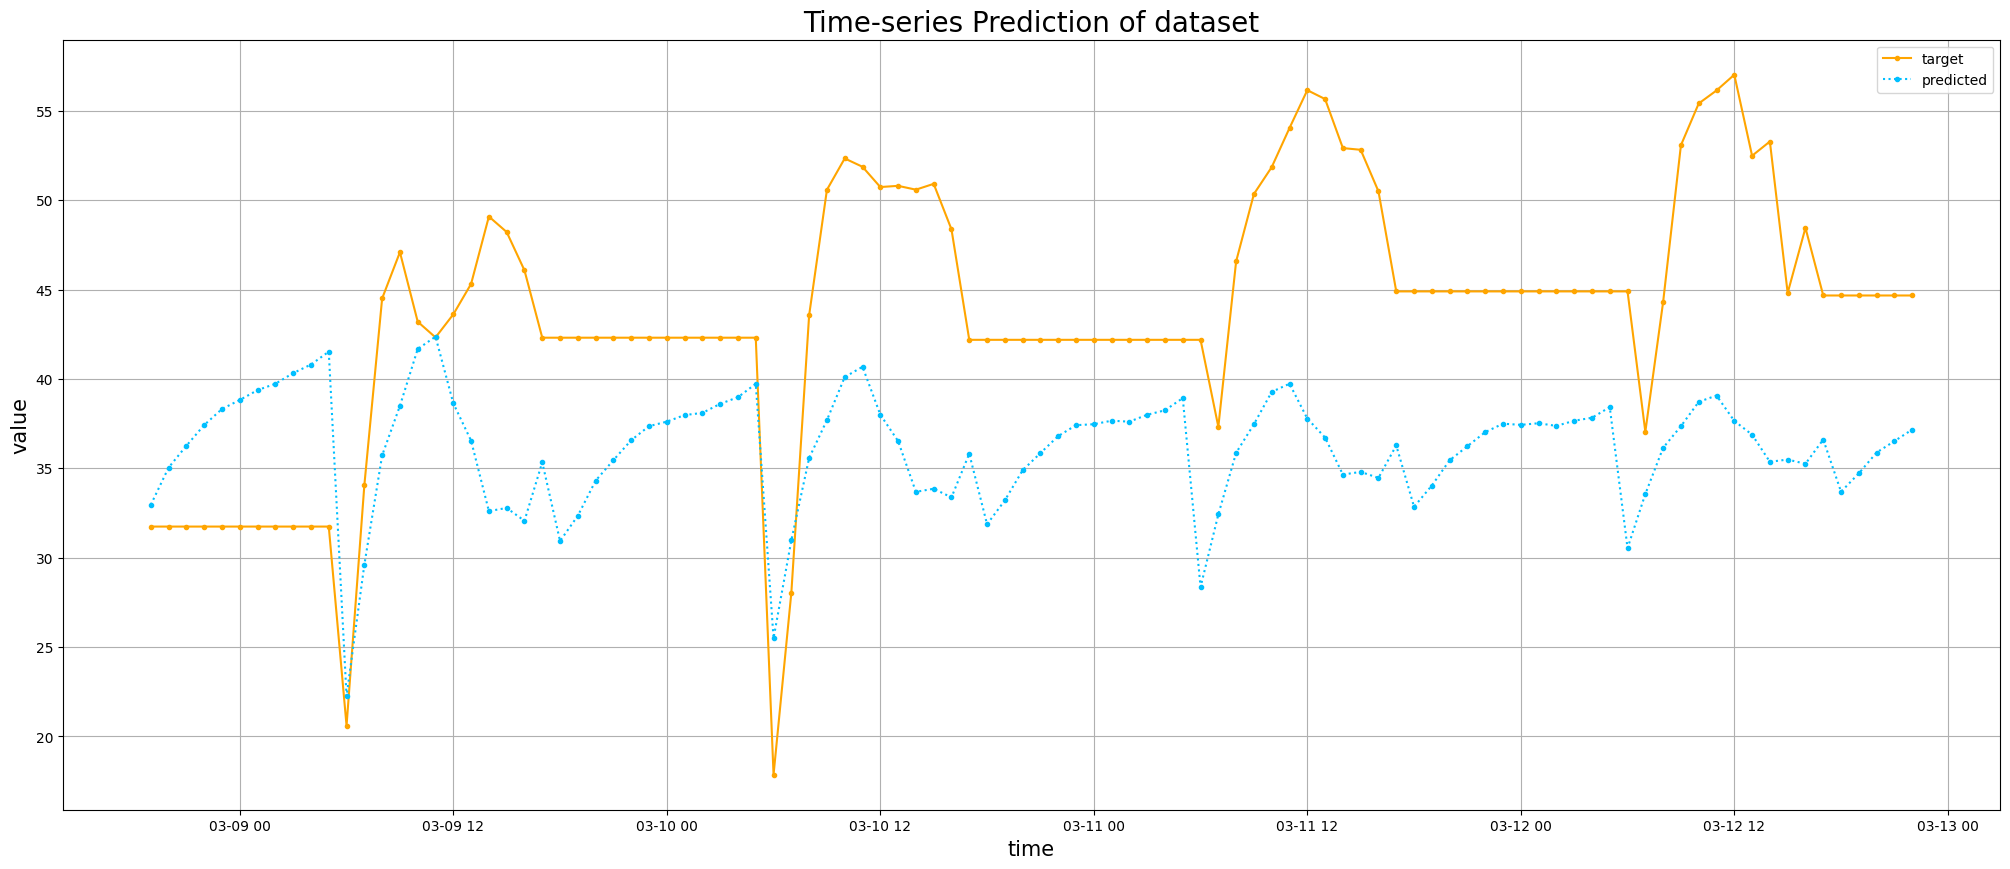

In [83]:
plt.figure(figsize=(25,10))
targetPlot,=plt.plot(df_merged2.TS1_SENS0700_TmpMdul_C_data,label='target',color='orange',marker='.',linestyle='-')
predictedPlot,=plt.plot(df_merged2.predicted_mean,label='predicted',color='deepskyblue',marker='.',linestyle=':')
plt.ylabel('value',fontsize=15)
plt.xlabel('time',fontsize=15)
plt.ion()
plt.grid()
plt.legend(handles=[targetPlot, predictedPlot])
plt.title('Time-series Prediction of dataset',fontsize=20,fontweight=40)
plt.draw()
plt.show()
plt.pause(0)


In [84]:
import pandas as pd
# Rename a column
df_merged2= df_merged2.drop('TS1_SENS0700_TmpMdul_C_data', axis=1)
df_input_model2 = df_merged2.rename(columns={'predicted_mean': 'TS1_SENS0700_TmpMdul_C_data'})
df_input_model2

TS1_SENS0700_TmpMdul_C_data
2023-03-08 19:00:00                    32.961904
2023-03-08 20:00:00                    35.041448
2023-03-08 21:00:00                    36.262734
2023-03-08 22:00:00                    37.422303
2023-03-08 23:00:00                    38.319186
...                                          ...
2023-03-12 18:00:00                    33.689767
2023-03-12 19:00:00                    34.716321
2023-03-12 20:00:00                    35.882323
2023-03-12 21:00:00                    36.519246
2023-03-12 22:00:00                    37.166788

[100 rows x 1 columns]

In [85]:
df_input_model

Outside_Temperature_datap
2023-03-08 19:00:00                  28.652229
2023-03-08 20:00:00                  29.129358
2023-03-08 21:00:00                  29.483779
2023-03-08 22:00:00                  29.752213
2023-03-08 23:00:00                  29.937931
...                                        ...
2023-03-12 18:00:00                  28.385338
2023-03-12 19:00:00                  28.570044
2023-03-12 20:00:00                  28.722899
2023-03-12 21:00:00                  28.853979
2023-03-12 22:00:00                  28.970189

[100 rows x 1 columns]

In [86]:
import pandas as pd

# Concatenate two data frames horizontally
df_input_model = pd.concat([df_input_model, df_input_model2], axis=1)
df_input_model

Outside_Temperature_datap  TS1_SENS0700_TmpMdul_C_data
2023-03-08 19:00:00                  28.652229                    32.961904
2023-03-08 20:00:00                  29.129358                    35.041448
2023-03-08 21:00:00                  29.483779                    36.262734
2023-03-08 22:00:00                  29.752213                    37.422303
2023-03-08 23:00:00                  29.937931                    38.319186
...                                        ...                          ...
2023-03-12 18:00:00                  28.385338                    33.689767
2023-03-12 19:00:00                  28.570044                    34.716321
2023-03-12 20:00:00                  28.722899                    35.882323
2023-03-12 21:00:00                  28.853979                    36.519246
2023-03-12 22:00:00                  28.970189                    37.166788

[100 rows x 2 columns]

**Barometer**
---

In [87]:
df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'TS1_SENS0700_TmpMdul_C_data',
       'Barometer_data', 'Outside_Humidity_data', 'Outside_Temperature_data',
       'Solar_Radiation_data', 'TS1_P1_data', 'Wx', 'Wy', 'Date', 'Time',
       'Date_time_name', 'Day sin', 'Day cos', 'Year sin', 'Year cos'],
      dtype='object')

In [88]:
dfinput =df[['Barometer_data']]

In [89]:
dfinput.shape

(415006, 1)

<Axes: xlabel='Date_time'>

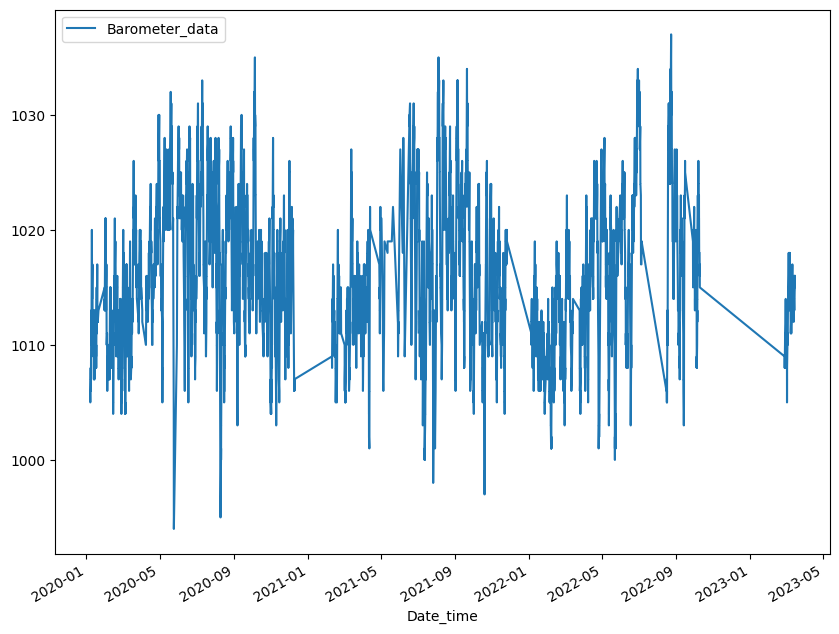

In [90]:
dfinput.plot()

In [91]:
data_hourly = dfinput.resample('H').mean().ffill()
data_hourly

Barometer_data
Date_time                          
2020-01-07 13:00:00     1005.594595
2020-01-07 14:00:00     1005.000000
2020-01-07 15:00:00     1005.000000
2020-01-07 16:00:00     1005.000000
2020-01-07 17:00:00     1005.000000
...                             ...
2023-03-15 05:00:00     1013.964912
2023-03-15 06:00:00     1013.964912
2023-03-15 07:00:00     1016.000000
2023-03-15 08:00:00     1016.000000
2023-03-15 09:00:00     1015.875000

[27909 rows x 1 columns]

In [92]:
data_hourly=data_hourly[27300:]
data_hourly.shape

(609, 1)

In [93]:
data_hourly=data_hourly[200:]
data_hourly.shape

(409, 1)

In [94]:
data_hourly

Barometer_data
Date_time                          
2023-02-26 09:00:00     1015.000000
2023-02-26 10:00:00     1015.000000
2023-02-26 11:00:00     1015.000000
2023-02-26 12:00:00     1015.000000
2023-02-26 13:00:00     1015.000000
...                             ...
2023-03-15 05:00:00     1013.964912
2023-03-15 06:00:00     1013.964912
2023-03-15 07:00:00     1016.000000
2023-03-15 08:00:00     1016.000000
2023-03-15 09:00:00     1015.875000

[409 rows x 1 columns]

<Axes: xlabel='Date_time'>

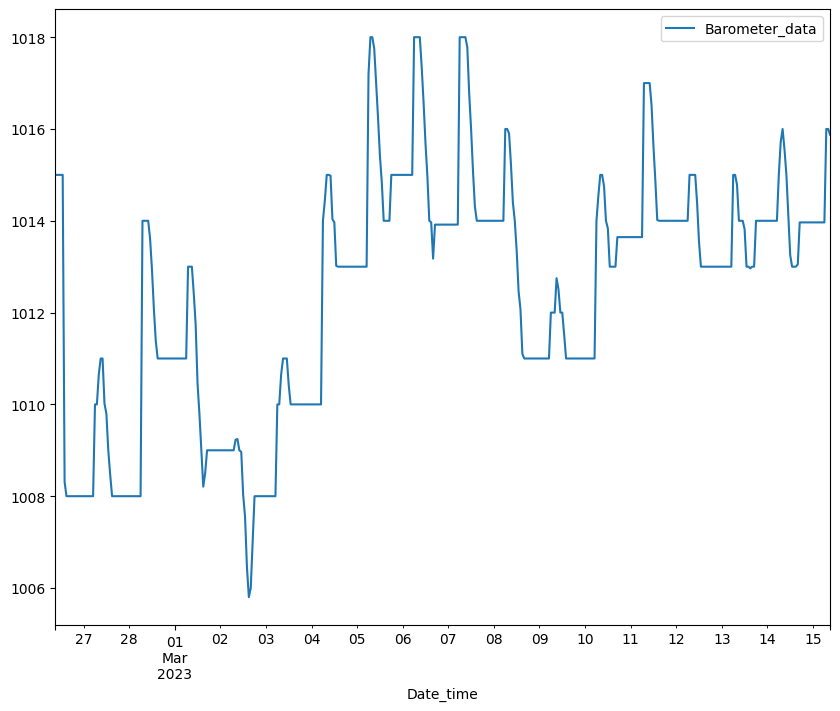

In [95]:
data_hourly.plot()

In [96]:
data_hourly.agg(['skew', 'kurtosis']).transpose()

skew  kurtosis
Barometer_data -0.257266 -0.621444

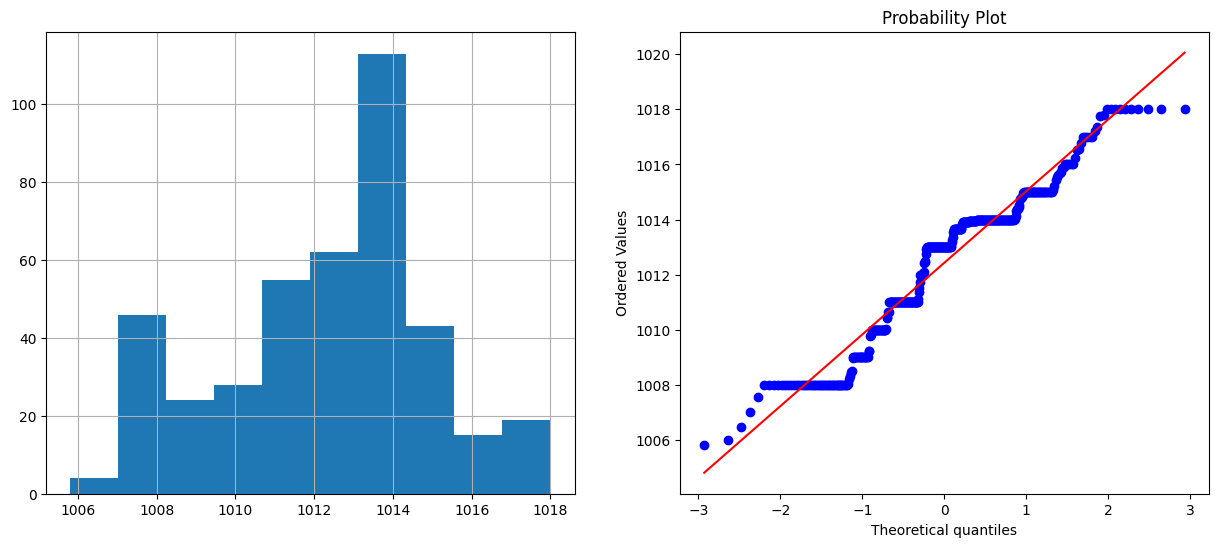

In [97]:
import scipy.stats as stats
def diagnostic_plots(df, variable):
    # function to plot a histogram and a Q-Q plot
    # side by side, for a certain variable
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    df[variable].hist()
    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.show()
diagnostic_plots(data_hourly,'Barometer_data')

In [98]:
data_hourly

Barometer_data
Date_time                          
2023-02-26 09:00:00     1015.000000
2023-02-26 10:00:00     1015.000000
2023-02-26 11:00:00     1015.000000
2023-02-26 12:00:00     1015.000000
2023-02-26 13:00:00     1015.000000
...                             ...
2023-03-15 05:00:00     1013.964912
2023-03-15 06:00:00     1013.964912
2023-03-15 07:00:00     1016.000000
2023-03-15 08:00:00     1016.000000
2023-03-15 09:00:00     1015.875000

[409 rows x 1 columns]

In [99]:
dfinput1=data_hourly[:250]
dfinput1

Barometer_data
Date_time                          
2023-02-26 09:00:00     1015.000000
2023-02-26 10:00:00     1015.000000
2023-02-26 11:00:00     1015.000000
2023-02-26 12:00:00     1015.000000
2023-02-26 13:00:00     1015.000000
...                             ...
2023-03-08 14:00:00     1012.068966
2023-03-08 15:00:00     1011.100000
2023-03-08 16:00:00     1011.000000
2023-03-08 17:00:00     1011.000000
2023-03-08 18:00:00     1011.000000

[250 rows x 1 columns]

In [100]:
org=data_hourly[250:]
org

Barometer_data
Date_time                          
2023-03-08 19:00:00     1011.000000
2023-03-08 20:00:00     1011.000000
2023-03-08 21:00:00     1011.000000
2023-03-08 22:00:00     1011.000000
2023-03-08 23:00:00     1011.000000
...                             ...
2023-03-15 05:00:00     1013.964912
2023-03-15 06:00:00     1013.964912
2023-03-15 07:00:00     1016.000000
2023-03-15 08:00:00     1016.000000
2023-03-15 09:00:00     1015.875000

[159 rows x 1 columns]

In [101]:
dfinput1.shape

(250, 1)

<Axes: xlabel='Date_time'>

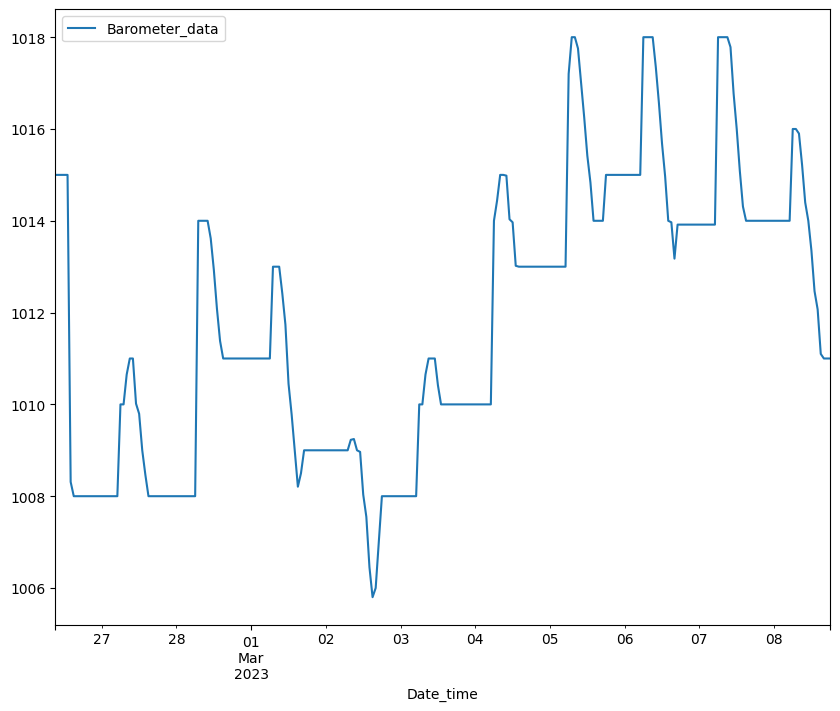

In [102]:
dfinput1.plot()

<Axes: xlabel='Date_time'>

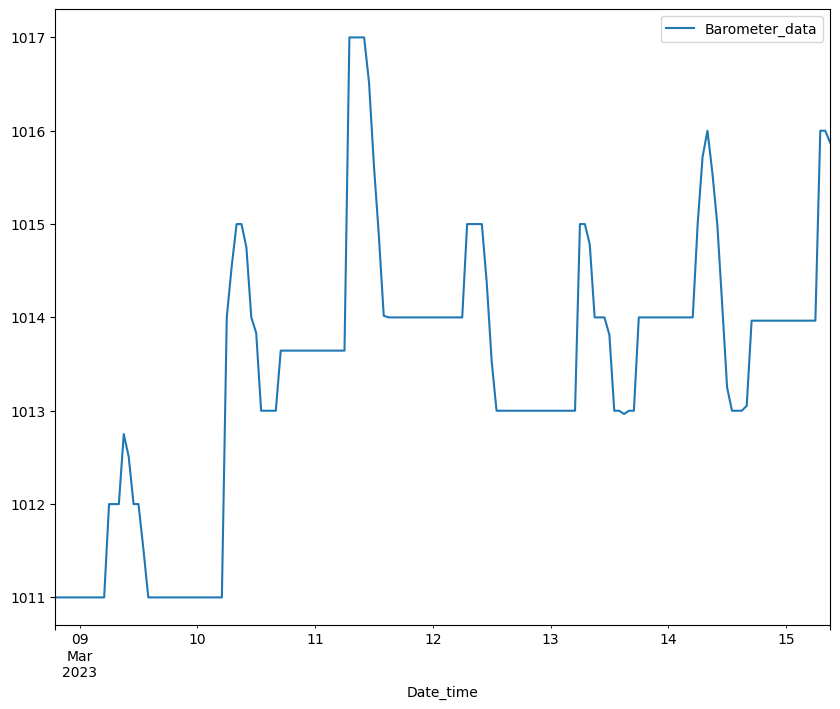

In [103]:
org.plot()

In [104]:
from statsmodels.tsa.stattools import adfuller
def adf_test(series):
    result=adfuller(series)
    print('ADF Statistics: {}'.format(result[0]))
    print('p- value: {}'.format(result[1]))
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [105]:
adf_test(dfinput1['Barometer_data'].dropna())

ADF Statistics: -3.0338642514910243
p- value: 0.03185065939812318
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


In [ ]:
## Use Techniques Differencing
dfinput1['Barometer_data_Difference']=dfinput1['Barometer_data']-dfinput1['Barometer_data'].shift(1)

In [ ]:
adf_test(dfinput1['Outside_Temperature_data_Difference'].dropna())

In [ ]:
## Use Techniques Differencing
#dfinput1['Outside_Temperature_data_2Difference']=dfinput1['Outside_Temperature_data']-dfinput1['Outside_Temperature_data'].shift(1)

In [ ]:
dfinput1['Outside_Temperature_data_Difference 12']=dfinput1['Outside_Temperature_data']-dfinput1['Outside_Temperature_data'].shift(12)

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


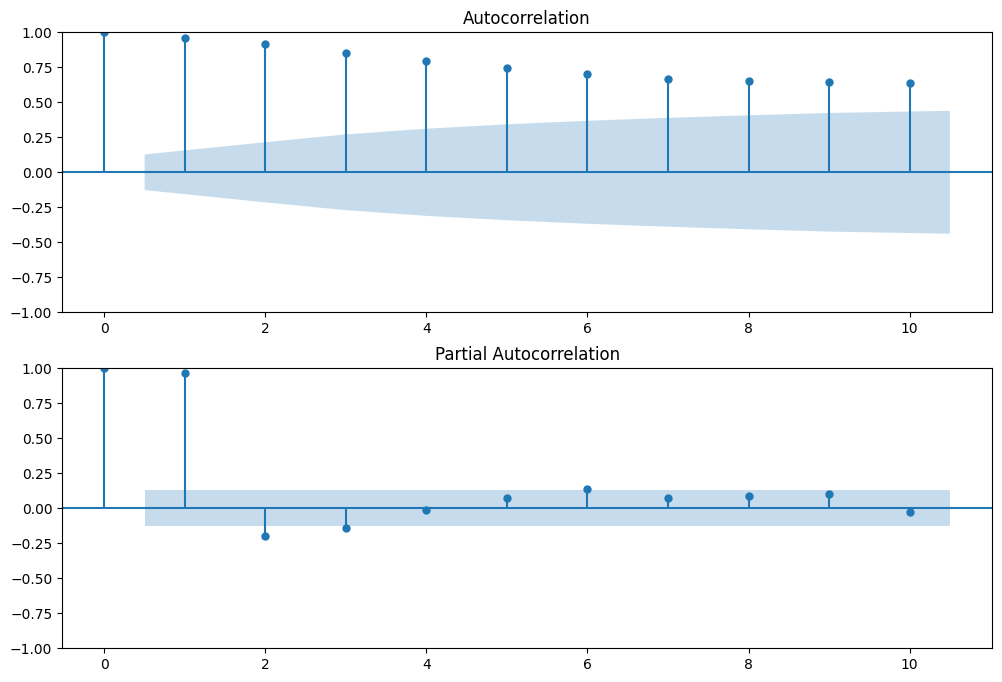

In [106]:
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(dfinput1['Barometer_data'].iloc[13:],lags=10,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(dfinput1['Barometer_data'].iloc[13:],lags=10,ax=ax2)

In [44]:
# Use auto_arima to select the optimal p and q values
import pmdarima as pm
model = pm.auto_arima(dfinput1['Barometer_data'], seasonal=True, m=12, start_p=2, start_q=2,
                      max_p=10, max_q=10, d=1, D=None, trace=True,
                      error_action='ignore', suppress_warnings=True,
                      stepwise=True)

# Get the selected p and q values
p, q = model.order[0], model.order[2]

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=614.507, Time=1.73 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=642.384, Time=0.09 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=640.785, Time=0.27 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=641.902, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=640.469, Time=0.05 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=inf, Time=3.91 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=inf, Time=2.60 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=559.789, Time=6.21 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=557.176, Time=7.06 sec
 ARIMA(1,1,2)(2,0,0)[12] intercept   : AIC=557.179, Time=3.26 sec
 ARIMA(2,1,1)(2,0,0)[12] intercept   : AIC=557.492, Time=2.56 sec
 ARIMA(3,1,2)(2,0,0)[12] intercept   : AIC=inf, Time=4.43 sec
 ARIMA(2,1,3)(2,0,0)[12] intercept   : AIC=560.351, Time=4.44 sec
 ARIMA(1,1,1)(2,0,0)[12] intercept   : AIC=555.499, Time=2.14 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=64

In [107]:
model=sm.tsa.statespace.SARIMAX(dfinput1['Barometer_data'],order=(0,1,0),seasonal_order=(2,0,0,12))
results=model.fit()

<ipython-input-108-cee4ab52e2e7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfinput1['forecast']=results.predict(start=80,dynamic=True)


<Axes: xlabel='Date_time'>

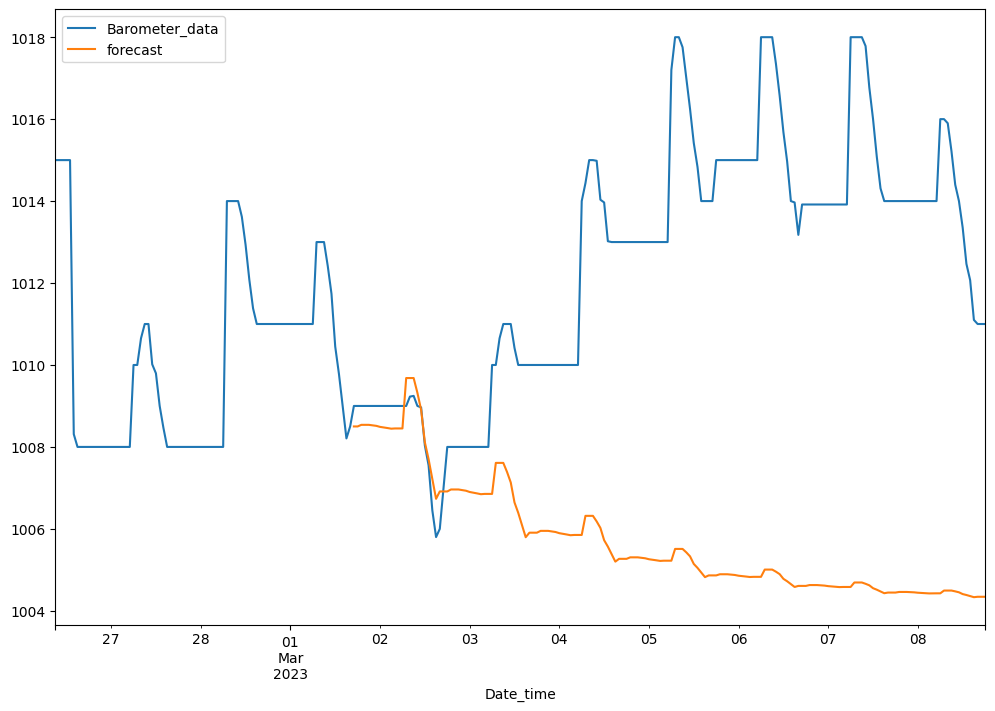

In [108]:
dfinput1['forecast']=results.predict(start=80,dynamic=True)
dfinput1[['Barometer_data','forecast']].plot(figsize=(12,8))

In [109]:
# Predict the next 6 hours of data
forecast =results.forecast(steps=100)
# Print the forecasted values
print(forecast)

2023-03-08 19:00:00    1011.000000
2023-03-08 20:00:00    1010.998046
2023-03-08 21:00:00    1010.984692
2023-03-08 22:00:00    1010.968732
2023-03-08 23:00:00    1010.960915
                          ...     
2023-03-12 18:00:00    1006.569456
2023-03-12 19:00:00    1006.569456
2023-03-12 20:00:00    1006.568058
2023-03-12 21:00:00    1006.558503
2023-03-12 22:00:00    1006.547085
Freq: H, Name: predicted_mean, Length: 100, dtype: float64


In [110]:
org

Barometer_data
Date_time                          
2023-03-08 19:00:00     1011.000000
2023-03-08 20:00:00     1011.000000
2023-03-08 21:00:00     1011.000000
2023-03-08 22:00:00     1011.000000
2023-03-08 23:00:00     1011.000000
...                             ...
2023-03-15 05:00:00     1013.964912
2023-03-15 06:00:00     1013.964912
2023-03-15 07:00:00     1016.000000
2023-03-15 08:00:00     1016.000000
2023-03-15 09:00:00     1015.875000

[159 rows x 1 columns]

In [111]:
import pandas as pd
y_test = pd.DataFrame(forecast)
#y_test= pd.Data_Frame(forecast,colunms=["Y_test"])
y_test.to_csv("sarimax.csv")

In [112]:
org.to_csv("sarimaxt.csv")

In [113]:
# Generate the dates for the next 6 hours
last_hour = dfinput1.index[-1]
future_dates = pd.date_range(last_hour, periods=10, freq='H')

# Predict the next 6 hours of data
forecast = results.forecast(steps=10)

# Combine the forecasted values and the future dates into a new DataFrame
forecast_df = pd.DataFrame(forecast, index=future_dates, columns=['predicted_value'])

# Print the forecasted values and dates
print(forecast_df)

                    predicted_value
2023-03-08 18:00:00             NaN
2023-03-08 19:00:00             NaN
2023-03-08 20:00:00             NaN
2023-03-08 21:00:00             NaN
2023-03-08 22:00:00             NaN
2023-03-08 23:00:00             NaN
2023-03-09 00:00:00             NaN
2023-03-09 01:00:00             NaN
2023-03-09 02:00:00             NaN
2023-03-09 03:00:00             NaN


In [114]:
df_merged3 = pd.merge(y_test, org['Barometer_data'], left_index=True, right_index=True)

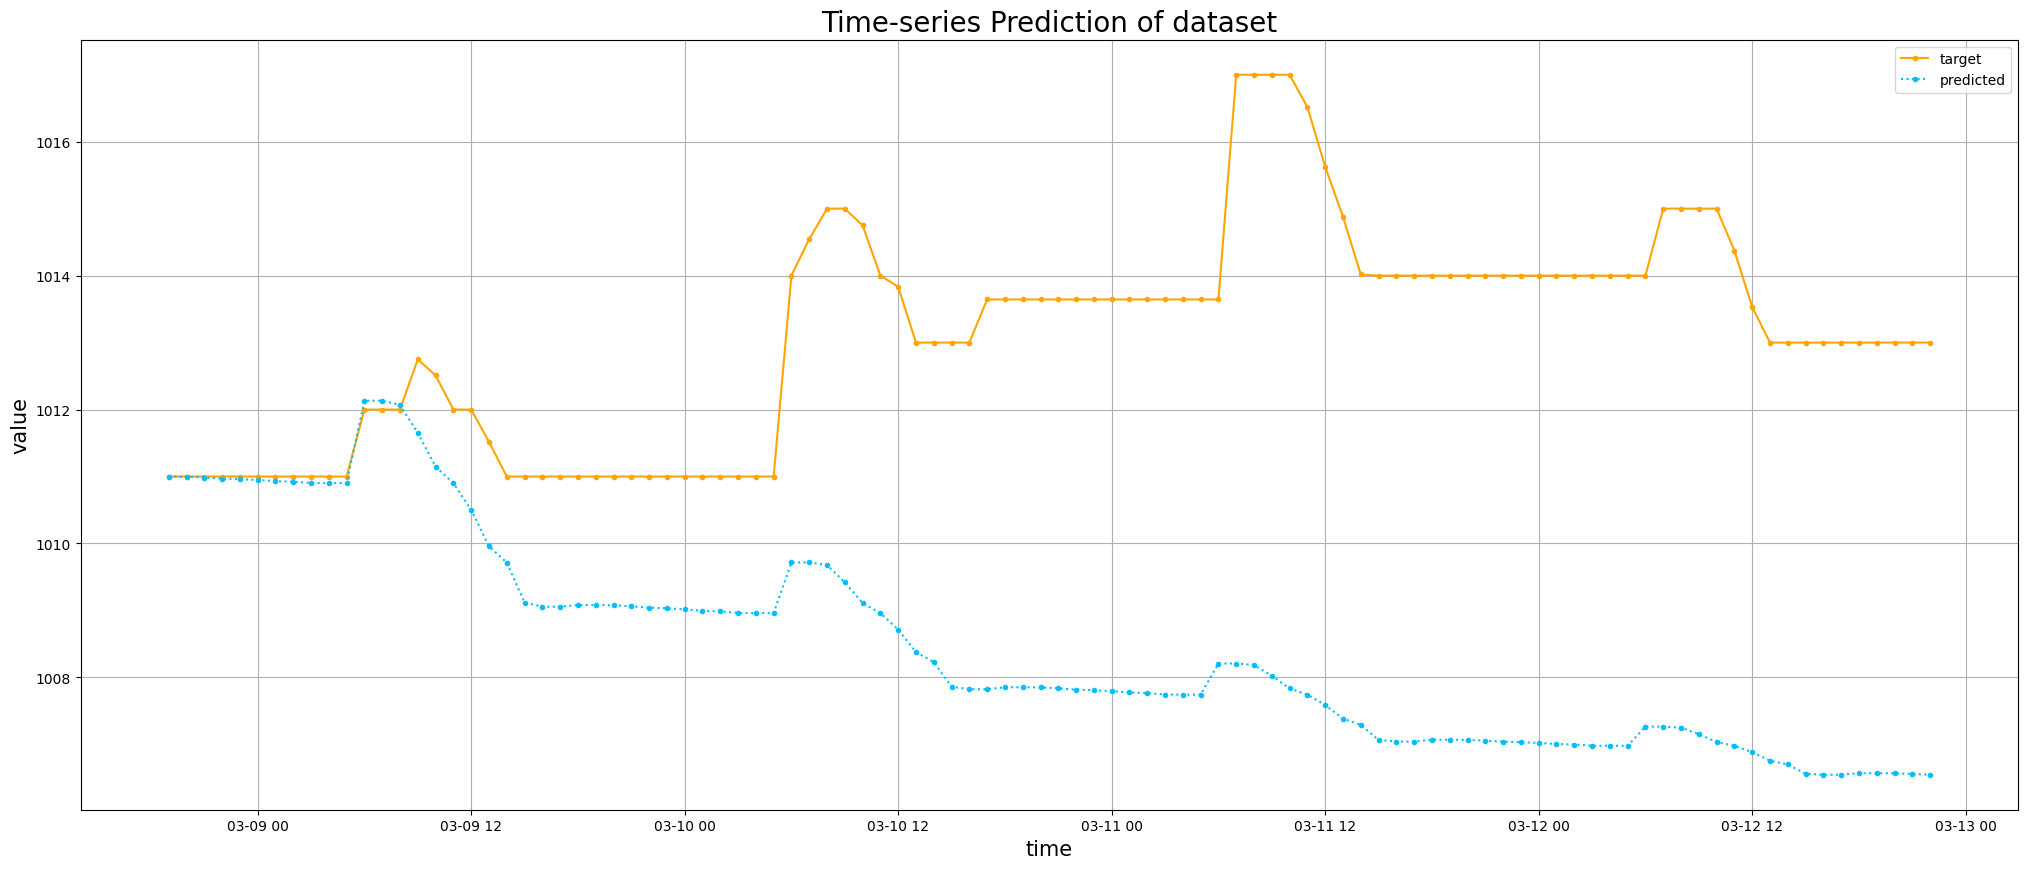

In [115]:
plt.figure(figsize=(25,10))
targetPlot,=plt.plot(df_merged3.Barometer_data,label='target',color='orange',marker='.',linestyle='-')
predictedPlot,=plt.plot(df_merged3.predicted_mean,label='predicted',color='deepskyblue',marker='.',linestyle=':')
plt.ylabel('value',fontsize=15)
plt.xlabel('time',fontsize=15)
plt.ion()
plt.grid()
plt.legend(handles=[targetPlot, predictedPlot])
plt.title('Time-series Prediction of dataset',fontsize=20,fontweight=40)
plt.draw()
plt.show()
plt.pause(0)


In [116]:
df_merged3

predicted_mean  Barometer_data
2023-03-08 19:00:00     1011.000000          1011.0
2023-03-08 20:00:00     1010.998046          1011.0
2023-03-08 21:00:00     1010.984692          1011.0
2023-03-08 22:00:00     1010.968732          1011.0
2023-03-08 23:00:00     1010.960915          1011.0
...                             ...             ...
2023-03-12 18:00:00     1006.569456          1013.0
2023-03-12 19:00:00     1006.569456          1013.0
2023-03-12 20:00:00     1006.568058          1013.0
2023-03-12 21:00:00     1006.558503          1013.0
2023-03-12 22:00:00     1006.547085          1013.0

[100 rows x 2 columns]

In [117]:
df_merged3= df_merged3.drop('Barometer_data', axis=1)
df_input_model3 = df_merged3.rename(columns={'predicted_mean': 'Barometer_data'})
df_input_model3

Barometer_data
2023-03-08 19:00:00     1011.000000
2023-03-08 20:00:00     1010.998046
2023-03-08 21:00:00     1010.984692
2023-03-08 22:00:00     1010.968732
2023-03-08 23:00:00     1010.960915
...                             ...
2023-03-12 18:00:00     1006.569456
2023-03-12 19:00:00     1006.569456
2023-03-12 20:00:00     1006.568058
2023-03-12 21:00:00     1006.558503
2023-03-12 22:00:00     1006.547085

[100 rows x 1 columns]

In [118]:
import pandas as pd
# Concatenate two data frames horizontally
df_input_model = pd.concat([df_input_model, df_input_model3], axis=1)
df_input_model

Outside_Temperature_datap  TS1_SENS0700_TmpMdul_C_data  \
2023-03-08 19:00:00                  28.652229                    32.961904   
2023-03-08 20:00:00                  29.129358                    35.041448   
2023-03-08 21:00:00                  29.483779                    36.262734   
2023-03-08 22:00:00                  29.752213                    37.422303   
2023-03-08 23:00:00                  29.937931                    38.319186   
...                                        ...                          ...   
2023-03-12 18:00:00                  28.385338                    33.689767   
2023-03-12 19:00:00                  28.570044                    34.716321   
2023-03-12 20:00:00                  28.722899                    35.882323   
2023-03-12 21:00:00                  28.853979                    36.519246   
2023-03-12 22:00:00                  28.970189                    37.166788   

                     Barometer_data  
2023-03-08 19:00:00     1011.000000  
2023-03-08 20:00:00     1010.998046  
2023-03-08 21:00:00     1010.984692  
2023-03-08 22:00:00     1010.968732  
2023-03-08 23:00:00     1010.960915  
...                             ...  
2023-03-12 18:00:00     1006.569456  
2023-03-12 19:00:00     1006.569456  
2023-03-12 20:00:00     1006.568058  
2023-03-12 21:00:00     1006.558503  
2023-03-12 22:00:00     1006.547085  

[100 rows x 3 columns]

**Solar_radiation**
---

In [119]:
df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'TS1_SENS0700_TmpMdul_C_data',
       'Barometer_data', 'Outside_Humidity_data', 'Outside_Temperature_data',
       'Solar_Radiation_data', 'TS1_P1_data', 'Wx', 'Wy', 'Date', 'Time',
       'Date_time_name', 'Day sin', 'Day cos', 'Year sin', 'Year cos'],
      dtype='object')

In [120]:
dfinput =df[['Solar_Radiation_data']]

In [121]:
dfinput.shape

(415006, 1)

<Axes: xlabel='Date_time'>

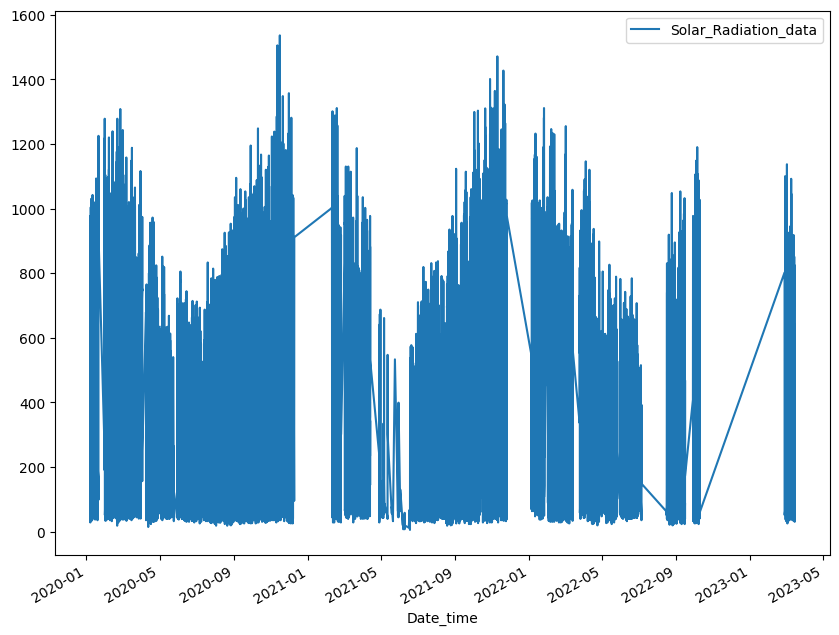

In [122]:
dfinput.plot()

In [123]:
data_hourly = dfinput.resample('H').mean().ffill()
data_hourly

Solar_Radiation_data
Date_time                                
2020-01-07 13:00:00            952.540541
2020-01-07 14:00:00            869.333333
2020-01-07 15:00:00            721.883333
2020-01-07 16:00:00            531.616667
2020-01-07 17:00:00            321.383333
...                                   ...
2023-03-15 05:00:00            167.333333
2023-03-15 06:00:00            167.333333
2023-03-15 07:00:00            111.300000
2023-03-15 08:00:00            412.016667
2023-03-15 09:00:00            577.000000

[27909 rows x 1 columns]

In [124]:
data_hourly=data_hourly[27300:]
data_hourly.shape

(609, 1)

In [125]:
data_hourly=data_hourly[200:]
data_hourly.shape

(409, 1)

In [126]:
data_hourly

Solar_Radiation_data
Date_time                                
2023-02-26 09:00:00             61.291667
2023-02-26 10:00:00             61.291667
2023-02-26 11:00:00             61.291667
2023-02-26 12:00:00             61.291667
2023-02-26 13:00:00             61.291667
...                                   ...
2023-03-15 05:00:00            167.333333
2023-03-15 06:00:00            167.333333
2023-03-15 07:00:00            111.300000
2023-03-15 08:00:00            412.016667
2023-03-15 09:00:00            577.000000

[409 rows x 1 columns]

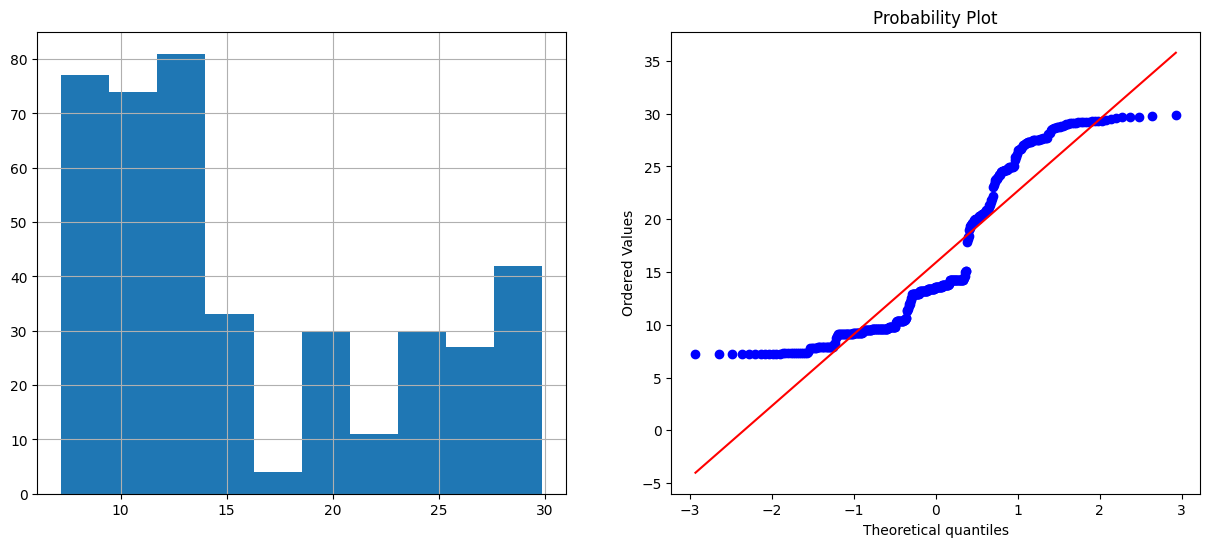

In [127]:
data_hourly['Solar_Radiation_data_SQ']=data_hourly.Solar_Radiation_data**(1/2)
diagnostic_plots(data_hourly,'Solar_Radiation_data_SQ')

In [128]:
data_hourly

Solar_Radiation_data  Solar_Radiation_data_SQ
Date_time                                                         
2023-02-26 09:00:00             61.291667                 7.828899
2023-02-26 10:00:00             61.291667                 7.828899
2023-02-26 11:00:00             61.291667                 7.828899
2023-02-26 12:00:00             61.291667                 7.828899
2023-02-26 13:00:00             61.291667                 7.828899
...                                   ...                      ...
2023-03-15 05:00:00            167.333333                12.935739
2023-03-15 06:00:00            167.333333                12.935739
2023-03-15 07:00:00            111.300000                10.549882
2023-03-15 08:00:00            412.016667                20.298194
2023-03-15 09:00:00            577.000000                24.020824

[409 rows x 2 columns]

<Axes: xlabel='Date_time'>

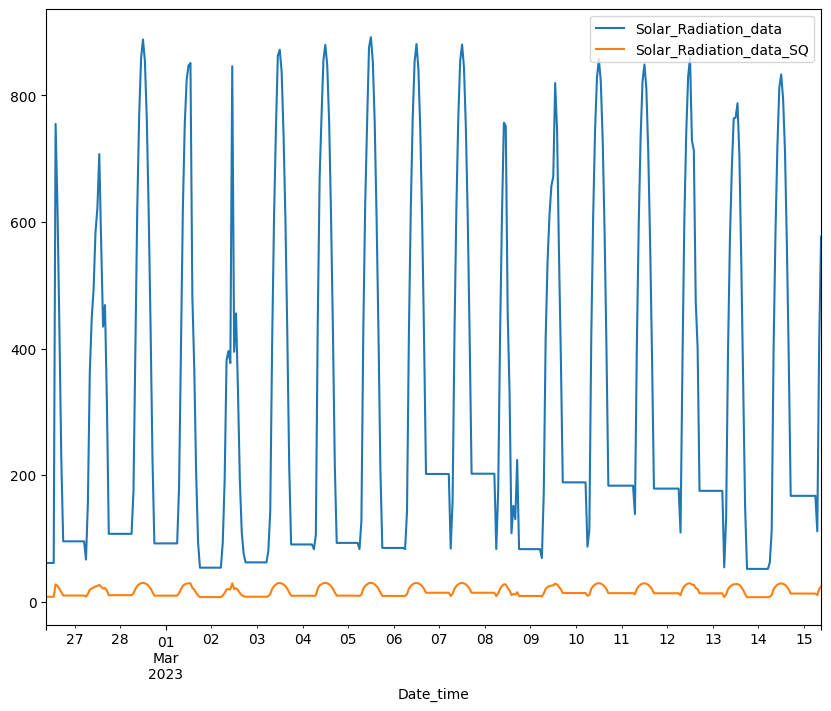

In [129]:
data_hourly.plot()

In [130]:
data_hourly.agg(['skew', 'kurtosis']).transpose()

skew  kurtosis
Solar_Radiation_data     0.957688 -0.586051
Solar_Radiation_data_SQ  0.643856 -1.033063

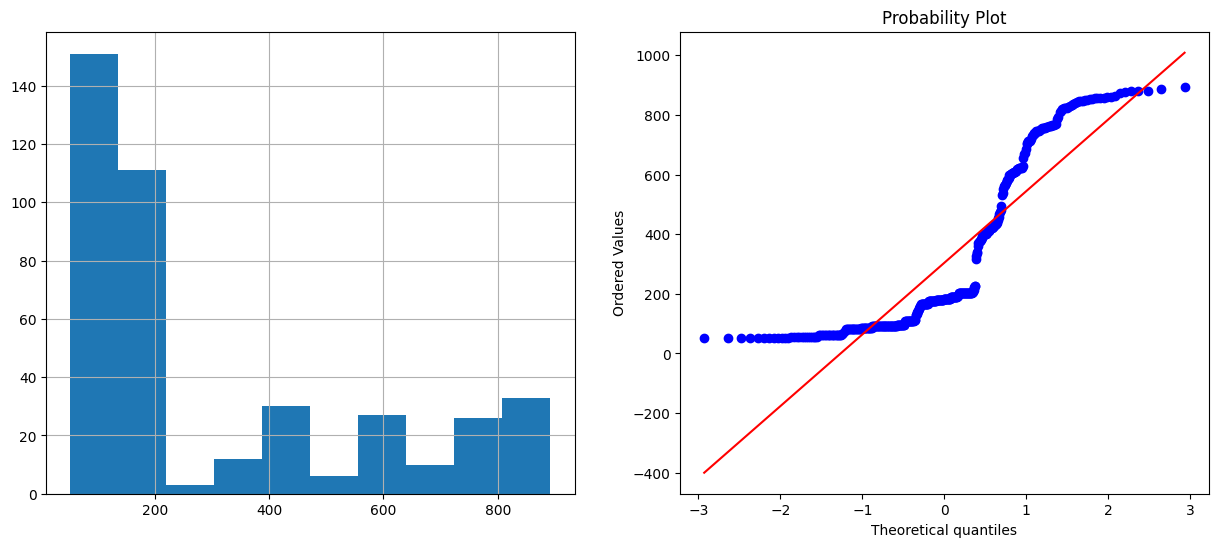

In [131]:
import scipy.stats as stats
def diagnostic_plots(df, variable):
    # function to plot a histogram and a Q-Q plot
    # side by side, for a certain variable
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    df[variable].hist()
    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.show()
diagnostic_plots(data_hourly,'Solar_Radiation_data')

In [132]:
data_hourly

Solar_Radiation_data  Solar_Radiation_data_SQ
Date_time                                                         
2023-02-26 09:00:00             61.291667                 7.828899
2023-02-26 10:00:00             61.291667                 7.828899
2023-02-26 11:00:00             61.291667                 7.828899
2023-02-26 12:00:00             61.291667                 7.828899
2023-02-26 13:00:00             61.291667                 7.828899
...                                   ...                      ...
2023-03-15 05:00:00            167.333333                12.935739
2023-03-15 06:00:00            167.333333                12.935739
2023-03-15 07:00:00            111.300000                10.549882
2023-03-15 08:00:00            412.016667                20.298194
2023-03-15 09:00:00            577.000000                24.020824

[409 rows x 2 columns]

In [133]:
dfinput1=data_hourly[:250]
dfinput1

Solar_Radiation_data  Solar_Radiation_data_SQ
Date_time                                                         
2023-02-26 09:00:00             61.291667                 7.828899
2023-02-26 10:00:00             61.291667                 7.828899
2023-02-26 11:00:00             61.291667                 7.828899
2023-02-26 12:00:00             61.291667                 7.828899
2023-02-26 13:00:00             61.291667                 7.828899
...                                   ...                      ...
2023-03-08 14:00:00            108.224138                10.403083
2023-03-08 15:00:00            151.516667                12.309211
2023-03-08 16:00:00            130.462963                11.422038
2023-03-08 17:00:00            224.051724                14.968357
2023-03-08 18:00:00             83.130435                 9.117589

[250 rows x 2 columns]

In [134]:
org=data_hourly[250:]
org

Solar_Radiation_data  Solar_Radiation_data_SQ
Date_time                                                         
2023-03-08 19:00:00             83.130435                 9.117589
2023-03-08 20:00:00             83.130435                 9.117589
2023-03-08 21:00:00             83.130435                 9.117589
2023-03-08 22:00:00             83.130435                 9.117589
2023-03-08 23:00:00             83.130435                 9.117589
...                                   ...                      ...
2023-03-15 05:00:00            167.333333                12.935739
2023-03-15 06:00:00            167.333333                12.935739
2023-03-15 07:00:00            111.300000                10.549882
2023-03-15 08:00:00            412.016667                20.298194
2023-03-15 09:00:00            577.000000                24.020824

[159 rows x 2 columns]

In [135]:
dfinput1.shape

(250, 2)

<Axes: xlabel='Date_time'>

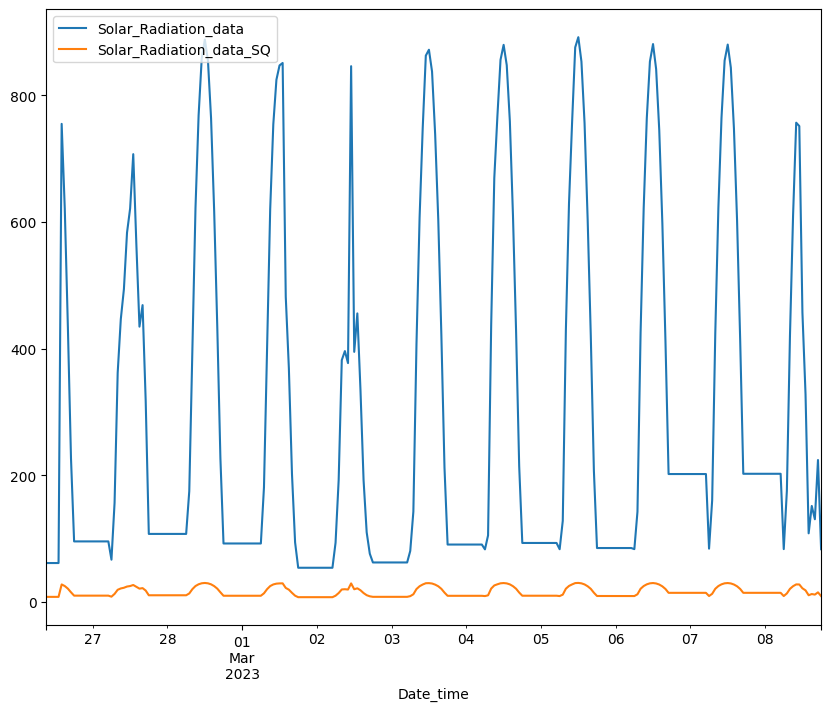

In [136]:
dfinput1.plot()

<Axes: xlabel='Date_time'>

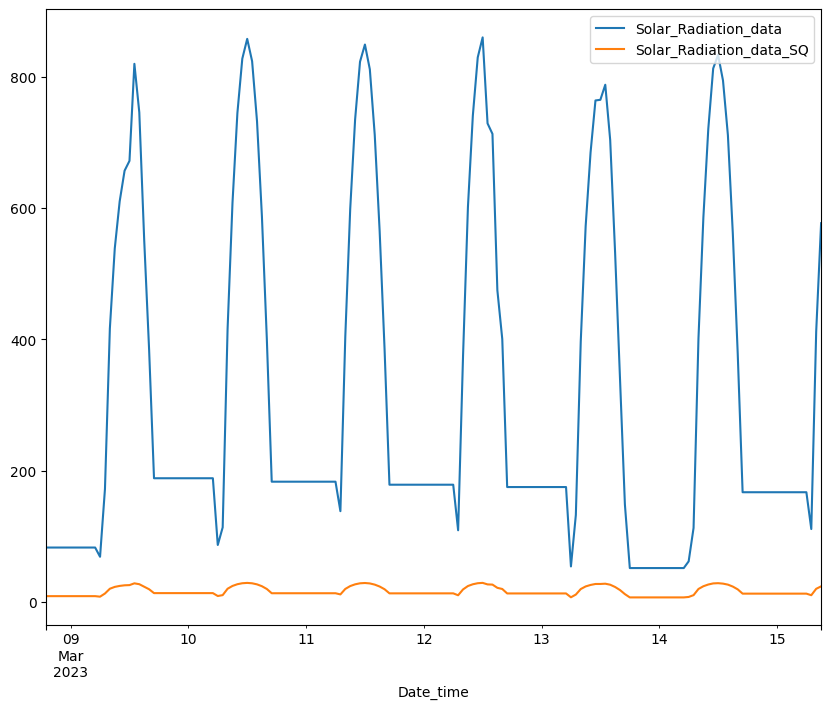

In [137]:
org.plot()

In [138]:
from statsmodels.tsa.stattools import adfuller
def adf_test(series):
    result=adfuller(series)
    print('ADF Statistics: {}'.format(result[0]))
    print('p- value: {}'.format(result[1]))
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [139]:
adf_test(dfinput1['Solar_Radiation_data_SQ'].dropna())

ADF Statistics: -4.20601630372973
p- value: 0.0006436183922544819
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


In [ ]:
## Use Techniques Differencing
dfinput1['Barometer_data_Difference']=dfinput1['Barometer_data']-dfinput1['Barometer_data'].shift(1)

In [ ]:
adf_test(dfinput1['Outside_Temperature_data_Difference'].dropna())

In [ ]:
## Use Techniques Differencing
#dfinput1['Outside_Temperature_data_2Difference']=dfinput1['Outside_Temperature_data']-dfinput1['Outside_Temperature_data'].shift(1)

In [ ]:
dfinput1['Outside_Temperature_data_Difference 12']=dfinput1['Outside_Temperature_data']-dfinput1['Outside_Temperature_data'].shift(12)

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


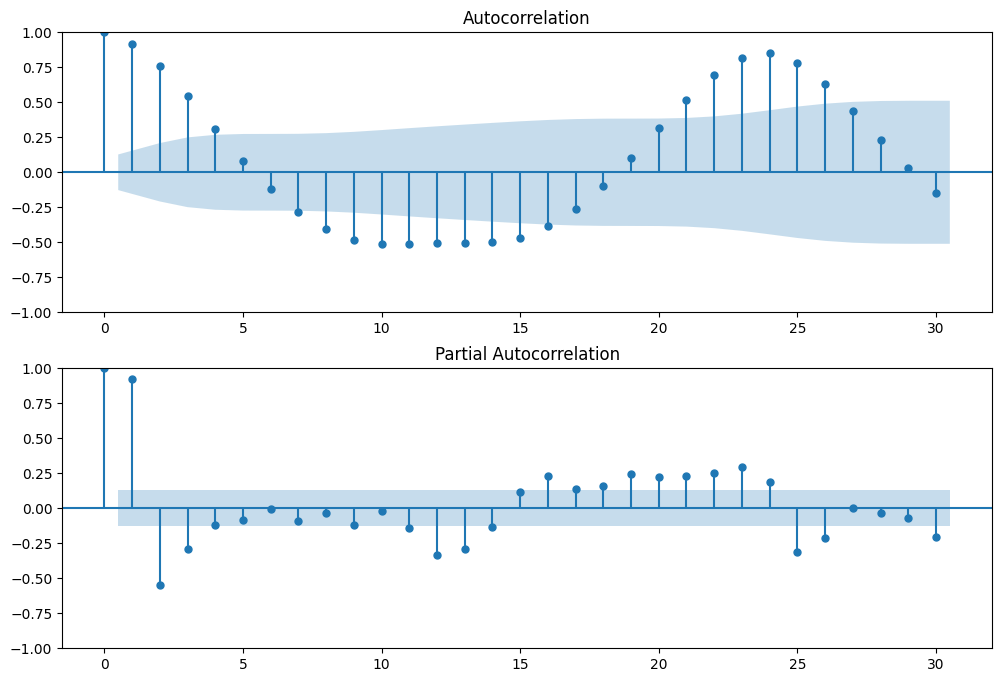

In [140]:
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(dfinput1['Solar_Radiation_data_SQ'].iloc[13:],lags=30,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(dfinput1['Solar_Radiation_data_SQ'].iloc[13:],lags=30,ax=ax2)

In [108]:
# Use auto_arima to select the optimal p and q values
import pmdarima as pm
model = pm.auto_arima(dfinput1['Solar_Radiation_data_SQ'], seasonal=True, m=24, start_p=2, start_q=2,
                      max_p=10, max_q=10, d=None, D=None, trace=True,
                      error_action='ignore', suppress_warnings=True,
                      stepwise=True)

# Get the selected p and q values
p, q = model.order[0], model.order[2]

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[24] intercept   : AIC=1140.145, Time=7.15 sec
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=1718.036, Time=0.05 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=1147.650, Time=2.51 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=1352.172, Time=0.72 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=2134.540, Time=0.02 sec
 ARIMA(2,0,2)(0,0,1)[24] intercept   : AIC=1174.182, Time=3.30 sec
 ARIMA(2,0,2)(1,0,0)[24] intercept   : AIC=1151.586, Time=3.66 sec
 ARIMA(2,0,2)(2,0,1)[24] intercept   : AIC=inf, Time=15.47 sec
 ARIMA(2,0,2)(1,0,2)[24] intercept   : AIC=1141.580, Time=17.53 sec
 ARIMA(2,0,2)(0,0,0)[24] intercept   : AIC=1207.907, Time=0.38 sec
 ARIMA(2,0,2)(0,0,2)[24] intercept   : AIC=1160.896, Time=10.56 sec
 ARIMA(2,0,2)(2,0,0)[24] intercept   : AIC=1145.517, Time=12.72 sec
 ARIMA(2,0,2)(2,0,2)[24] intercept   : AIC=1143.317, Time=20.48 sec
 ARIMA(1,0,2)(1,0,1)[24] intercept   : AIC=1139.957, Time=2.27 sec
 ARIMA(1,0,2)(0,0,1

In [141]:
model=sm.tsa.statespace.SARIMAX(dfinput1['Solar_Radiation_data_SQ'],order=(2,0,1),seasonal_order=(1,0,1,24))
results=model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<ipython-input-142-5a09e8c3a941>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfinput1['forecast']=results.predict(start=80,dynamic=True)


<Axes: xlabel='Date_time'>

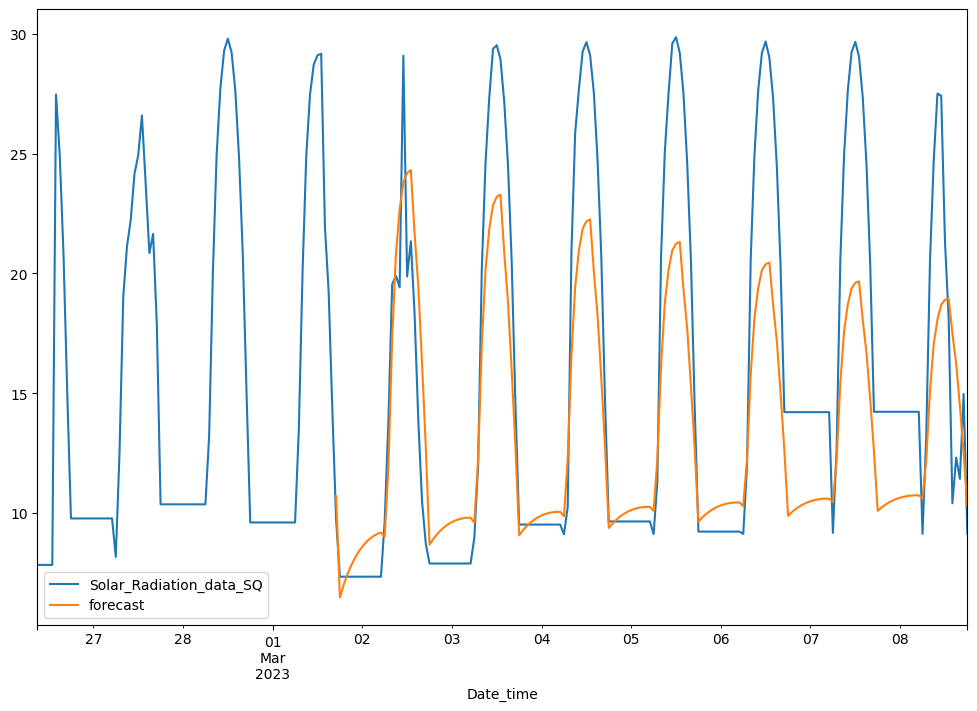

In [142]:
dfinput1['forecast']=results.predict(start=80,dynamic=True)
dfinput1[['Solar_Radiation_data_SQ','forecast']].plot(figsize=(12,8))

In [143]:
# Predict the next 6 hours of data
forecast =results.forecast(steps=100)
# Print the forecasted values
print(forecast)

2023-03-08 19:00:00     9.694412
2023-03-08 20:00:00    10.191204
2023-03-08 21:00:00    10.619054
2023-03-08 22:00:00    10.987513
2023-03-08 23:00:00    11.304808
                         ...    
2023-03-12 18:00:00    11.993426
2023-03-12 19:00:00    12.188026
2023-03-12 20:00:00    12.355465
2023-03-12 21:00:00    12.499506
2023-03-12 22:00:00    12.623389
Freq: H, Name: predicted_mean, Length: 100, dtype: float64


In [144]:
org

Solar_Radiation_data  Solar_Radiation_data_SQ
Date_time                                                         
2023-03-08 19:00:00             83.130435                 9.117589
2023-03-08 20:00:00             83.130435                 9.117589
2023-03-08 21:00:00             83.130435                 9.117589
2023-03-08 22:00:00             83.130435                 9.117589
2023-03-08 23:00:00             83.130435                 9.117589
...                                   ...                      ...
2023-03-15 05:00:00            167.333333                12.935739
2023-03-15 06:00:00            167.333333                12.935739
2023-03-15 07:00:00            111.300000                10.549882
2023-03-15 08:00:00            412.016667                20.298194
2023-03-15 09:00:00            577.000000                24.020824

[159 rows x 2 columns]

In [145]:
import pandas as pd
y_test = pd.DataFrame(forecast)
#y_test= pd.Data_Frame(forecast,colunms=["Y_test"])
y_test.to_csv("sarimax.csv")

In [146]:
org.to_csv("sarimaxt.csv")

In [147]:
# Generate the dates for the next 6 hours
last_hour = dfinput1.index[-1]
future_dates = pd.date_range(last_hour, periods=10, freq='H')

# Predict the next 6 hours of data
forecast = results.forecast(steps=10)

# Combine the forecasted values and the future dates into a new DataFrame
forecast_df = pd.DataFrame(forecast, index=future_dates, columns=['predicted_value'])

# Print the forecasted values and dates
print(forecast_df)

                    predicted_value
2023-03-08 18:00:00             NaN
2023-03-08 19:00:00             NaN
2023-03-08 20:00:00             NaN
2023-03-08 21:00:00             NaN
2023-03-08 22:00:00             NaN
2023-03-08 23:00:00             NaN
2023-03-09 00:00:00             NaN
2023-03-09 01:00:00             NaN
2023-03-09 02:00:00             NaN
2023-03-09 03:00:00             NaN


In [148]:
df_merged4 = pd.merge(y_test, org['Solar_Radiation_data_SQ'], left_index=True, right_index=True)
df_merged4

predicted_mean  Solar_Radiation_data_SQ
2023-03-08 19:00:00        9.694412                 9.117589
2023-03-08 20:00:00       10.191204                 9.117589
2023-03-08 21:00:00       10.619054                 9.117589
2023-03-08 22:00:00       10.987513                 9.117589
2023-03-08 23:00:00       11.304808                 9.117589
...                             ...                      ...
2023-03-12 18:00:00       11.993426                13.237374
2023-03-12 19:00:00       12.188026                13.237374
2023-03-12 20:00:00       12.355465                13.237374
2023-03-12 21:00:00       12.499506                13.237374
2023-03-12 22:00:00       12.623389                13.237374

[100 rows x 2 columns]

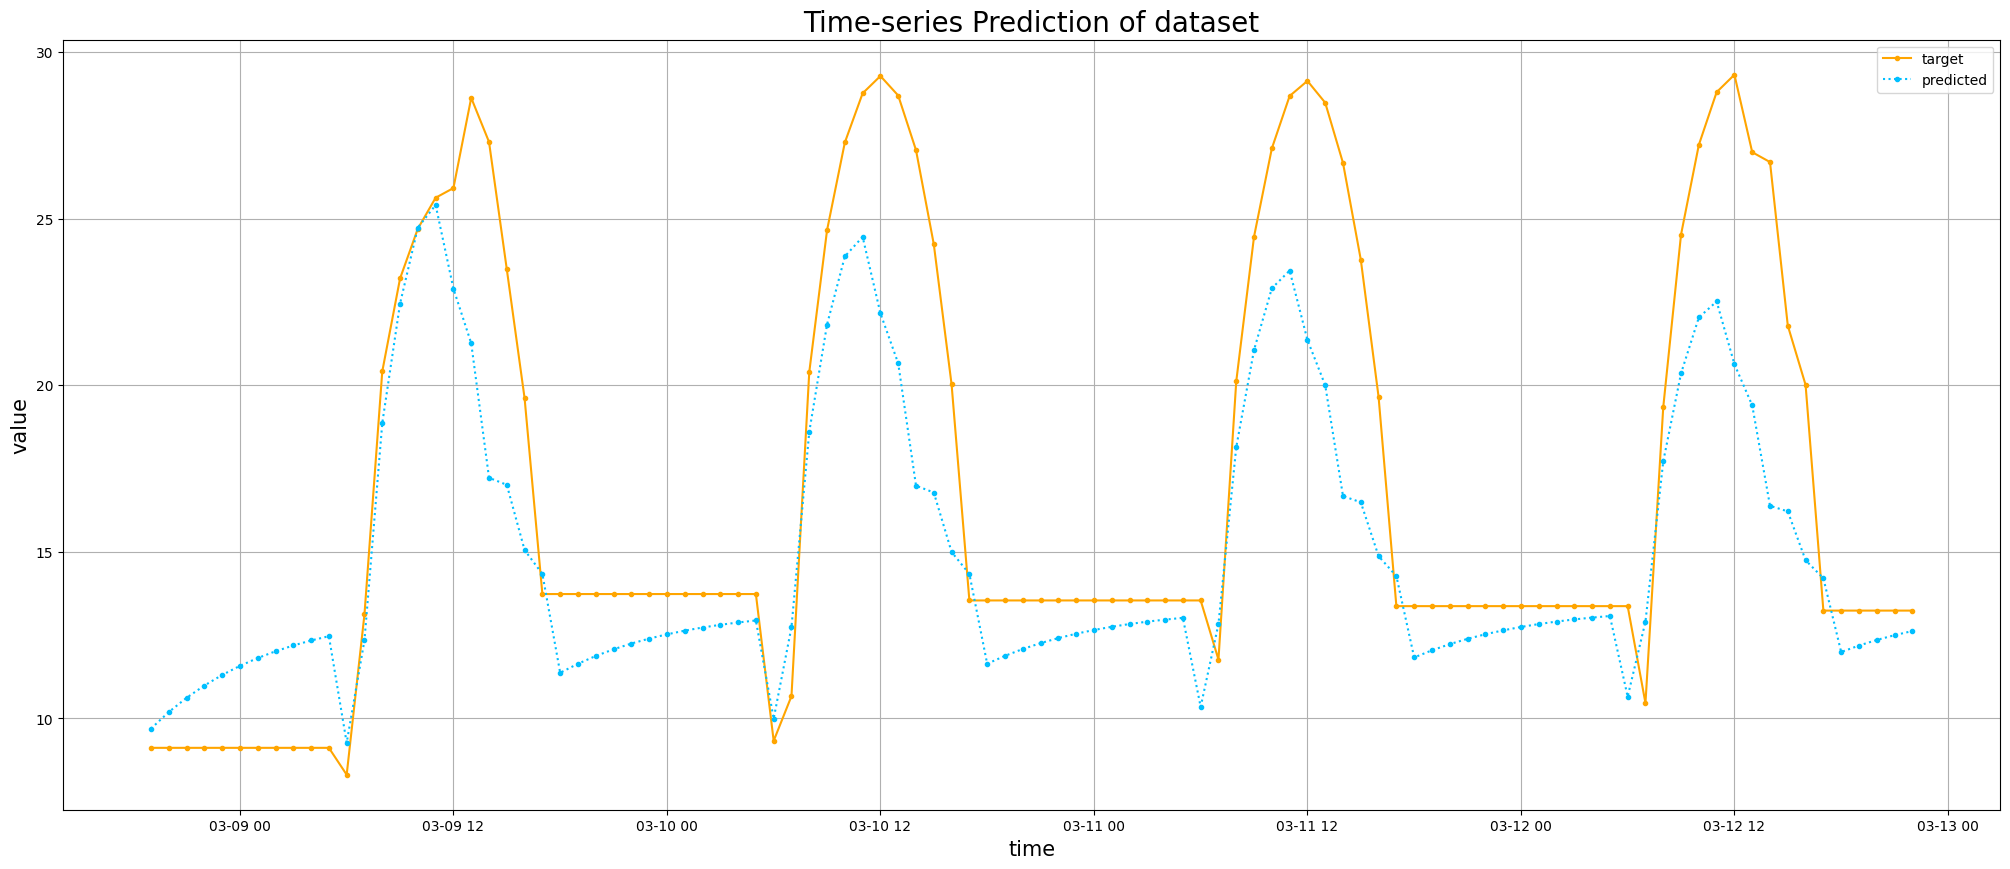

In [149]:
plt.figure(figsize=(25,10))
targetPlot,=plt.plot(df_merged4.Solar_Radiation_data_SQ,label='target',color='orange',marker='.',linestyle='-')
predictedPlot,=plt.plot(df_merged4.predicted_mean,label='predicted',color='deepskyblue',marker='.',linestyle=':')
plt.ylabel('value',fontsize=15)
plt.xlabel('time',fontsize=15)
plt.ion()
plt.grid()
plt.legend(handles=[targetPlot, predictedPlot])
plt.title('Time-series Prediction of dataset',fontsize=20,fontweight=40)
plt.draw()
plt.show()
plt.pause(0)


In [150]:
df_merged4

predicted_mean  Solar_Radiation_data_SQ
2023-03-08 19:00:00        9.694412                 9.117589
2023-03-08 20:00:00       10.191204                 9.117589
2023-03-08 21:00:00       10.619054                 9.117589
2023-03-08 22:00:00       10.987513                 9.117589
2023-03-08 23:00:00       11.304808                 9.117589
...                             ...                      ...
2023-03-12 18:00:00       11.993426                13.237374
2023-03-12 19:00:00       12.188026                13.237374
2023-03-12 20:00:00       12.355465                13.237374
2023-03-12 21:00:00       12.499506                13.237374
2023-03-12 22:00:00       12.623389                13.237374

[100 rows x 2 columns]

In [ ]:
df_merged3= df_merged3.drop('Barometer_data', axis=1)
df_input_model3 = df_merged3.rename(columns={'predicted_mean': 'Barometer_data'})
df_input_model3

In [151]:
import pandas as pd

import pandas as pd
# Rename a column
df_merged4= df_merged4.drop('Solar_Radiation_data_SQ', axis=1)
df_input_model4 = df_merged4.rename(columns={'predicted_mean': 'Solar_Radiation_data_SQ'})
df_input_model4



Solar_Radiation_data_SQ
2023-03-08 19:00:00                 9.694412
2023-03-08 20:00:00                10.191204
2023-03-08 21:00:00                10.619054
2023-03-08 22:00:00                10.987513
2023-03-08 23:00:00                11.304808
...                                      ...
2023-03-12 18:00:00                11.993426
2023-03-12 19:00:00                12.188026
2023-03-12 20:00:00                12.355465
2023-03-12 21:00:00                12.499506
2023-03-12 22:00:00                12.623389

[100 rows x 1 columns]

In [152]:
df_input_model = pd.concat([df_input_model, df_input_model4], axis=1)


Outside_Temperature_datap  TS1_SENS0700_TmpMdul_C_data  \
2023-03-08 19:00:00                  28.652229                    32.961904   
2023-03-08 20:00:00                  29.129358                    35.041448   
2023-03-08 21:00:00                  29.483779                    36.262734   
2023-03-08 22:00:00                  29.752213                    37.422303   
2023-03-08 23:00:00                  29.937931                    38.319186   
...                                        ...                          ...   
2023-03-12 18:00:00                  28.385338                    33.689767   
2023-03-12 19:00:00                  28.570044                    34.716321   
2023-03-12 20:00:00                  28.722899                    35.882323   
2023-03-12 21:00:00                  28.853979                    36.519246   
2023-03-12 22:00:00                  28.970189                    37.166788   

                     Barometer_data  Solar_Radiation_data_SQ  
2023-03-08 19:00:00     1011.000000                 9.694412  
2023-03-08 20:00:00     1010.998046                10.191204  
2023-03-08 21:00:00     1010.984692                10.619054  
2023-03-08 22:00:00     1010.968732                10.987513  
2023-03-08 23:00:00     1010.960915                11.304808  
...                             ...                      ...  
2023-03-12 18:00:00     1006.569456                11.993426  
2023-03-12 19:00:00     1006.569456                12.188026  
2023-03-12 20:00:00     1006.568058                12.355465  
2023-03-12 21:00:00     1006.558503                12.499506  
2023-03-12 22:00:00     1006.547085                12.623389  

[100 rows x 4 columns]

In [153]:
df_input_model.to_csv("WW.csv")

**Outside_Humidity_data**
---

In [154]:
df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'TS1_SENS0700_TmpMdul_C_data',
       'Barometer_data', 'Outside_Humidity_data', 'Outside_Temperature_data',
       'Solar_Radiation_data', 'TS1_P1_data', 'Wx', 'Wy', 'Date', 'Time',
       'Date_time_name', 'Day sin', 'Day cos', 'Year sin', 'Year cos'],
      dtype='object')

In [155]:
dfinput =df[['Outside_Humidity_data']]

In [156]:
dfinput.shape

(415006, 1)

<Axes: xlabel='Date_time'>

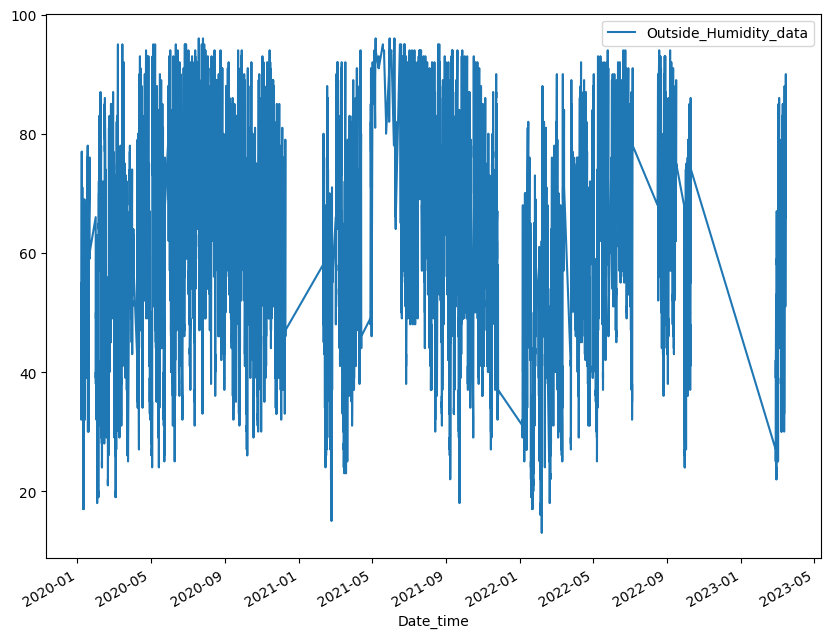

In [157]:
dfinput.plot()

In [158]:
data_hourly = dfinput.resample('H').mean().ffill()
data_hourly

Outside_Humidity_data
Date_time                                 
2020-01-07 13:00:00              34.891892
2020-01-07 14:00:00              34.866667
2020-01-07 15:00:00              36.433333
2020-01-07 16:00:00              44.800000
2020-01-07 17:00:00              51.716667
...                                    ...
2023-03-15 05:00:00              59.456140
2023-03-15 06:00:00              59.456140
2023-03-15 07:00:00              89.460000
2023-03-15 08:00:00              80.133333
2023-03-15 09:00:00              71.708333

[27909 rows x 1 columns]

In [159]:
data_hourly=data_hourly[27300:]
data_hourly.shape

(609, 1)

In [160]:
data_hourly=data_hourly[200:]
data_hourly.shape

(409, 1)

In [161]:
data_hourly

Outside_Humidity_data
Date_time                                 
2023-02-26 09:00:00              71.458333
2023-02-26 10:00:00              71.458333
2023-02-26 11:00:00              71.458333
2023-02-26 12:00:00              71.458333
2023-02-26 13:00:00              71.458333
...                                    ...
2023-03-15 05:00:00              59.456140
2023-03-15 06:00:00              59.456140
2023-03-15 07:00:00              89.460000
2023-03-15 08:00:00              80.133333
2023-03-15 09:00:00              71.708333

[409 rows x 1 columns]

<Axes: xlabel='Date_time'>

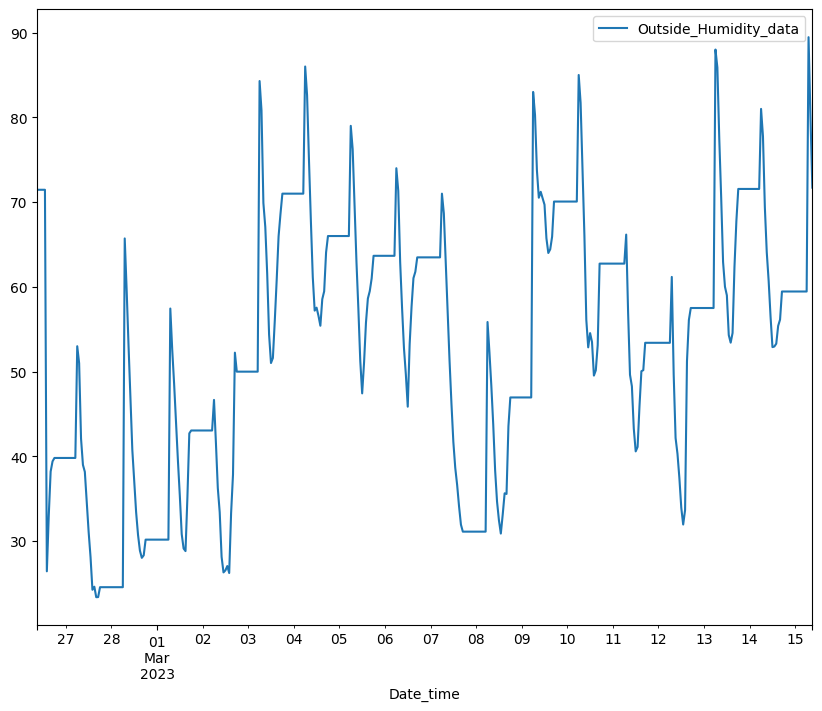

In [162]:
data_hourly.plot()

In [163]:
data_hourly.agg(['skew', 'kurtosis']).transpose()

skew  kurtosis
Outside_Humidity_data -0.206471  -0.81742

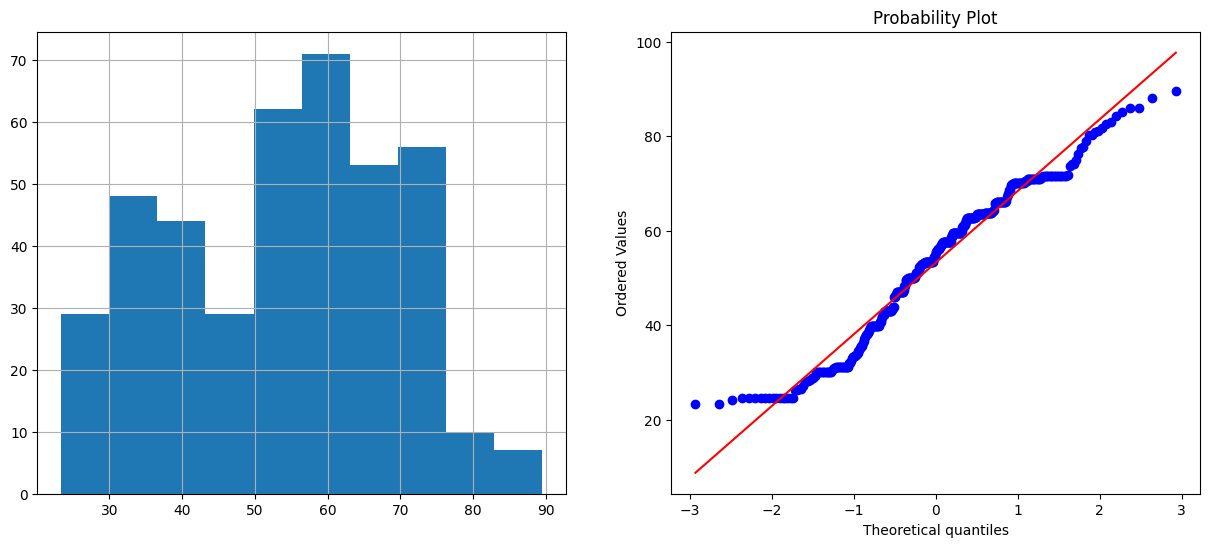

In [164]:
import scipy.stats as stats
def diagnostic_plots(df, variable):
    # function to plot a histogram and a Q-Q plot
    # side by side, for a certain variable
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    df[variable].hist()
    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.show()
diagnostic_plots(data_hourly,'Outside_Humidity_data')

In [165]:
dfinput1=data_hourly[:250]
dfinput1

Outside_Humidity_data
Date_time                                 
2023-02-26 09:00:00              71.458333
2023-02-26 10:00:00              71.458333
2023-02-26 11:00:00              71.458333
2023-02-26 12:00:00              71.458333
2023-02-26 13:00:00              71.458333
...                                    ...
2023-03-08 14:00:00              33.155172
2023-03-08 15:00:00              35.650000
2023-03-08 16:00:00              35.574074
2023-03-08 17:00:00              43.551724
2023-03-08 18:00:00              46.956522

[250 rows x 1 columns]

In [166]:
org=data_hourly[250:]
org

Outside_Humidity_data
Date_time                                 
2023-03-08 19:00:00              46.956522
2023-03-08 20:00:00              46.956522
2023-03-08 21:00:00              46.956522
2023-03-08 22:00:00              46.956522
2023-03-08 23:00:00              46.956522
...                                    ...
2023-03-15 05:00:00              59.456140
2023-03-15 06:00:00              59.456140
2023-03-15 07:00:00              89.460000
2023-03-15 08:00:00              80.133333
2023-03-15 09:00:00              71.708333

[159 rows x 1 columns]

In [167]:
dfinput1.shape

(250, 1)

<Axes: xlabel='Date_time'>

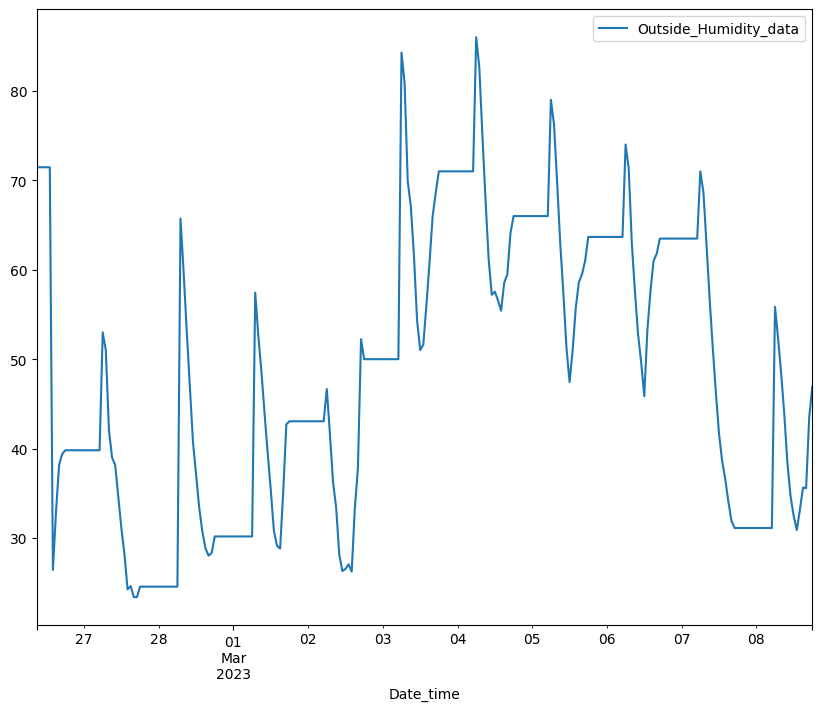

In [168]:
dfinput1.plot()

<Axes: xlabel='Date_time'>

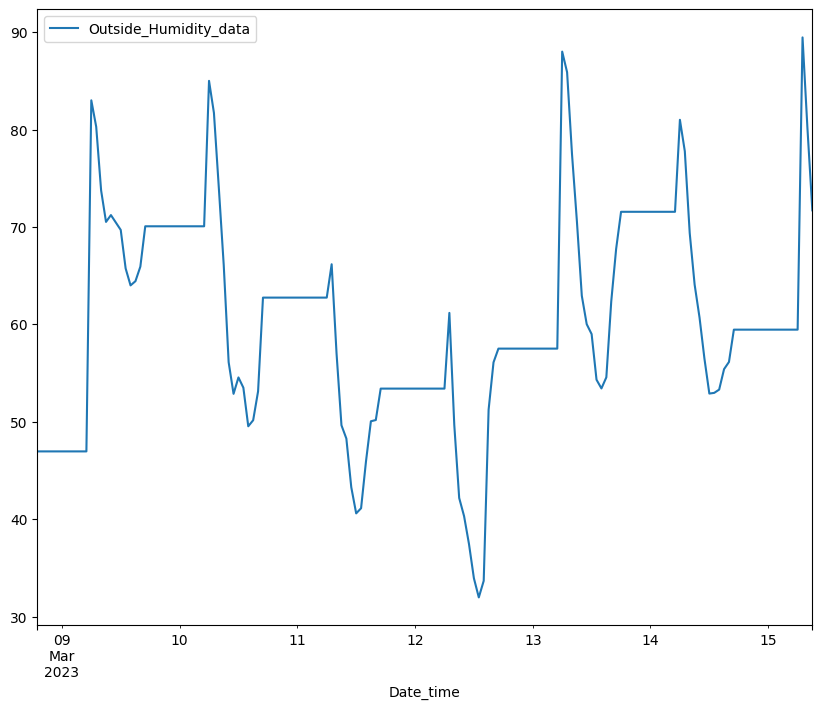

In [169]:
org.plot()

In [170]:
from statsmodels.tsa.stattools import adfuller
def adf_test(series):
    result=adfuller(series)
    print('ADF Statistics: {}'.format(result[0]))
    print('p- value: {}'.format(result[1]))
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [171]:
adf_test(dfinput1['Outside_Humidity_data'].dropna())

ADF Statistics: -3.4754142578562246
p- value: 0.008641419410093637
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


In [ ]:
## Use Techniques Differencing
dfinput1['Barometer_data_Difference']=dfinput1['Barometer_data']-dfinput1['Barometer_data'].shift(1)

In [ ]:
adf_test(dfinput1['Outside_Temperature_data_Difference'].dropna())

In [ ]:
## Use Techniques Differencing
#dfinput1['Outside_Temperature_data_2Difference']=dfinput1['Outside_Temperature_data']-dfinput1['Outside_Temperature_data'].shift(1)

In [ ]:
dfinput1['Outside_Temperature_data_Difference 12']=dfinput1['Outside_Temperature_data']-dfinput1['Outside_Temperature_data'].shift(12)

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


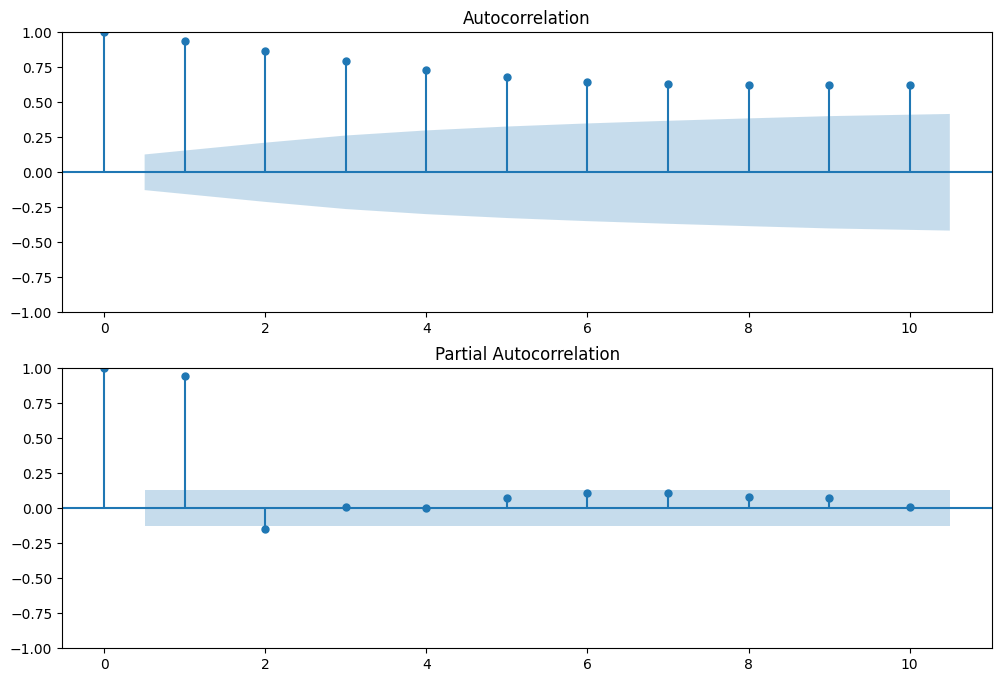

In [172]:
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(dfinput1['Outside_Humidity_data'].iloc[13:],lags=10,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(dfinput1['Outside_Humidity_data'].iloc[13:],lags=10,ax=ax2)

In [212]:
# Use auto_arima to select the optimal p and q values
import pmdarima as pm
model = pm.auto_arima(dfinput1['Outside_Humidity_data'], seasonal=True, m=12, start_p=2, start_q=2,
                      max_p=10, max_q=10, d=1, D=None, trace=True,
                      error_action='ignore', suppress_warnings=True,
                      stepwise=True)

# Get the selected p and q values
p, q = model.order[0], model.order[2]

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=1595.145, Time=2.71 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1614.045, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1617.195, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1617.186, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1612.109, Time=0.02 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=1611.297, Time=1.41 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=1611.274, Time=1.55 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=inf, Time=4.74 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=inf, Time=3.83 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=1609.313, Time=0.57 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=inf, Time=2.97 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=inf, Time=3.40 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=inf, Time=4.94 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=1593.467, Time=1.52 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=1

In [173]:
model=sm.tsa.statespace.SARIMAX(dfinput1['Outside_Humidity_data'],order=(1,1,1),seasonal_order=(2,0,2,24))
results=model.fit()

<ipython-input-174-e52397d8779f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfinput1['forecast']=results.predict(start=80,dynamic=True)


<Axes: xlabel='Date_time'>

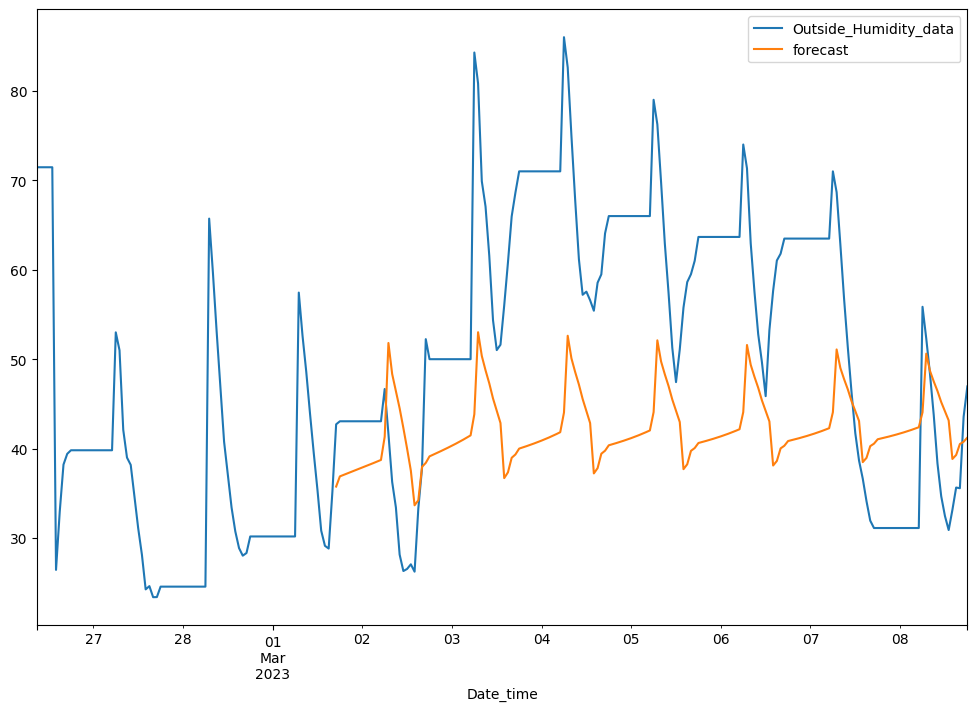

In [174]:
dfinput1['forecast']=results.predict(start=80,dynamic=True)
dfinput1[['Outside_Humidity_data','forecast']].plot(figsize=(12,8))

In [175]:
# Predict the next 6 hours of data
forecast =results.forecast(steps=100)
# Print the forecasted values
print(forecast)

2023-03-08 19:00:00    46.611910
2023-03-08 20:00:00    46.289878
2023-03-08 21:00:00    45.989186
2023-03-08 22:00:00    45.708676
2023-03-08 23:00:00    45.447269
                         ...    
2023-03-12 18:00:00    51.242045
2023-03-12 19:00:00    51.183954
2023-03-12 20:00:00    51.131319
2023-03-12 21:00:00    51.083937
2023-03-12 22:00:00    51.041627
Freq: H, Name: predicted_mean, Length: 100, dtype: float64


In [176]:
org

Outside_Humidity_data
Date_time                                 
2023-03-08 19:00:00              46.956522
2023-03-08 20:00:00              46.956522
2023-03-08 21:00:00              46.956522
2023-03-08 22:00:00              46.956522
2023-03-08 23:00:00              46.956522
...                                    ...
2023-03-15 05:00:00              59.456140
2023-03-15 06:00:00              59.456140
2023-03-15 07:00:00              89.460000
2023-03-15 08:00:00              80.133333
2023-03-15 09:00:00              71.708333

[159 rows x 1 columns]

In [177]:
import pandas as pd
y_test = pd.DataFrame(forecast)
#y_test= pd.Data_Frame(forecast,colunms=["Y_test"])
y_test.to_csv("sarimax.csv")

In [178]:
org.to_csv("sarimaxt.csv")

In [179]:
# Generate the dates for the next 6 hours
last_hour = dfinput1.index[-1]
future_dates = pd.date_range(last_hour, periods=10, freq='H')

# Predict the next 6 hours of data
forecast = results.forecast(steps=10)

# Combine the forecasted values and the future dates into a new DataFrame
forecast_df = pd.DataFrame(forecast, index=future_dates, columns=['predicted_value'])

# Print the forecasted values and dates
print(forecast_df)

                    predicted_value
2023-03-08 18:00:00             NaN
2023-03-08 19:00:00             NaN
2023-03-08 20:00:00             NaN
2023-03-08 21:00:00             NaN
2023-03-08 22:00:00             NaN
2023-03-08 23:00:00             NaN
2023-03-09 00:00:00             NaN
2023-03-09 01:00:00             NaN
2023-03-09 02:00:00             NaN
2023-03-09 03:00:00             NaN


In [180]:
df_merged5 = pd.merge(y_test, org['Outside_Humidity_data'], left_index=True, right_index=True)
df_merged5

predicted_mean  Outside_Humidity_data
2023-03-08 19:00:00       46.611910              46.956522
2023-03-08 20:00:00       46.289878              46.956522
2023-03-08 21:00:00       45.989186              46.956522
2023-03-08 22:00:00       45.708676              46.956522
2023-03-08 23:00:00       45.447269              46.956522
...                             ...                    ...
2023-03-12 18:00:00       51.242045              57.508772
2023-03-12 19:00:00       51.183954              57.508772
2023-03-12 20:00:00       51.131319              57.508772
2023-03-12 21:00:00       51.083937              57.508772
2023-03-12 22:00:00       51.041627              57.508772

[100 rows x 2 columns]

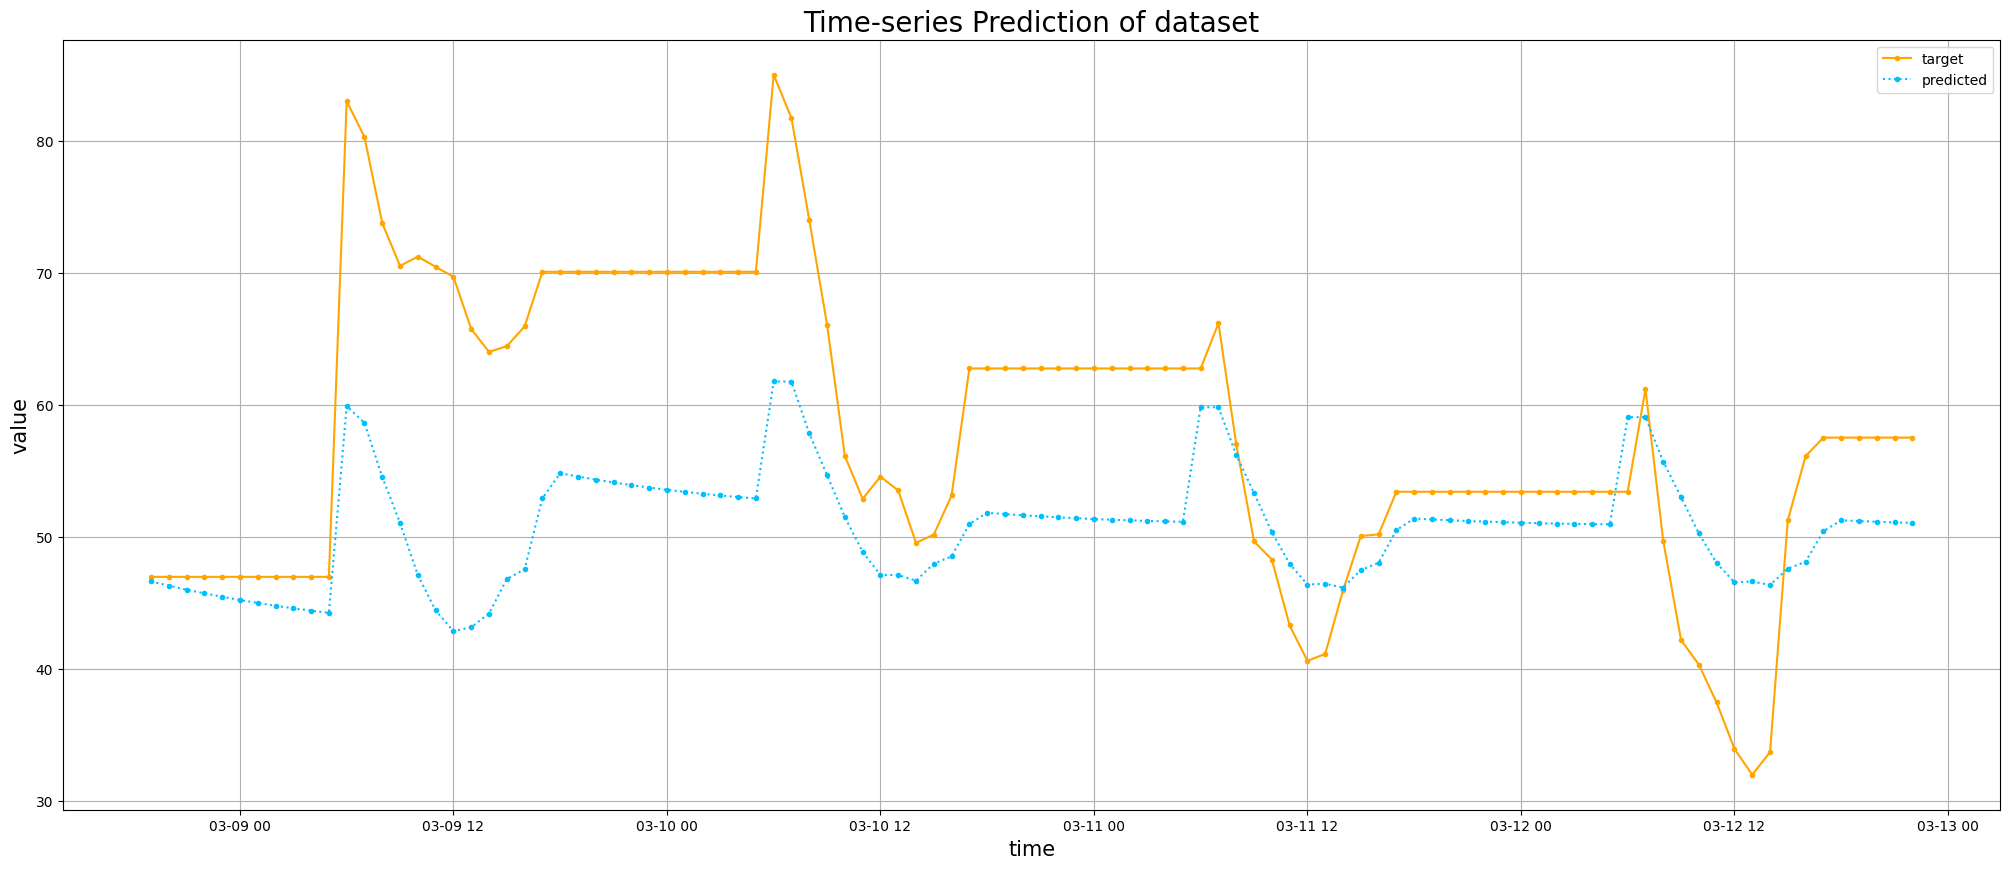

In [181]:
plt.figure(figsize=(25,10))
targetPlot,=plt.plot(df_merged5.Outside_Humidity_data,label='target',color='orange',marker='.',linestyle='-')
predictedPlot,=plt.plot(df_merged5.predicted_mean,label='predicted',color='deepskyblue',marker='.',linestyle=':')
plt.ylabel('value',fontsize=15)
plt.xlabel('time',fontsize=15)
plt.ion()
plt.grid()
plt.legend(handles=[targetPlot, predictedPlot])
plt.title('Time-series Prediction of dataset',fontsize=20,fontweight=40)
plt.draw()
plt.show()
plt.pause(0)


In [182]:
import pandas as pd

# Rename a column
df_merged5= df_merged5.drop('Outside_Humidity_data', axis=1)
df_input_model5 = df_merged5.rename(columns={'predicted_mean': 'Outside_Humidity_data'})
df_input_model5

Outside_Humidity_data
2023-03-08 19:00:00              46.611910
2023-03-08 20:00:00              46.289878
2023-03-08 21:00:00              45.989186
2023-03-08 22:00:00              45.708676
2023-03-08 23:00:00              45.447269
...                                    ...
2023-03-12 18:00:00              51.242045
2023-03-12 19:00:00              51.183954
2023-03-12 20:00:00              51.131319
2023-03-12 21:00:00              51.083937
2023-03-12 22:00:00              51.041627

[100 rows x 1 columns]

In [183]:
df_input_model = pd.concat([df_input_model, df_input_model5], axis=1)
df_input_model


Outside_Temperature_datap  TS1_SENS0700_TmpMdul_C_data  \
2023-03-08 19:00:00                  28.652229                    32.961904   
2023-03-08 20:00:00                  29.129358                    35.041448   
2023-03-08 21:00:00                  29.483779                    36.262734   
2023-03-08 22:00:00                  29.752213                    37.422303   
2023-03-08 23:00:00                  29.937931                    38.319186   
...                                        ...                          ...   
2023-03-12 18:00:00                  28.385338                    33.689767   
2023-03-12 19:00:00                  28.570044                    34.716321   
2023-03-12 20:00:00                  28.722899                    35.882323   
2023-03-12 21:00:00                  28.853979                    36.519246   
2023-03-12 22:00:00                  28.970189                    37.166788   

                     Barometer_data  Solar_Radiation_data_SQ  \
2023-03-08 19:00:00     1011.000000                 9.694412   
2023-03-08 20:00:00     1010.998046                10.191204   
2023-03-08 21:00:00     1010.984692                10.619054   
2023-03-08 22:00:00     1010.968732                10.987513   
2023-03-08 23:00:00     1010.960915                11.304808   
...                             ...                      ...   
2023-03-12 18:00:00     1006.569456                11.993426   
2023-03-12 19:00:00     1006.569456                12.188026   
2023-03-12 20:00:00     1006.568058                12.355465   
2023-03-12 21:00:00     1006.558503                12.499506   
2023-03-12 22:00:00     1006.547085                12.623389   

                     Outside_Humidity_data  
2023-03-08 19:00:00              46.611910  
2023-03-08 20:00:00              46.289878  
2023-03-08 21:00:00              45.989186  
2023-03-08 22:00:00              45.708676  
2023-03-08 23:00:00              45.447269  
...                                    ...  
2023-03-12 18:00:00              51.242045  
2023-03-12 19:00:00              51.183954  
2023-03-12 20:00:00              51.131319  
2023-03-12 21:00:00              51.083937  
2023-03-12 22:00:00              51.041627  

[100 rows x 5 columns]

**Wx**
---

In [184]:
df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'TS1_SENS0700_TmpMdul_C_data',
       'Barometer_data', 'Outside_Humidity_data', 'Outside_Temperature_data',
       'Solar_Radiation_data', 'TS1_P1_data', 'Wx', 'Wy', 'Date', 'Time',
       'Date_time_name', 'Day sin', 'Day cos', 'Year sin', 'Year cos'],
      dtype='object')

In [185]:
dfinput =df[['Wx']]

In [186]:
dfinput.shape

(415006, 1)

<Axes: xlabel='Date_time'>

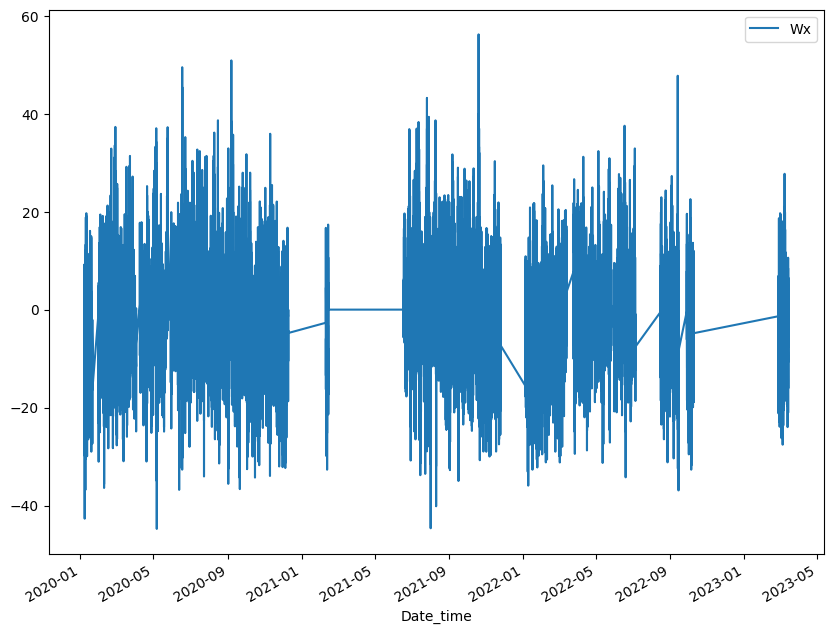

In [187]:
dfinput.plot()

In [188]:
data_hourly = dfinput.resample('H').mean().ffill()
data_hourly

Wx
Date_time                    
2020-01-07 13:00:00 -5.083273
2020-01-07 14:00:00 -5.791420
2020-01-07 15:00:00 -4.565166
2020-01-07 16:00:00 -4.573127
2020-01-07 17:00:00 -6.865746
...                       ...
2023-03-15 05:00:00 -6.701897
2023-03-15 06:00:00 -6.701897
2023-03-15 07:00:00 -0.539273
2023-03-15 08:00:00 -1.857948
2023-03-15 09:00:00 -0.889516

[27909 rows x 1 columns]

In [189]:
data_hourly=data_hourly[27300:]
data_hourly.shape

(609, 1)

In [190]:
data_hourly=data_hourly[200:]
data_hourly.shape

(409, 1)

In [191]:
data_hourly

Wx
Date_time                    
2023-02-26 09:00:00 -7.916614
2023-02-26 10:00:00 -7.916614
2023-02-26 11:00:00 -7.916614
2023-02-26 12:00:00 -7.916614
2023-02-26 13:00:00 -7.916614
...                       ...
2023-03-15 05:00:00 -6.701897
2023-03-15 06:00:00 -6.701897
2023-03-15 07:00:00 -0.539273
2023-03-15 08:00:00 -1.857948
2023-03-15 09:00:00 -0.889516

[409 rows x 1 columns]

<Axes: xlabel='Date_time'>

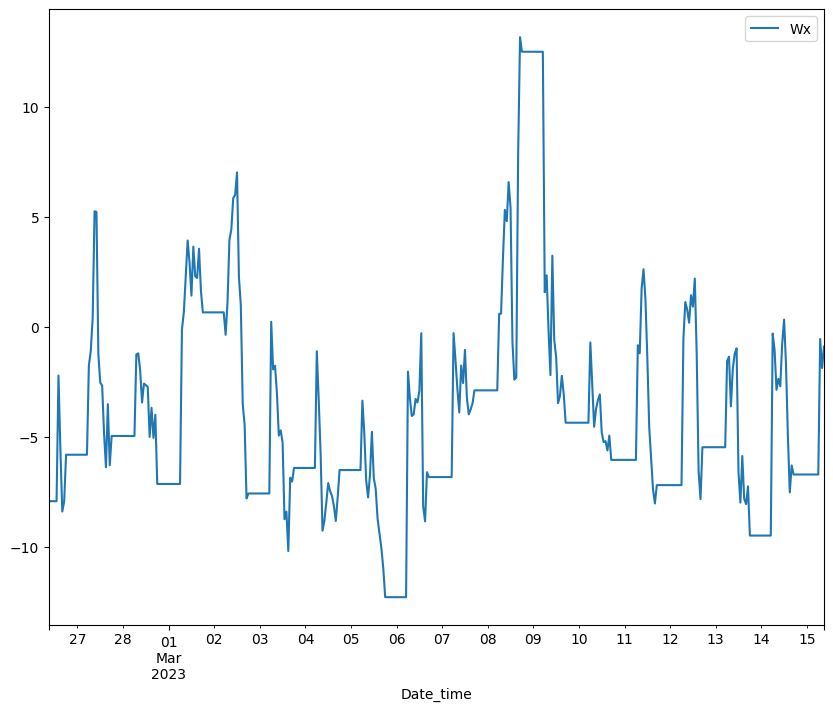

In [192]:
data_hourly.plot()

In [193]:
data_hourly.agg(['skew', 'kurtosis']).transpose()

skew  kurtosis
Wx  1.440596  2.849342

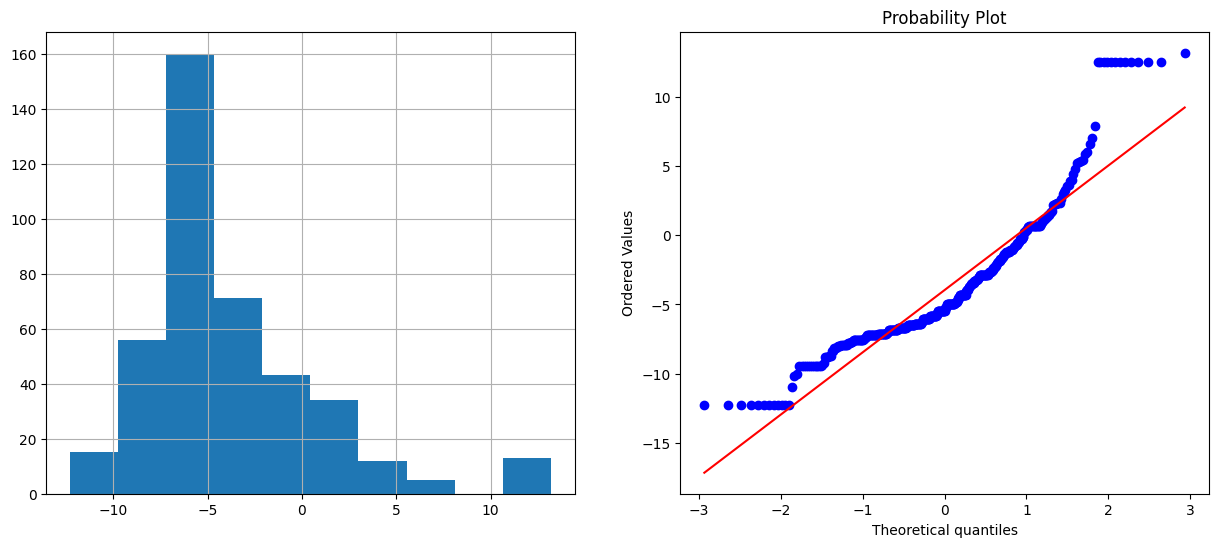

In [194]:
import scipy.stats as stats
def diagnostic_plots(df, variable):
    # function to plot a histogram and a Q-Q plot
    # side by side, for a certain variable
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    df[variable].hist()
    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.show()
diagnostic_plots(data_hourly,'Wx')

In [195]:
data_hourly

Wx
Date_time                    
2023-02-26 09:00:00 -7.916614
2023-02-26 10:00:00 -7.916614
2023-02-26 11:00:00 -7.916614
2023-02-26 12:00:00 -7.916614
2023-02-26 13:00:00 -7.916614
...                       ...
2023-03-15 05:00:00 -6.701897
2023-03-15 06:00:00 -6.701897
2023-03-15 07:00:00 -0.539273
2023-03-15 08:00:00 -1.857948
2023-03-15 09:00:00 -0.889516

[409 rows x 1 columns]

In [196]:
dfinput1=data_hourly[:250]
dfinput1

Wx
Date_time                     
2023-02-26 09:00:00  -7.916614
2023-02-26 10:00:00  -7.916614
2023-02-26 11:00:00  -7.916614
2023-02-26 12:00:00  -7.916614
2023-02-26 13:00:00  -7.916614
...                        ...
2023-03-08 14:00:00  -2.390456
2023-03-08 15:00:00  -2.296821
2023-03-08 16:00:00   7.890026
2023-03-08 17:00:00  13.181007
2023-03-08 18:00:00  12.518606

[250 rows x 1 columns]

In [197]:
org=data_hourly[250:]
org

Wx
Date_time                     
2023-03-08 19:00:00  12.518606
2023-03-08 20:00:00  12.518606
2023-03-08 21:00:00  12.518606
2023-03-08 22:00:00  12.518606
2023-03-08 23:00:00  12.518606
...                        ...
2023-03-15 05:00:00  -6.701897
2023-03-15 06:00:00  -6.701897
2023-03-15 07:00:00  -0.539273
2023-03-15 08:00:00  -1.857948
2023-03-15 09:00:00  -0.889516

[159 rows x 1 columns]

In [198]:
dfinput1.shape

(250, 1)

<Axes: xlabel='Date_time'>

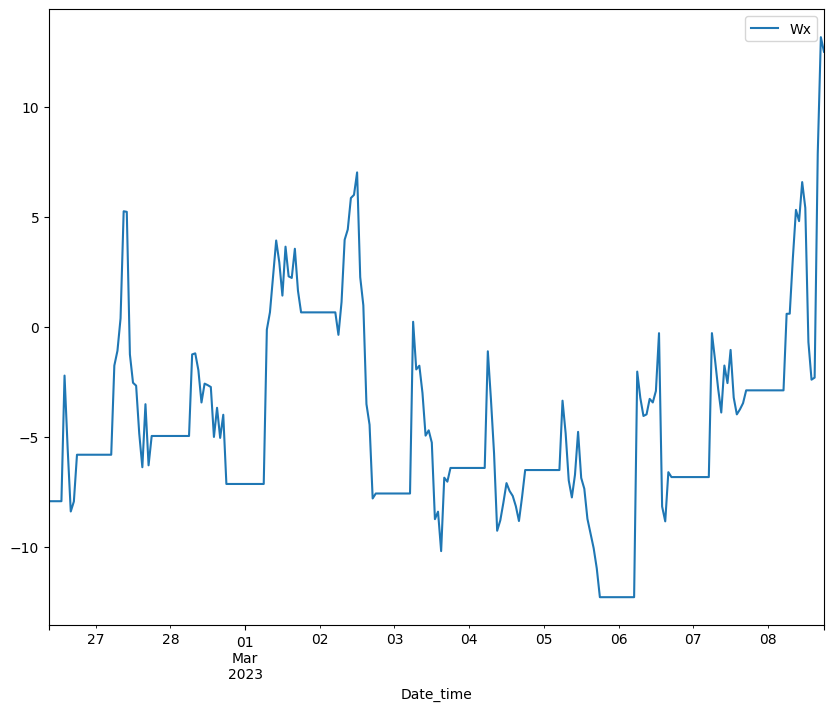

In [199]:
dfinput1.plot()

<Axes: xlabel='Date_time'>

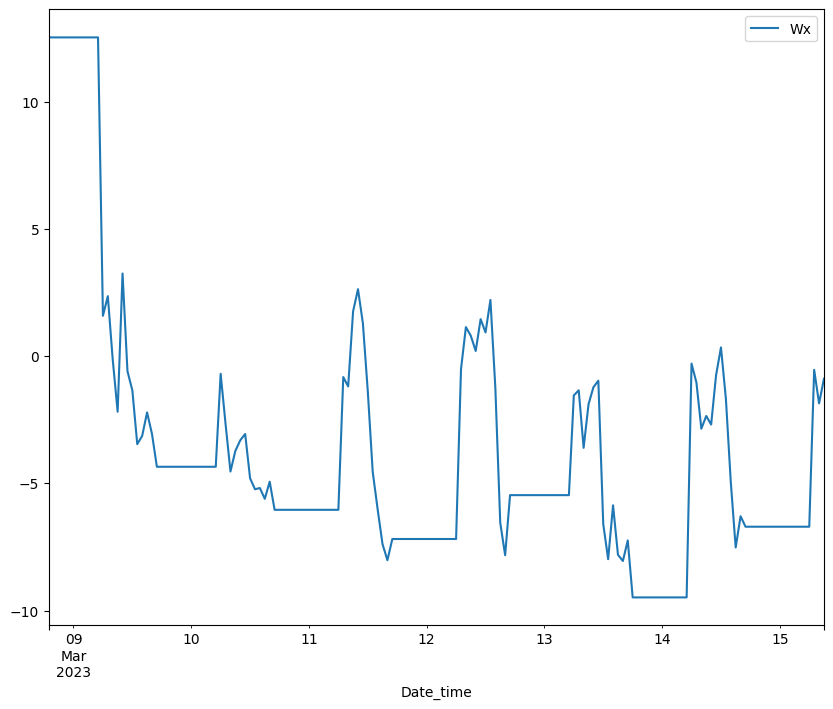

In [200]:
org.plot()

In [201]:
from statsmodels.tsa.stattools import adfuller
def adf_test(series):
    result=adfuller(series)
    print('ADF Statistics: {}'.format(result[0]))
    print('p- value: {}'.format(result[1]))
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [205]:
adf_test(dfinput1['Wx_Difference'].dropna())

ADF Statistics: -15.351678688789924
p- value: 3.7128796573695376e-28
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


In [204]:
## Use Techniques Differencing
dfinput1['Wx_Difference']=dfinput1['Wx']-dfinput1['Wx'].shift(1)

<ipython-input-204-f93216adb089>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfinput1['Wx_Difference']=dfinput1['Wx']-dfinput1['Wx'].shift(1)


In [ ]:
adf_test(dfinput1['Outside_Temperature_data_Difference'].dropna())

ADF Statistics: -9.778826863373409
p- value: 6.819546138935219e-17
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


In [ ]:
## Use Techniques Differencing
#dfinput1['Outside_Temperature_data_2Difference']=dfinput1['Outside_Temperature_data']-dfinput1['Outside_Temperature_data'].shift(1)

In [ ]:
dfinput1['Outside_Temperature_data_Difference 12']=dfinput1['Outside_Temperature_data']-dfinput1['Outside_Temperature_data'].shift(12)

<ipython-input-39-714533a69d3f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfinput1['Outside_Temperature_data_Difference 12']=dfinput1['Outside_Temperature_data']-dfinput1['Outside_Temperature_data'].shift(12)


/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


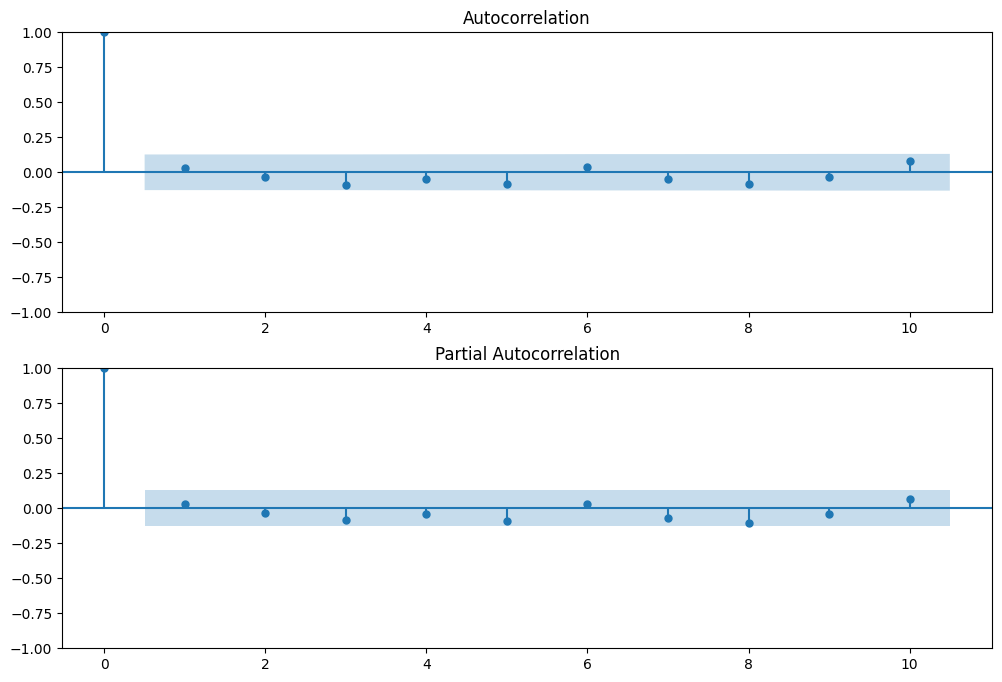

In [206]:
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(dfinput1['Wx_Difference'].iloc[13:],lags=10,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(dfinput1['Wx_Difference'].iloc[13:],lags=10,ax=ax2)

In [254]:
# Use auto_arima to select the optimal p and q values
import pmdarima as pm
model = pm.auto_arima(dfinput1['Wx'], seasonal=True, m=12, start_p=1, start_q=1,
                      max_p=10, max_q=10, d=1, D=None, trace=True,
                      error_action='ignore', suppress_warnings=True,
                      stepwise=True)

# Get the selected p and q values
p, q = model.order[0], model.order[2]

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=1051.303, Time=1.43 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1050.913, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1054.721, Time=0.26 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1054.737, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1049.341, Time=0.03 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=1052.844, Time=0.09 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=1052.870, Time=0.13 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=1047.467, Time=0.38 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=1036.747, Time=0.76 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=1035.209, Time=0.32 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=1037.204, Time=0.45 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=1037.203, Time=0.39 sec
 ARIMA(1,1,1)(2,0,0)[12] intercept   : AIC=1039.056, Time=1.25 sec
 ARIMA(0,1,0)(2,0,0)[12]             : AIC=1033.744, Time=0.12 sec
 ARIMA(0,1,0)(1,0,0

In [207]:
model=sm.tsa.statespace.SARIMAX(dfinput1['Wx'],order=(2,0,1),seasonal_order=(2,0,0,24))
results=model.fit()

<ipython-input-208-c28edf6b1ce7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfinput1['forecast']=results.predict(start=80,dynamic=True)


<Axes: xlabel='Date_time'>

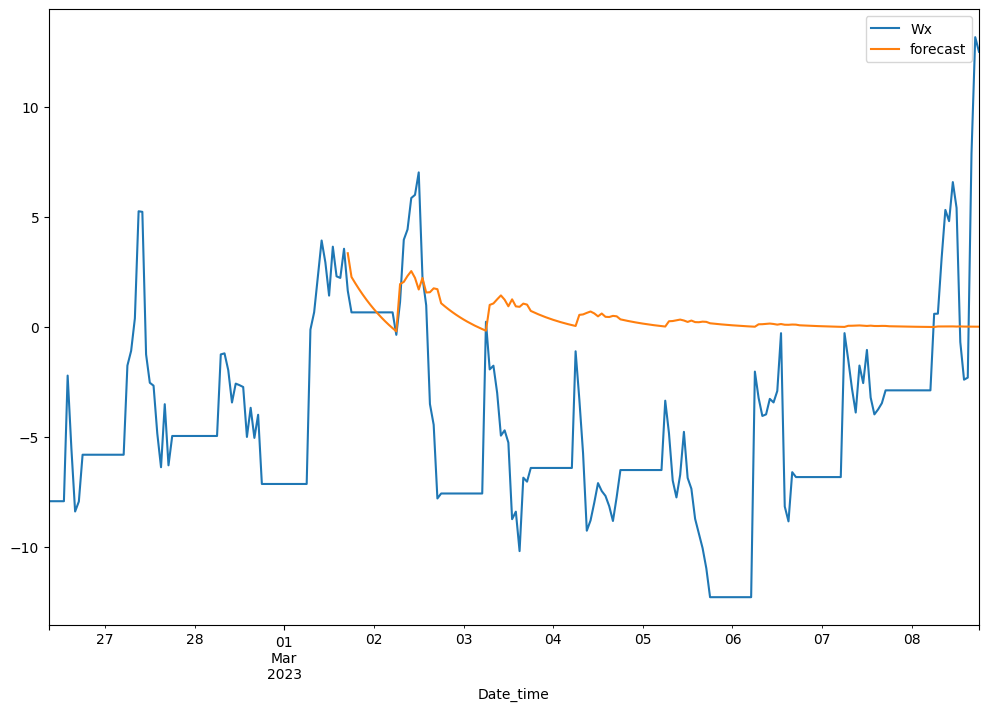

In [208]:
dfinput1['forecast']=results.predict(start=80,dynamic=True)
dfinput1[['Wx','forecast']].plot(figsize=(12,8))

In [209]:
# Predict the next 6 hours of data
forecast =results.forecast(steps=100)
# Print the forecasted values
print(forecast)

2023-03-08 19:00:00    11.659367
2023-03-08 20:00:00    10.876850
2023-03-08 21:00:00    10.136348
2023-03-08 22:00:00     9.441572
2023-03-08 23:00:00     8.788468
                         ...    
2023-03-12 18:00:00     0.815798
2023-03-12 19:00:00     0.762065
2023-03-12 20:00:00     0.712407
2023-03-12 21:00:00     0.665571
2023-03-12 22:00:00     0.621595
Freq: H, Name: predicted_mean, Length: 100, dtype: float64


In [210]:
org

Wx
Date_time                     
2023-03-08 19:00:00  12.518606
2023-03-08 20:00:00  12.518606
2023-03-08 21:00:00  12.518606
2023-03-08 22:00:00  12.518606
2023-03-08 23:00:00  12.518606
...                        ...
2023-03-15 05:00:00  -6.701897
2023-03-15 06:00:00  -6.701897
2023-03-15 07:00:00  -0.539273
2023-03-15 08:00:00  -1.857948
2023-03-15 09:00:00  -0.889516

[159 rows x 1 columns]

In [211]:
import pandas as pd
y_test = pd.DataFrame(forecast)
#y_test= pd.Data_Frame(forecast,colunms=["Y_test"])
y_test.to_csv("sarimax.csv")

In [212]:
org.to_csv("sarimaxt.csv")

In [213]:
# Generate the dates for the next 6 hours
last_hour = dfinput1.index[-1]
future_dates = pd.date_range(last_hour, periods=10, freq='H')

# Predict the next 6 hours of data
forecast = results.forecast(steps=10)

# Combine the forecasted values and the future dates into a new DataFrame
forecast_df = pd.DataFrame(forecast, index=future_dates, columns=['predicted_value'])

# Print the forecasted values and dates
print(forecast_df)

                    predicted_value
2023-03-08 18:00:00             NaN
2023-03-08 19:00:00             NaN
2023-03-08 20:00:00             NaN
2023-03-08 21:00:00             NaN
2023-03-08 22:00:00             NaN
2023-03-08 23:00:00             NaN
2023-03-09 00:00:00             NaN
2023-03-09 01:00:00             NaN
2023-03-09 02:00:00             NaN
2023-03-09 03:00:00             NaN


In [214]:
df_merged6 = pd.merge(y_test, org['Wx'], left_index=True, right_index=True)

In [215]:
df_merged6

predicted_mean         Wx
2023-03-08 19:00:00       11.659367  12.518606
2023-03-08 20:00:00       10.876850  12.518606
2023-03-08 21:00:00       10.136348  12.518606
2023-03-08 22:00:00        9.441572  12.518606
2023-03-08 23:00:00        8.788468  12.518606
...                             ...        ...
2023-03-12 18:00:00        0.815798  -5.462063
2023-03-12 19:00:00        0.762065  -5.462063
2023-03-12 20:00:00        0.712407  -5.462063
2023-03-12 21:00:00        0.665571  -5.462063
2023-03-12 22:00:00        0.621595  -5.462063

[100 rows x 2 columns]

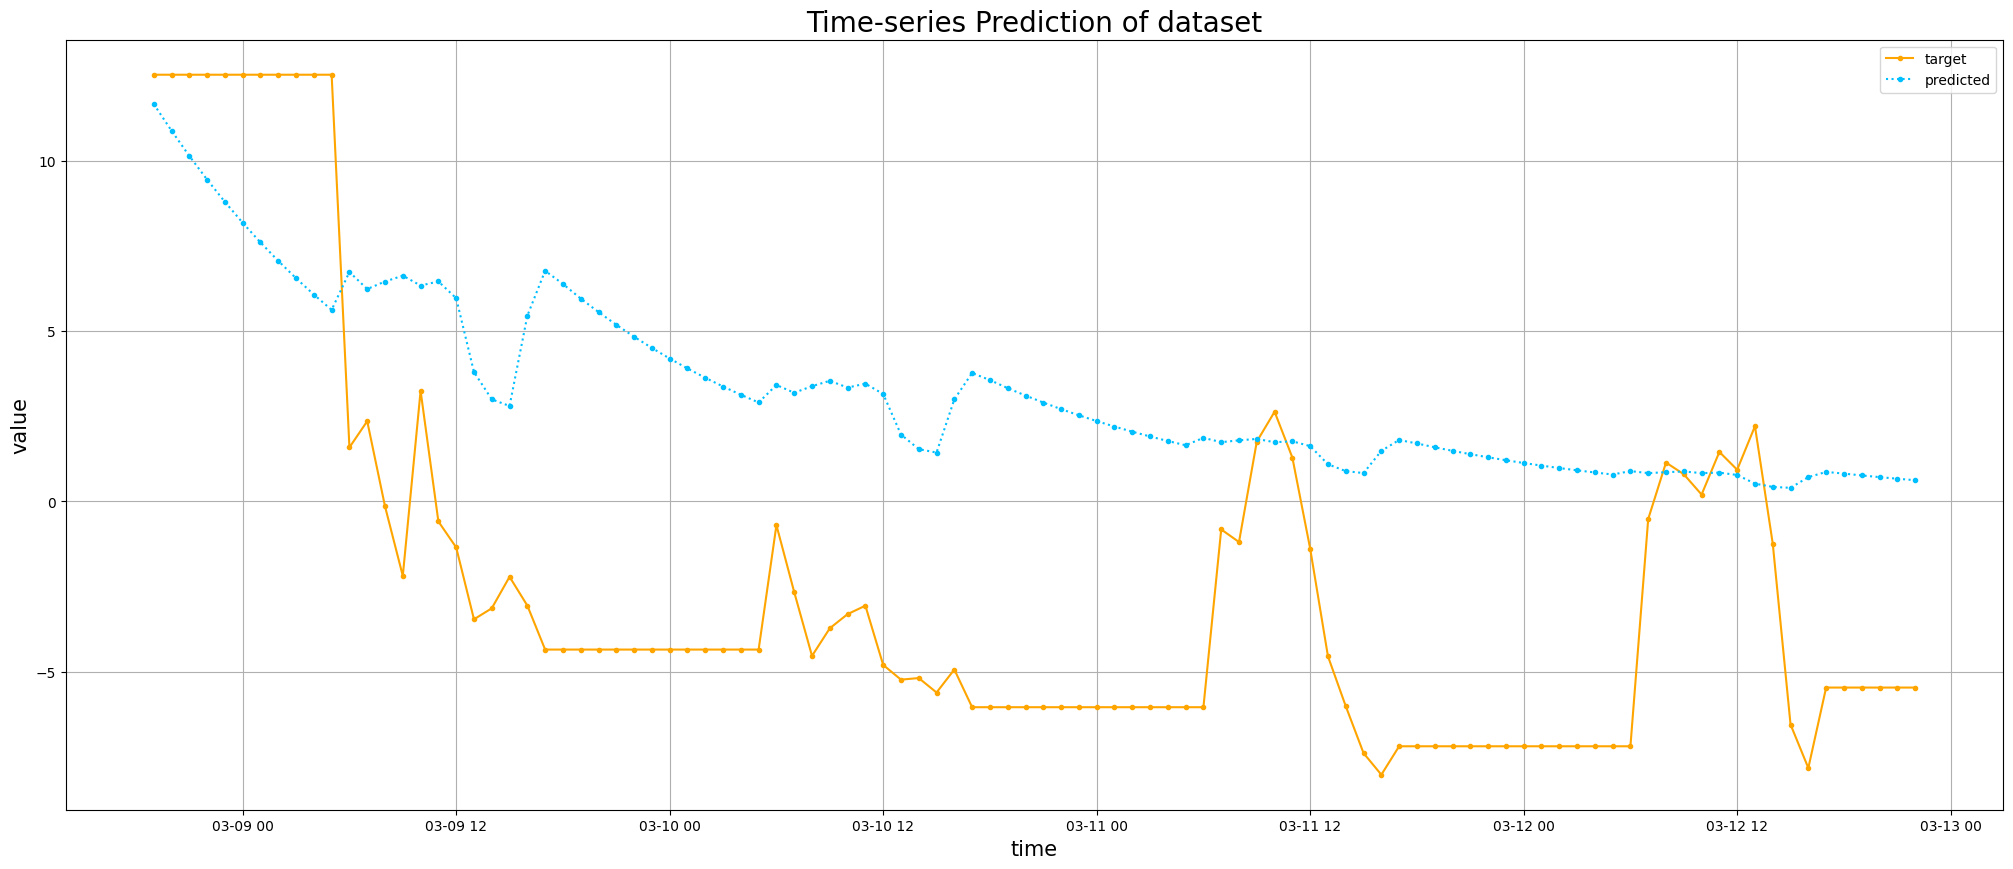

In [216]:
plt.figure(figsize=(25,10))
targetPlot,=plt.plot(df_merged6.Wx,label='target',color='orange',marker='.',linestyle='-')
predictedPlot,=plt.plot(df_merged6.predicted_mean,label='predicted',color='deepskyblue',marker='.',linestyle=':')
plt.ylabel('value',fontsize=15)
plt.xlabel('time',fontsize=15)
plt.ion()
plt.grid()
plt.legend(handles=[targetPlot, predictedPlot])
plt.title('Time-series Prediction of dataset',fontsize=20,fontweight=40)
plt.draw()
plt.show()
plt.pause(0)

In [217]:
import pandas as pd
# Rename a column
df_merged6= df_merged6.drop('Wx', axis=1)
df_input_model6 = df_merged6.rename(columns={'predicted_mean': 'Wx'})
df_input_model6

Wx
2023-03-08 19:00:00  11.659367
2023-03-08 20:00:00  10.876850
2023-03-08 21:00:00  10.136348
2023-03-08 22:00:00   9.441572
2023-03-08 23:00:00   8.788468
...                        ...
2023-03-12 18:00:00   0.815798
2023-03-12 19:00:00   0.762065
2023-03-12 20:00:00   0.712407
2023-03-12 21:00:00   0.665571
2023-03-12 22:00:00   0.621595

[100 rows x 1 columns]

In [218]:
import pandas as pd
df_input_model = pd.concat([df_input_model, df_input_model6], axis=1)
df_input_model

Outside_Temperature_datap  TS1_SENS0700_TmpMdul_C_data  \
2023-03-08 19:00:00                  28.652229                    32.961904   
2023-03-08 20:00:00                  29.129358                    35.041448   
2023-03-08 21:00:00                  29.483779                    36.262734   
2023-03-08 22:00:00                  29.752213                    37.422303   
2023-03-08 23:00:00                  29.937931                    38.319186   
...                                        ...                          ...   
2023-03-12 18:00:00                  28.385338                    33.689767   
2023-03-12 19:00:00                  28.570044                    34.716321   
2023-03-12 20:00:00                  28.722899                    35.882323   
2023-03-12 21:00:00                  28.853979                    36.519246   
2023-03-12 22:00:00                  28.970189                    37.166788   

                     Barometer_data  Solar_Radiation_data_SQ  \
2023-03-08 19:00:00     1011.000000                 9.694412   
2023-03-08 20:00:00     1010.998046                10.191204   
2023-03-08 21:00:00     1010.984692                10.619054   
2023-03-08 22:00:00     1010.968732                10.987513   
2023-03-08 23:00:00     1010.960915                11.304808   
...                             ...                      ...   
2023-03-12 18:00:00     1006.569456                11.993426   
2023-03-12 19:00:00     1006.569456                12.188026   
2023-03-12 20:00:00     1006.568058                12.355465   
2023-03-12 21:00:00     1006.558503                12.499506   
2023-03-12 22:00:00     1006.547085                12.623389   

                     Outside_Humidity_data         Wx  
2023-03-08 19:00:00              46.611910  11.659367  
2023-03-08 20:00:00              46.289878  10.876850  
2023-03-08 21:00:00              45.989186  10.136348  
2023-03-08 22:00:00              45.708676   9.441572  
2023-03-08 23:00:00              45.447269   8.788468  
...                                    ...        ...  
2023-03-12 18:00:00              51.242045   0.815798  
2023-03-12 19:00:00              51.183954   0.762065  
2023-03-12 20:00:00              51.131319   0.712407  
2023-03-12 21:00:00              51.083937   0.665571  
2023-03-12 22:00:00              51.041627   0.621595  

[100 rows x 6 columns]

**Wy**
---

In [219]:
df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'TS1_SENS0700_TmpMdul_C_data',
       'Barometer_data', 'Outside_Humidity_data', 'Outside_Temperature_data',
       'Solar_Radiation_data', 'TS1_P1_data', 'Wx', 'Wy', 'Date', 'Time',
       'Date_time_name', 'Day sin', 'Day cos', 'Year sin', 'Year cos'],
      dtype='object')

In [220]:
dfinput =df[['Wy']]

In [221]:
dfinput.shape

(415006, 1)

<Axes: xlabel='Date_time'>

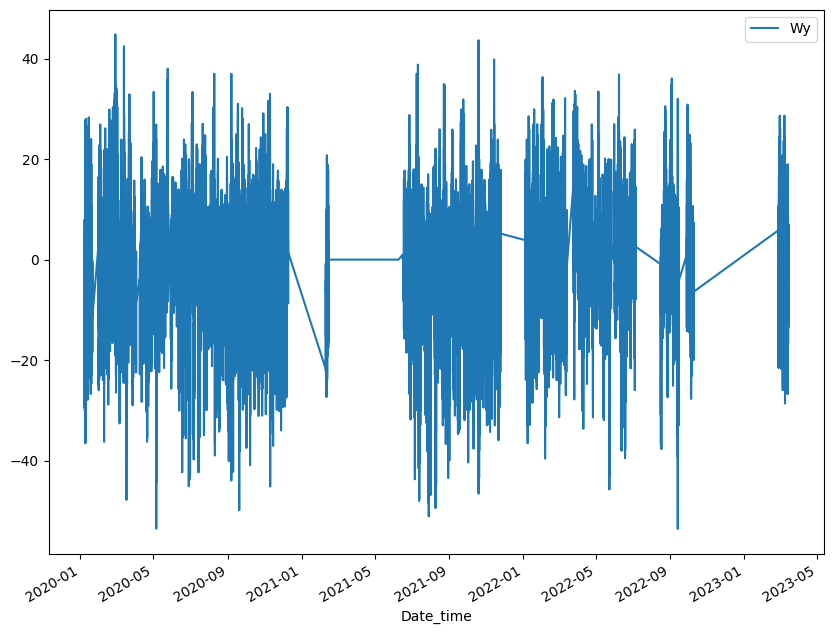

In [222]:
dfinput.plot()

In [223]:
data_hourly = dfinput.resample('H').mean().ffill()
data_hourly

Wy
Date_time                    
2020-01-07 13:00:00 -8.458526
2020-01-07 14:00:00 -8.207989
2020-01-07 15:00:00 -8.166763
2020-01-07 16:00:00 -8.736903
2020-01-07 17:00:00 -6.629465
...                       ...
2023-03-15 05:00:00 -6.403374
2023-03-15 06:00:00 -6.403374
2023-03-15 07:00:00  0.165845
2023-03-15 08:00:00  1.219804
2023-03-15 09:00:00  0.663165

[27909 rows x 1 columns]

In [224]:
data_hourly=data_hourly[27300:]
data_hourly.shape

(609, 1)

In [225]:
data_hourly=data_hourly[200:]
data_hourly.shape

(409, 1)

In [226]:
data_hourly

Wy
Date_time                    
2023-02-26 09:00:00 -6.086487
2023-02-26 10:00:00 -6.086487
2023-02-26 11:00:00 -6.086487
2023-02-26 12:00:00 -6.086487
2023-02-26 13:00:00 -6.086487
...                       ...
2023-03-15 05:00:00 -6.403374
2023-03-15 06:00:00 -6.403374
2023-03-15 07:00:00  0.165845
2023-03-15 08:00:00  1.219804
2023-03-15 09:00:00  0.663165

[409 rows x 1 columns]

<Axes: xlabel='Date_time'>

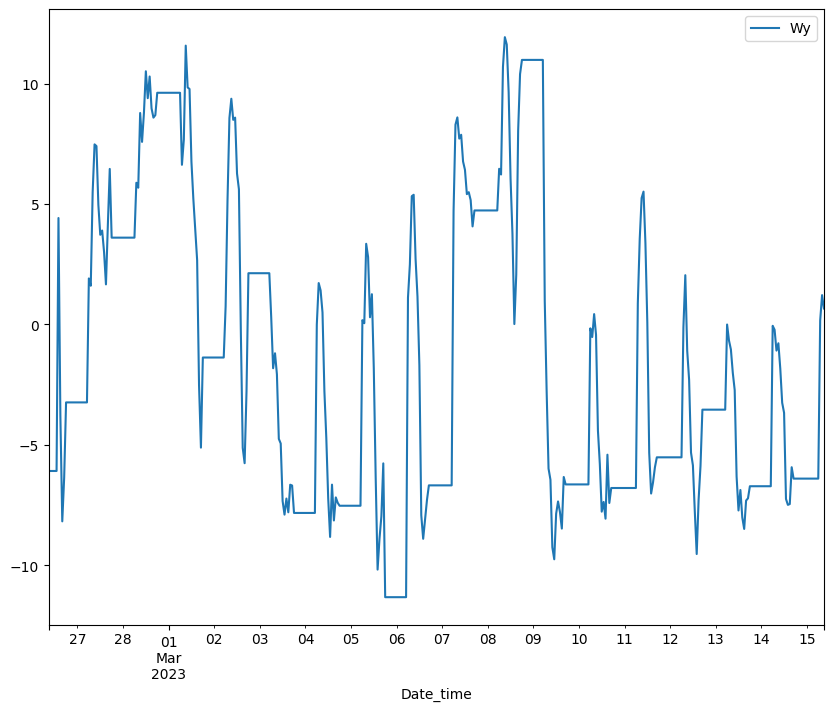

In [227]:
data_hourly.plot()

In [228]:
data_hourly.agg(['skew', 'kurtosis']).transpose()

skew  kurtosis
Wy  0.536402 -0.950867

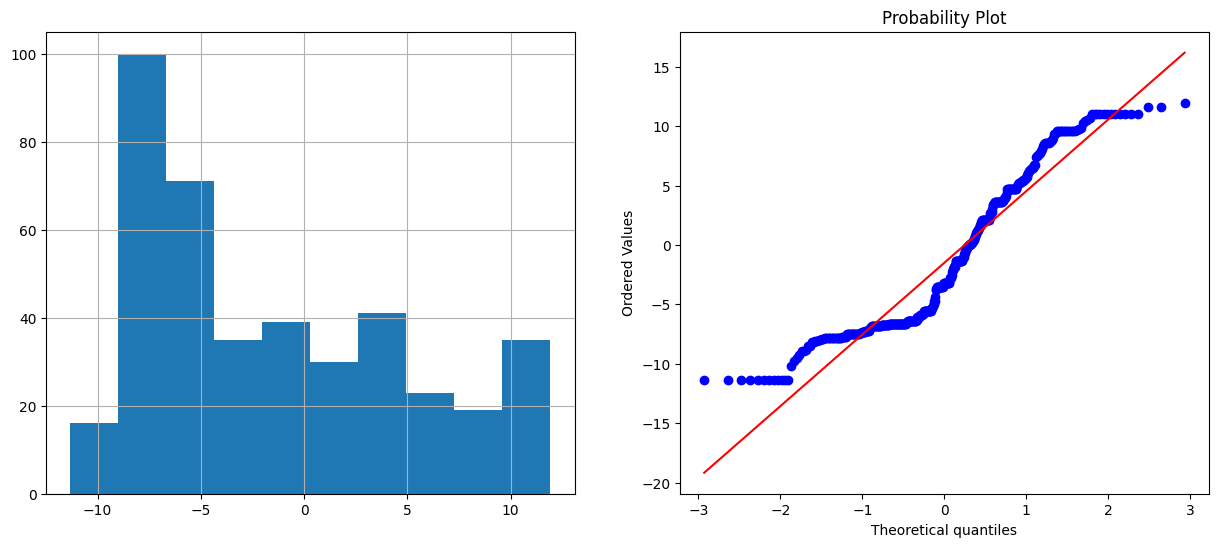

In [229]:
import scipy.stats as stats
def diagnostic_plots(df, variable):
    # function to plot a histogram and a Q-Q plot
    # side by side, for a certain variable
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    df[variable].hist()
    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.show()
diagnostic_plots(data_hourly,'Wy')

In [230]:
data_hourly

Wy
Date_time                    
2023-02-26 09:00:00 -6.086487
2023-02-26 10:00:00 -6.086487
2023-02-26 11:00:00 -6.086487
2023-02-26 12:00:00 -6.086487
2023-02-26 13:00:00 -6.086487
...                       ...
2023-03-15 05:00:00 -6.403374
2023-03-15 06:00:00 -6.403374
2023-03-15 07:00:00  0.165845
2023-03-15 08:00:00  1.219804
2023-03-15 09:00:00  0.663165

[409 rows x 1 columns]

In [231]:
dfinput1=data_hourly[:250]
dfinput1

Wy
Date_time                     
2023-02-26 09:00:00  -6.086487
2023-02-26 10:00:00  -6.086487
2023-02-26 11:00:00  -6.086487
2023-02-26 12:00:00  -6.086487
2023-02-26 13:00:00  -6.086487
...                        ...
2023-03-08 14:00:00   0.017437
2023-03-08 15:00:00   2.076950
2023-03-08 16:00:00   8.051057
2023-03-08 17:00:00  10.401553
2023-03-08 18:00:00  10.991593

[250 rows x 1 columns]

In [232]:
org=data_hourly[250:]
org

Wy
Date_time                     
2023-03-08 19:00:00  10.991593
2023-03-08 20:00:00  10.991593
2023-03-08 21:00:00  10.991593
2023-03-08 22:00:00  10.991593
2023-03-08 23:00:00  10.991593
...                        ...
2023-03-15 05:00:00  -6.403374
2023-03-15 06:00:00  -6.403374
2023-03-15 07:00:00   0.165845
2023-03-15 08:00:00   1.219804
2023-03-15 09:00:00   0.663165

[159 rows x 1 columns]

In [233]:
dfinput1.shape

(250, 1)

<Axes: xlabel='Date_time'>

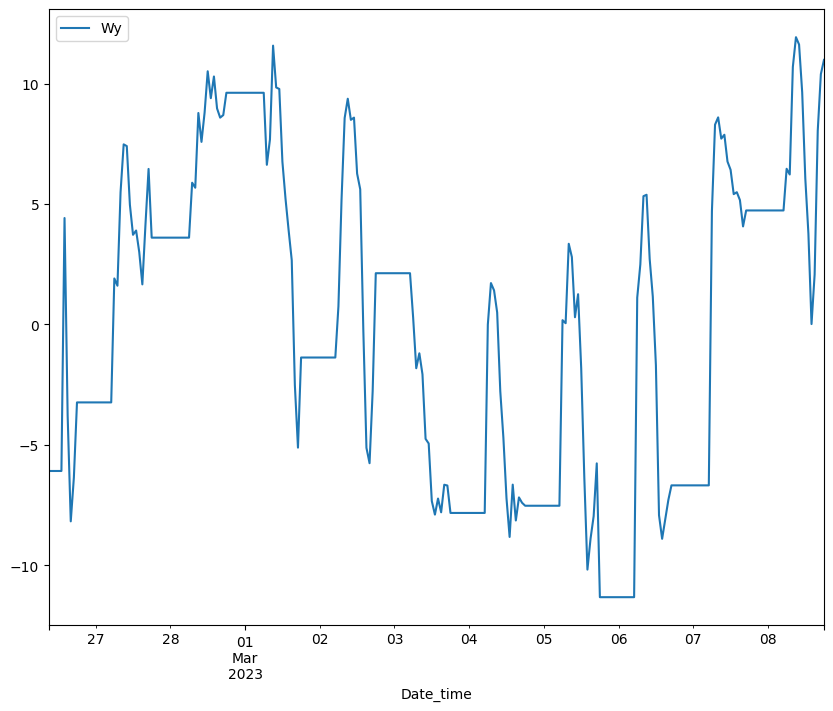

In [234]:
dfinput1.plot()

<Axes: xlabel='Date_time'>

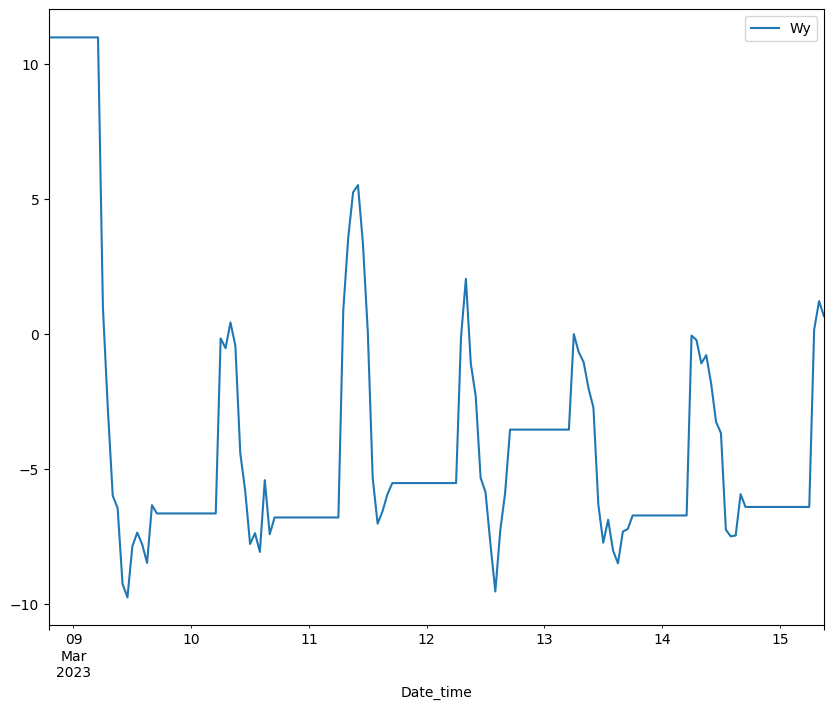

In [235]:
org.plot()

In [236]:
from statsmodels.tsa.stattools import adfuller
def adf_test(series):
    result=adfuller(series)
    print('ADF Statistics: {}'.format(result[0]))
    print('p- value: {}'.format(result[1]))
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [237]:
adf_test(dfinput1['Wy'].dropna())

ADF Statistics: -3.215731991859299
p- value: 0.019091919375255985
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


In [ ]:
## Use Techniques Differencing
dfinput1['Wx_Difference']=dfinput1['Wx']-dfinput1['Wx'].shift(1)

<ipython-input-250-f93216adb089>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfinput1['Wx_Difference']=dfinput1['Wx']-dfinput1['Wx'].shift(1)


In [ ]:
adf_test(dfinput1['Outside_Temperature_data_Difference'].dropna())

ADF Statistics: -9.778826863373409
p- value: 6.819546138935219e-17
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


In [ ]:
## Use Techniques Differencing
#dfinput1['Outside_Temperature_data_2Difference']=dfinput1['Outside_Temperature_data']-dfinput1['Outside_Temperature_data'].shift(1)

In [ ]:
dfinput1['Outside_Temperature_data_Difference 12']=dfinput1['Outside_Temperature_data']-dfinput1['Outside_Temperature_data'].shift(12)

<ipython-input-39-714533a69d3f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfinput1['Outside_Temperature_data_Difference 12']=dfinput1['Outside_Temperature_data']-dfinput1['Outside_Temperature_data'].shift(12)


/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


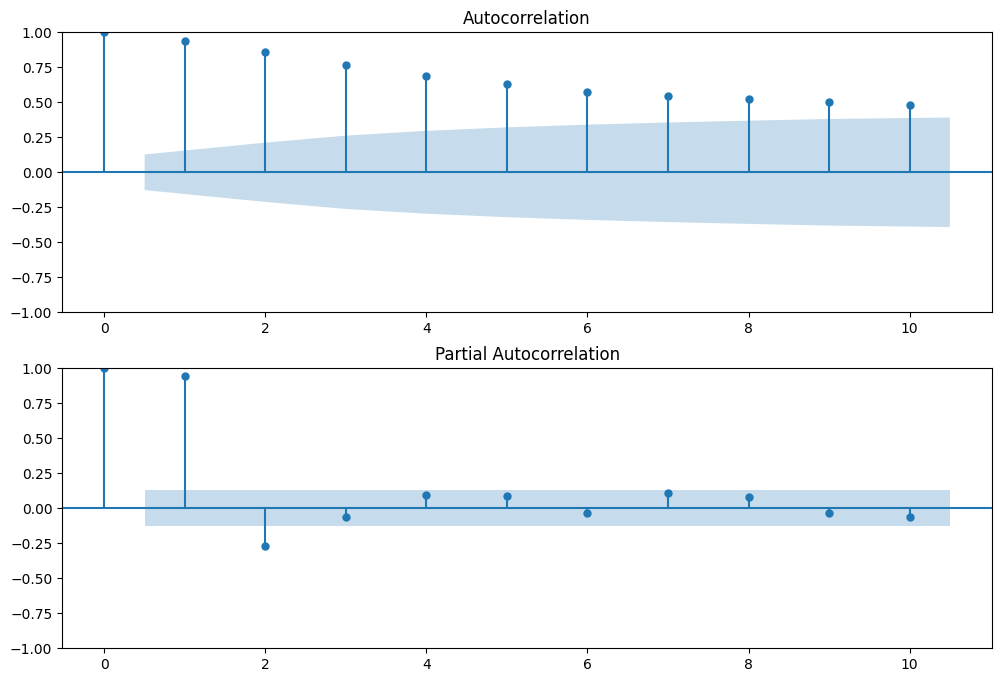

In [238]:
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(dfinput1['Wy'].iloc[13:],lags=10,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(dfinput1['Wy'].iloc[13:],lags=10,ax=ax2)

In [319]:
# Use auto_arima to select the optimal p and q values
import pmdarima as pm
model = pm.auto_arima(dfinput1['Wy'], seasonal=True, m=24, start_p=1, start_q=1,
                      max_p=10, max_q=10, d=1, D=None, trace=True,
                      error_action='ignore', suppress_warnings=True,
                      stepwise=True)

# Get the selected p and q values
p, q = model.order[0], model.order[2]

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[24] intercept   : AIC=1080.389, Time=2.23 sec
 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=1121.439, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=1087.347, Time=0.50 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=1096.471, Time=0.88 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=1119.664, Time=0.03 sec
 ARIMA(1,1,1)(0,0,1)[24] intercept   : AIC=1098.445, Time=1.01 sec
 ARIMA(1,1,1)(1,0,0)[24] intercept   : AIC=1088.327, Time=0.58 sec
 ARIMA(1,1,1)(2,0,1)[24] intercept   : AIC=1081.927, Time=4.08 sec
 ARIMA(1,1,1)(1,0,2)[24] intercept   : AIC=1081.854, Time=6.74 sec
 ARIMA(1,1,1)(0,0,0)[24] intercept   : AIC=1118.509, Time=0.10 sec
 ARIMA(1,1,1)(0,0,2)[24] intercept   : AIC=1085.543, Time=3.57 sec
 ARIMA(1,1,1)(2,0,0)[24] intercept   : AIC=1080.882, Time=2.36 sec
 ARIMA(1,1,1)(2,0,2)[24] intercept   : AIC=1083.850, Time=10.02 sec
 ARIMA(0,1,1)(1,0,1)[24] intercept   : AIC=1078.800, Time=0.74 sec
 ARIMA(0,1,1)(1,0,

In [239]:
model=sm.tsa.statespace.SARIMAX(dfinput1['Wy'],order=(2,1,1),seasonal_order=(2,0,0,24))
results=model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<ipython-input-240-35e4b640ffc3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfinput1['forecast']=results.predict(start=80,dynamic=True)


<Axes: xlabel='Date_time'>

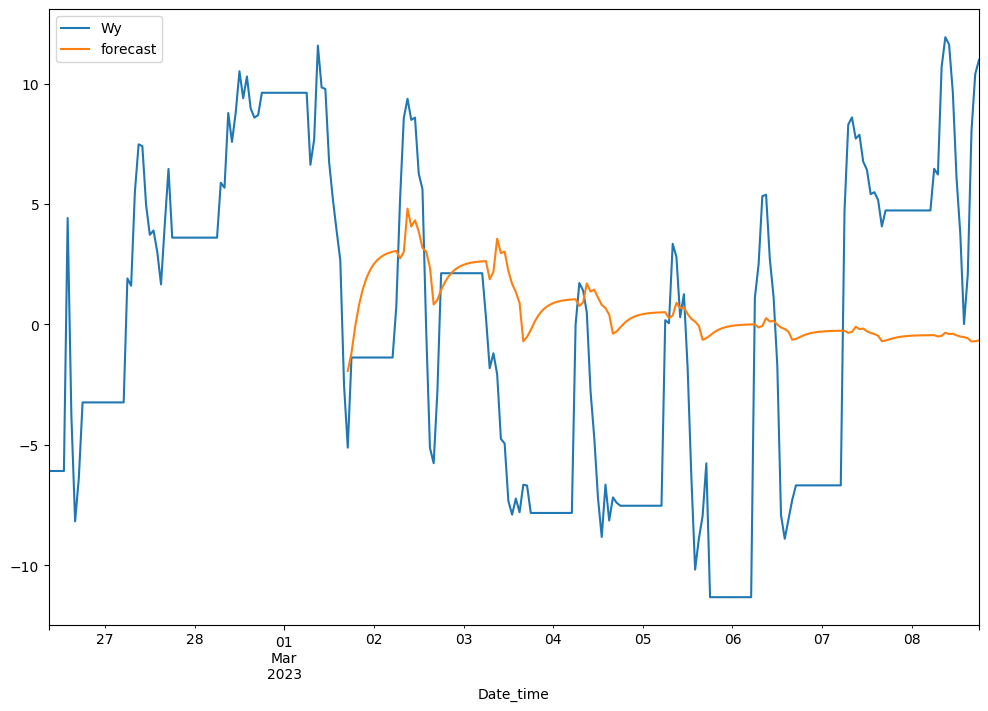

In [240]:
dfinput1['forecast']=results.predict(start=80,dynamic=True)
dfinput1[['Wy','forecast']].plot(figsize=(12,8))

In [241]:
# Predict the next 6 hours of data
forecast =results.forecast(steps=100)
# Print the forecasted values
print(forecast)

2023-03-08 19:00:00    10.589217
2023-03-08 20:00:00    10.077583
2023-03-08 21:00:00     9.650003
2023-03-08 22:00:00     9.326595
2023-03-08 23:00:00     9.089831
                         ...    
2023-03-12 18:00:00    16.303632
2023-03-12 19:00:00    16.259757
2023-03-12 20:00:00    16.203996
2023-03-12 21:00:00    16.157399
2023-03-12 22:00:00    16.122155
Freq: H, Name: predicted_mean, Length: 100, dtype: float64


In [242]:
org

Wy
Date_time                     
2023-03-08 19:00:00  10.991593
2023-03-08 20:00:00  10.991593
2023-03-08 21:00:00  10.991593
2023-03-08 22:00:00  10.991593
2023-03-08 23:00:00  10.991593
...                        ...
2023-03-15 05:00:00  -6.403374
2023-03-15 06:00:00  -6.403374
2023-03-15 07:00:00   0.165845
2023-03-15 08:00:00   1.219804
2023-03-15 09:00:00   0.663165

[159 rows x 1 columns]

In [243]:
import pandas as pd
y_test = pd.DataFrame(forecast)
#y_test= pd.Data_Frame(forecast,colunms=["Y_test"])
y_test.to_csv("sarimax.csv")

In [244]:
org.to_csv("sarimaxt.csv")

In [245]:
# Generate the dates for the next 6 hours
last_hour = dfinput1.index[-1]
future_dates = pd.date_range(last_hour, periods=10, freq='H')

# Predict the next 6 hours of data
forecast = results.forecast(steps=10)

# Combine the forecasted values and the future dates into a new DataFrame
forecast_df = pd.DataFrame(forecast, index=future_dates, columns=['predicted_value'])

# Print the forecasted values and dates
print(forecast_df)

                    predicted_value
2023-03-08 18:00:00             NaN
2023-03-08 19:00:00             NaN
2023-03-08 20:00:00             NaN
2023-03-08 21:00:00             NaN
2023-03-08 22:00:00             NaN
2023-03-08 23:00:00             NaN
2023-03-09 00:00:00             NaN
2023-03-09 01:00:00             NaN
2023-03-09 02:00:00             NaN
2023-03-09 03:00:00             NaN


In [246]:
df_merged7 = pd.merge(y_test, org['Wy'], left_index=True, right_index=True)
df_merged7

predicted_mean         Wy
2023-03-08 19:00:00       10.589217  10.991593
2023-03-08 20:00:00       10.077583  10.991593
2023-03-08 21:00:00        9.650003  10.991593
2023-03-08 22:00:00        9.326595  10.991593
2023-03-08 23:00:00        9.089831  10.991593
...                             ...        ...
2023-03-12 18:00:00       16.303632  -3.538985
2023-03-12 19:00:00       16.259757  -3.538985
2023-03-12 20:00:00       16.203996  -3.538985
2023-03-12 21:00:00       16.157399  -3.538985
2023-03-12 22:00:00       16.122155  -3.538985

[100 rows x 2 columns]

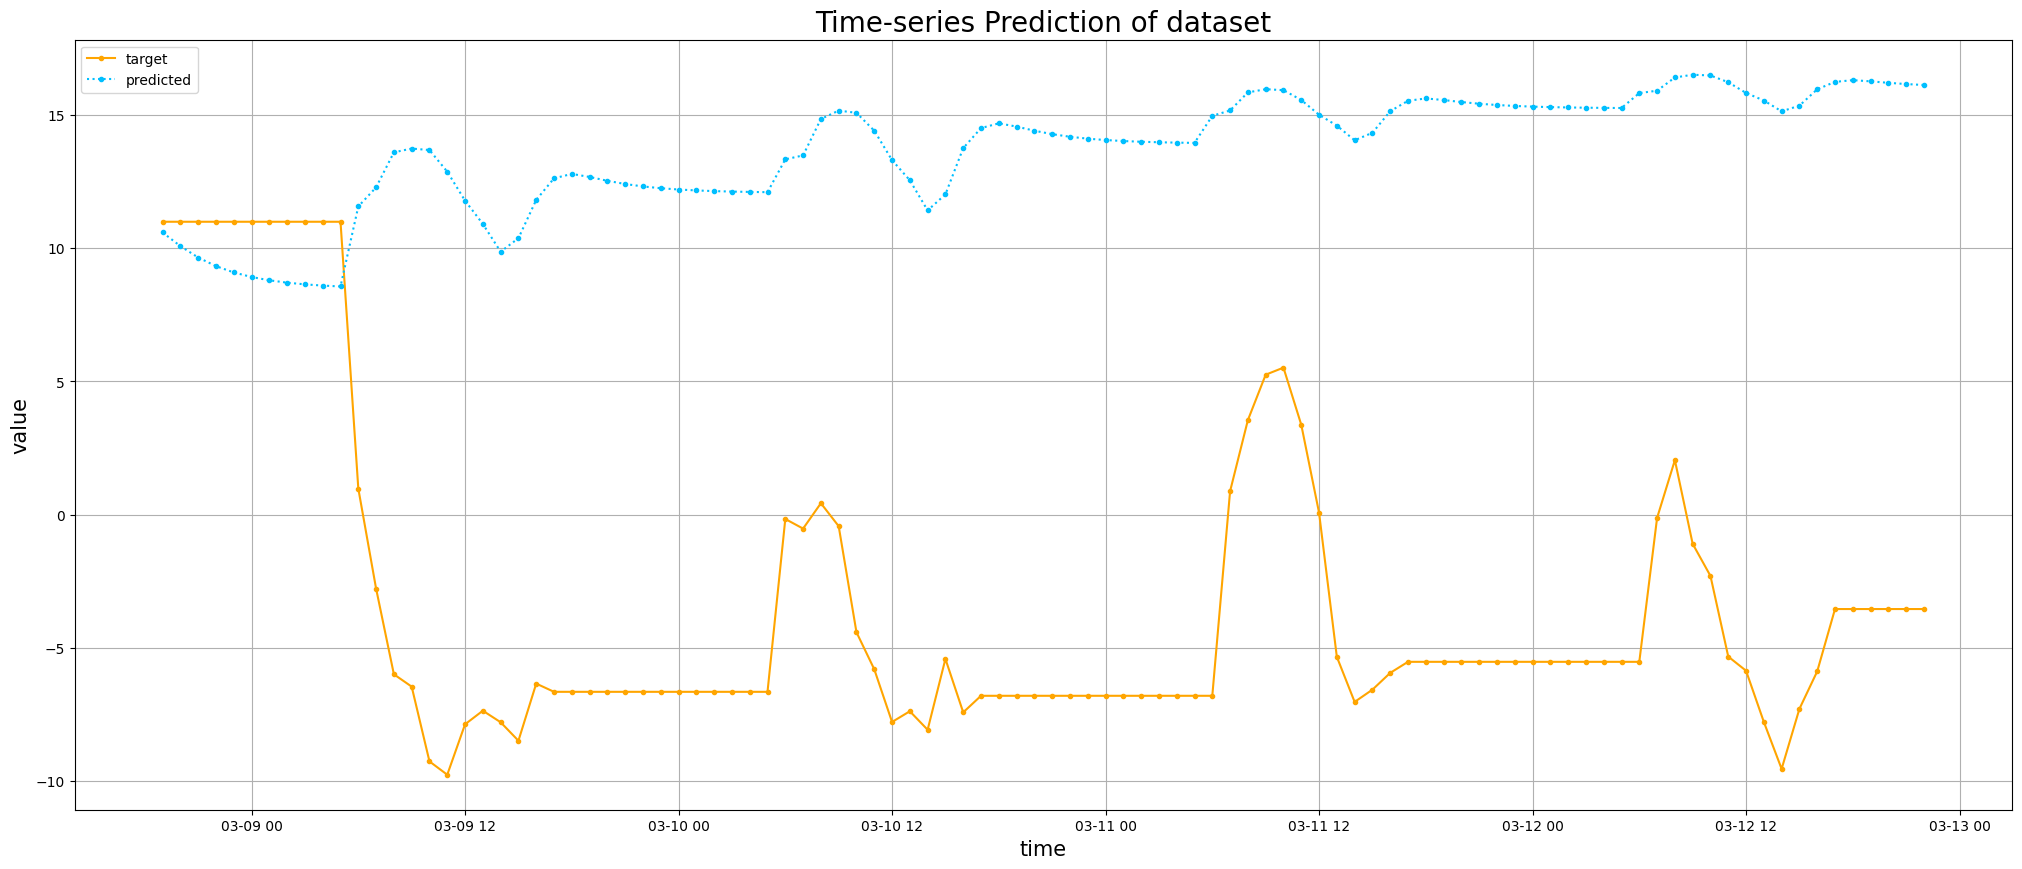

In [247]:
plt.figure(figsize=(25,10))
targetPlot,=plt.plot(df_merged7.Wy,label='target',color='orange',marker='.',linestyle='-')
predictedPlot,=plt.plot(df_merged7.predicted_mean,label='predicted',color='deepskyblue',marker='.',linestyle=':')
plt.ylabel('value',fontsize=15)
plt.xlabel('time',fontsize=15)
plt.ion()
plt.grid()
plt.legend(handles=[targetPlot, predictedPlot])
plt.title('Time-series Prediction of dataset',fontsize=20,fontweight=40)
plt.draw()
plt.show()
plt.pause(0)

In [248]:
import pandas as pd

import pandas as pd
# Rename a column
df_merged7= df_merged7.drop('Wy', axis=1)
df_input_model7 = df_merged7.rename(columns={'predicted_mean': 'Wy'})
df_input_model7



Wy
2023-03-08 19:00:00  10.589217
2023-03-08 20:00:00  10.077583
2023-03-08 21:00:00   9.650003
2023-03-08 22:00:00   9.326595
2023-03-08 23:00:00   9.089831
...                        ...
2023-03-12 18:00:00  16.303632
2023-03-12 19:00:00  16.259757
2023-03-12 20:00:00  16.203996
2023-03-12 21:00:00  16.157399
2023-03-12 22:00:00  16.122155

[100 rows x 1 columns]

In [249]:
df_input_model = pd.concat([df_input_model, df_input_model7], axis=1)


Outside_Temperature_datap  TS1_SENS0700_TmpMdul_C_data  \
2023-03-08 19:00:00                  28.652229                    32.961904   
2023-03-08 20:00:00                  29.129358                    35.041448   
2023-03-08 21:00:00                  29.483779                    36.262734   
2023-03-08 22:00:00                  29.752213                    37.422303   
2023-03-08 23:00:00                  29.937931                    38.319186   
...                                        ...                          ...   
2023-03-12 18:00:00                  28.385338                    33.689767   
2023-03-12 19:00:00                  28.570044                    34.716321   
2023-03-12 20:00:00                  28.722899                    35.882323   
2023-03-12 21:00:00                  28.853979                    36.519246   
2023-03-12 22:00:00                  28.970189                    37.166788   

                     Barometer_data  Solar_Radiation_data_SQ  \
2023-03-08 19:00:00     1011.000000                 9.694412   
2023-03-08 20:00:00     1010.998046                10.191204   
2023-03-08 21:00:00     1010.984692                10.619054   
2023-03-08 22:00:00     1010.968732                10.987513   
2023-03-08 23:00:00     1010.960915                11.304808   
...                             ...                      ...   
2023-03-12 18:00:00     1006.569456                11.993426   
2023-03-12 19:00:00     1006.569456                12.188026   
2023-03-12 20:00:00     1006.568058                12.355465   
2023-03-12 21:00:00     1006.558503                12.499506   
2023-03-12 22:00:00     1006.547085                12.623389   

                     Outside_Humidity_data         Wx         Wy  
2023-03-08 19:00:00              46.611910  11.659367  10.589217  
2023-03-08 20:00:00              46.289878  10.876850  10.077583  
2023-03-08 21:00:00              45.989186  10.136348   9.650003  
2023-03-08 22:00:00              45.708676   9.441572   9.326595  
2023-03-08 23:00:00              45.447269   8.788468   9.089831  
...                                    ...        ...        ...  
2023-03-12 18:00:00              51.242045   0.815798  16.303632  
2023-03-12 19:00:00              51.183954   0.762065  16.259757  
2023-03-12 20:00:00              51.131319   0.712407  16.203996  
2023-03-12 21:00:00              51.083937   0.665571  16.157399  
2023-03-12 22:00:00              51.041627   0.621595  16.122155  

[100 rows x 7 columns]

In [250]:
df_input_model.to_csv("WW.csv")

**Final_dataset_for_input_values**
---

In [ ]:
df_input_model

In [251]:
dfinput =df[['TS1_P1_data']]
data_hourly = dfinput.resample('H').mean().ffill()
data_hourly=data_hourly[27300:]
data_hourly.shape
data_hourly=data_hourly[200:]
data_hourly.shape
org=data_hourly[250:]
org

TS1_P1_data
Date_time                       
2023-03-08 19:00:00    88.913043
2023-03-08 20:00:00    88.913043
2023-03-08 21:00:00    88.913043
2023-03-08 22:00:00    88.913043
2023-03-08 23:00:00    88.913043
...                          ...
2023-03-15 05:00:00   536.122807
2023-03-15 06:00:00   536.122807
2023-03-15 07:00:00   516.600000
2023-03-15 08:00:00   782.933333
2023-03-15 09:00:00   830.791667

[159 rows x 1 columns]

In [252]:
org=org[:100]
org

TS1_P1_data
Date_time                       
2023-03-08 19:00:00    88.913043
2023-03-08 20:00:00    88.913043
2023-03-08 21:00:00    88.913043
2023-03-08 22:00:00    88.913043
2023-03-08 23:00:00    88.913043
...                          ...
2023-03-12 18:00:00   545.614035
2023-03-12 19:00:00   545.614035
2023-03-12 20:00:00   545.614035
2023-03-12 21:00:00   545.614035
2023-03-12 22:00:00   545.614035

[100 rows x 1 columns]

In [253]:
df_input_model = pd.concat([df_input_model,org], axis=1)
df_input_model

Outside_Temperature_datap  TS1_SENS0700_TmpMdul_C_data  \
2023-03-08 19:00:00                  28.652229                    32.961904   
2023-03-08 20:00:00                  29.129358                    35.041448   
2023-03-08 21:00:00                  29.483779                    36.262734   
2023-03-08 22:00:00                  29.752213                    37.422303   
2023-03-08 23:00:00                  29.937931                    38.319186   
...                                        ...                          ...   
2023-03-12 18:00:00                  28.385338                    33.689767   
2023-03-12 19:00:00                  28.570044                    34.716321   
2023-03-12 20:00:00                  28.722899                    35.882323   
2023-03-12 21:00:00                  28.853979                    36.519246   
2023-03-12 22:00:00                  28.970189                    37.166788   

                     Barometer_data  Solar_Radiation_data_SQ  \
2023-03-08 19:00:00     1011.000000                 9.694412   
2023-03-08 20:00:00     1010.998046                10.191204   
2023-03-08 21:00:00     1010.984692                10.619054   
2023-03-08 22:00:00     1010.968732                10.987513   
2023-03-08 23:00:00     1010.960915                11.304808   
...                             ...                      ...   
2023-03-12 18:00:00     1006.569456                11.993426   
2023-03-12 19:00:00     1006.569456                12.188026   
2023-03-12 20:00:00     1006.568058                12.355465   
2023-03-12 21:00:00     1006.558503                12.499506   
2023-03-12 22:00:00     1006.547085                12.623389   

                     Outside_Humidity_data         Wx         Wy  TS1_P1_data  
2023-03-08 19:00:00              46.611910  11.659367  10.589217    88.913043  
2023-03-08 20:00:00              46.289878  10.876850  10.077583    88.913043  
2023-03-08 21:00:00              45.989186  10.136348   9.650003    88.913043  
2023-03-08 22:00:00              45.708676   9.441572   9.326595    88.913043  
2023-03-08 23:00:00              45.447269   8.788468   9.089831    88.913043  
...                                    ...        ...        ...          ...  
2023-03-12 18:00:00              51.242045   0.815798  16.303632   545.614035  
2023-03-12 19:00:00              51.183954   0.762065  16.259757   545.614035  
2023-03-12 20:00:00              51.131319   0.712407  16.203996   545.614035  
2023-03-12 21:00:00              51.083937   0.665571  16.157399   545.614035  
2023-03-12 22:00:00              51.041627   0.621595  16.122155   545.614035  

[100 rows x 8 columns]

In [254]:
df_input_model.columns

Index(['Outside_Temperature_datap', 'TS1_SENS0700_TmpMdul_C_data',
       'Barometer_data', 'Solar_Radiation_data_SQ', 'Outside_Humidity_data',
       'Wx', 'Wy', 'TS1_P1_data'],
      dtype='object')

In [265]:
df_input_model2 = df_input_model.reindex(columns=['TS1_P1_data','TS1_SENS0700_TmpMdul_C_data', 'Barometer_data',
       'Outside_Humidity_data', 'Outside_Temperature_datap',
       'Solar_Radiation_data_SQ','Wx','Wy',])

In [266]:
df_input_model2

TS1_P1_data  TS1_SENS0700_TmpMdul_C_data  Barometer_data  \
2023-03-08 19:00:00    88.913043                    32.961904     1011.000000   
2023-03-08 20:00:00    88.913043                    35.041448     1010.998046   
2023-03-08 21:00:00    88.913043                    36.262734     1010.984692   
2023-03-08 22:00:00    88.913043                    37.422303     1010.968732   
2023-03-08 23:00:00    88.913043                    38.319186     1010.960915   
...                          ...                          ...             ...   
2023-03-12 18:00:00   545.614035                    33.689767     1006.569456   
2023-03-12 19:00:00   545.614035                    34.716321     1006.569456   
2023-03-12 20:00:00   545.614035                    35.882323     1006.568058   
2023-03-12 21:00:00   545.614035                    36.519246     1006.558503   
2023-03-12 22:00:00   545.614035                    37.166788     1006.547085   

                     Outside_Humidity_data  Outside_Temperature_datap  \
2023-03-08 19:00:00              46.611910                  28.652229   
2023-03-08 20:00:00              46.289878                  29.129358   
2023-03-08 21:00:00              45.989186                  29.483779   
2023-03-08 22:00:00              45.708676                  29.752213   
2023-03-08 23:00:00              45.447269                  29.937931   
...                                    ...                        ...   
2023-03-12 18:00:00              51.242045                  28.385338   
2023-03-12 19:00:00              51.183954                  28.570044   
2023-03-12 20:00:00              51.131319                  28.722899   
2023-03-12 21:00:00              51.083937                  28.853979   
2023-03-12 22:00:00              51.041627                  28.970189   

                     Solar_Radiation_data_SQ         Wx         Wy  
2023-03-08 19:00:00                 9.694412  11.659367  10.589217  
2023-03-08 20:00:00                10.191204  10.876850  10.077583  
2023-03-08 21:00:00                10.619054  10.136348   9.650003  
2023-03-08 22:00:00                10.987513   9.441572   9.326595  
2023-03-08 23:00:00                11.304808   8.788468   9.089831  
...                                      ...        ...        ...  
2023-03-12 18:00:00                11.993426   0.815798  16.303632  
2023-03-12 19:00:00                12.188026   0.762065  16.259757  
2023-03-12 20:00:00                12.355465   0.712407  16.203996  
2023-03-12 21:00:00                12.499506   0.665571  16.157399  
2023-03-12 22:00:00                12.623389   0.621595  16.122155  

[100 rows x 8 columns]

In [267]:
df_input_model2['Date_time_step'] = df_input_model.index

In [268]:
df_input_model2['Date_time_step'] = pd.to_datetime(df_input_model2['Date_time_step'], infer_datetime_format=True)

In [269]:
date_time = pd.to_datetime(df_input_model2.pop('Date_time_step'), format='%d/%m/%Y %H:%M')
date_time

2023-03-08 19:00:00   2023-03-08 19:00:00
2023-03-08 20:00:00   2023-03-08 20:00:00
2023-03-08 21:00:00   2023-03-08 21:00:00
2023-03-08 22:00:00   2023-03-08 22:00:00
2023-03-08 23:00:00   2023-03-08 23:00:00
                              ...        
2023-03-12 18:00:00   2023-03-12 18:00:00
2023-03-12 19:00:00   2023-03-12 19:00:00
2023-03-12 20:00:00   2023-03-12 20:00:00
2023-03-12 21:00:00   2023-03-12 21:00:00
2023-03-12 22:00:00   2023-03-12 22:00:00
Freq: H, Name: Date_time_step, Length: 100, dtype: datetime64[ns]

In [270]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)

In [271]:
import numpy as np
day = 24*60*60
year = (365.2425)*day

df_input_model2['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df_input_model2['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df_input_model2['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df_input_model2['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

In [274]:
df_input_model2.to_csv("Future_Weather_parameters.csv")